In [2]:
from astropy.io import fits
from astropy.table import Table, QTable
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import sqrt, log10
from astropy.io import ascii
import astropy.io
from astropy.coordinates import Longitude

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker

#For displaying fits image
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

In [3]:
#Open the appropriate fits file, extract relevant data, close file
hdul = fits.open('c:\\users\\sahal\\2018TrinaryWork\\gaiadr2_OrionTables.fits')
pmra_all = hdul[1].data['pmra'] / 3600000 #pmra is in mas/yr - converts to deg/yr
pmdec_all = hdul[1].data['pmdec'] / 3600000 #pmdec is in mas/yr - converts to deg/yr
radial_velocity_all = hdul[1].data['radial_velocity'] #radial velocity is in mas/yr? or parsec/yr?
source_id_all = hdul[1].data['source_id']
ra_all = hdul[1].data['ra'] #ra in deg
dec_all = hdul[1].data['dec'] #dec in deg
parallax_all = hdul[1].data['parallax'] #parallax in mas

G_all = hdul[1].data['phot_g_mean_mag'] #magnitudes in G filter
Gb_all = hdul[1].data['phot_bp_mean_mag']#magnitudes in Gbp filter
Gr_all = hdul[1].data['phot_rp_mean_mag']#magnitudes in Brp filter

bp_rp_all = hdul[1].data['bp_rp']#color difference b-r
#This is the same as subtracting Gb - Gr

ra_err_all = hdul[1].data['ra_error']
dec_err_all = hdul[1].data['dec_error']
pmra_err_all = hdul[1].data['pmra_error']
pmdec_err_all = hdul[1].data['pmdec_error']

parallax_err_all = hdul[1].data['parallax_error']
rv_err_all = hdul[1].data['radial_velocity_error']

hdul.close()

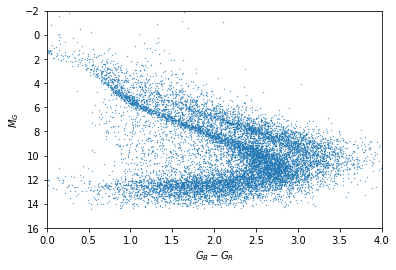

In [4]:
#Absolute magnitude in terms of G and p
Mg_all = [G + 5 - 5*(log10(1000/p)) for G, p in zip(G_all, parallax_all)]
#p is in mas so we divide the listed 1000 by 10

plt.plot(bp_rp_all, Mg_all, '.',markersize = .6)
plt.xlim(0,4)
plt.ylim(16,-2)
plt.xlabel("$G_B - G_R$")
plt.ylabel("$M_G$")
plt.show()

In [5]:
#Get the indices ii of all values for stars that satisfy appropriate photometric conditions
ii = []

for i in range(len(source_id_all)):
    if( (Mg_all[i]<2.46*(bp_rp_all[i])+2.76 and .3<(bp_rp_all[i])<1.8)
       or (Mg_all[i]<2.8*(bp_rp_all[i])+2.16 and 1.8<(bp_rp_all[i]))):
       #or (Mg_all[i]>2.14*(bp_rp_all[i])-.57 and .5<(bp_rp_all[i])<1.2)
       #or (Mg_all[i]>1.11*(bp_rp_all[i])+.66 and 1.2<(bp_rp_all[i])<3)):
        ii.append(i)
        
print(len(ii))

4022


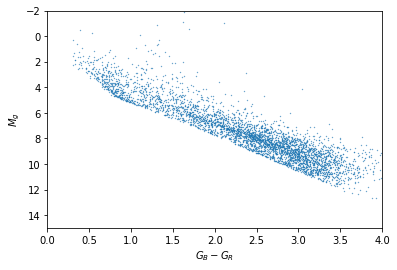

In [6]:
#Redefine our data as all stars that fit photometric parameters of young stars
pmra = pmra_all[ii]
pmdec = pmdec_all[ii]
radial_velocity = radial_velocity_all[ii]
source_id = source_id_all[ii]
ra = ra_all[ii]
dec = dec_all[ii]
parallax = parallax_all[ii]

G = G_all[ii]
Gb = Gb_all[ii]
Gr = Gr_all[ii]

bp_rp = bp_rp_all[ii]

ra_err = ra_err_all[ii]
dec_err = dec_err_all[ii]
pmra_err = pmra_err_all[ii]
pmdec_err = pmdec_err_all[ii]

parallax_err = parallax_err_all[ii]
rv_err = rv_err_all[ii]

#############################

Mg = [G + 5 - 5 * log10(1000/p) for G, p in zip(G, parallax)]

plt.plot(bp_rp, Mg, '.',markersize = .6)
plt.xlim(0,4)
plt.ylim(15,-2)
plt.xlabel("$G_B - G_R$")
plt.ylabel("$M_g$")
plt.show()

In [7]:
def toffset(pmra, pmdec, dt):
    return (pmra * dt, pmdec * dt)

def dist(ra, dec):
    return np.array([np.sqrt( (ra[i]-ra)**2 +  (dec[i]-dec)**2 ) for i in range(len(ra))])

arcsec = 1 / 3600
def updated(ra_in, dec_in, pmra_in, pmdec_in, tstep):
    pmraProj, pmdecProj = toffset(pmra_in, pmdec_in, tstep)
    ra_t = ra_in + pmraProj
    dec_t = dec_in + pmdecProj
    
    alldists = dist(ra_t,dec_t)
    
    successfulMatch = np.where((alldists < arcsec) & (alldists != 0.))
    
    return [tstep,successfulMatch[0]]    


This has been extracted in previous work, so to save running time I pick up with a .npz file containing the timesteps and raw indices of stars

In [7]:
fnam = 'c:\\users\\sahal\\2018trinarywork\\jupyterfiles\\timecoords.npz'
inVals = np.load(fnam) #has entries ['time'] and ['ind']

tts = inVals['time']
iind = inVals['ind']

tts = np.flip(tts,0)
iind = np.flip(iind,0)


ta = Table([tts, np.array(iind)], names = ('times', 'inds'), meta = {'name': 'IndTable'})
ta.remove_rows(slice(0,4))#I accidentally projected a few years in the future so this cuts the timesteps off at 0
tts = ta['times']
iinds = ta['inds']

In [8]:
################################################################################
#Now match them up by distance:
################################################################################

def getCoords(ra,dec, pmra, pmdec, t):
    if t != 0:
        pmra_atT = pmra * t
        pmdec_atT = pmdec * t
    else:
        pmra_atT = pmra
        pmdec_atT = pmdec

    ra_atT = ra + pmra_atT
    dec_atT = dec + pmdec_atT
    return [ra_atT, dec_atT, pmra, pmdec]

def dist(ra, dec):
    return np.array([np.sqrt( (ra[i]-ra)**2 +  (dec[i]-dec)**2 ) for i in range(len(ra))])

arcsec = 1/3600
for mm in range(len(ta)):
    chunk = ta['inds'][mm]
    tim = ta['times'][mm]
    coords = getCoords(ra, dec, pmra, pmdec,tim)
    if not (len(chunk) > 2):
        ta['inds'][mm] = [list(chunk)]
    else:
        mat = dist(coords[0][chunk], coords[1][chunk])
        a, b = mat.shape
        sel = np.tril_indices(a)
        mat[sel] = 0

        rawlist = list(np.where((mat < arcsec) & (mat != 0)))
        rawlist = [list(i) for i in rawlist]
        xs = [[chunk[i], chunk[j]] for i, j in zip(rawlist[0], rawlist[1])]
        ta['inds'][mm] = xs

In [9]:
flattened = []
timesflat = []
for ind in range(len(ta['inds'])):
    entry = ta['inds'][ind]
    tt = ta['times'][ind]
    for i in entry:
        timesflat.append(tt)
        flattened.append(i)

tab = Table([timesflat, np.array(flattened)], names = ('times', 'ind'), meta = {'name': 'UpdatedTable'})

datlist = tab['ind']
tilist = tab['times']
checklist = np.array([str(cc) for cc in flattened])

selectRows = []
for entry in checklist:
    b = np.where(checklist == entry)[0]
    dlist = []
    for i in b:
        indPairs = datlist[i]
        ra_b, dec_b = getCoords(ra[indPairs], dec[indPairs], pmra[indPairs], pmdec[indPairs], tilist[i])[0:2]
        ds = dist(ra_b, dec_b)[0][1]
        dlist.append(ds)
    selector = np.argmin(dlist)
    cval = b[selector]
    selectRows.append(int(cval))

selectRows = list(set(selectRows))
selectRows.sort()

tabtimes = [tilist[i] for i in selectRows]
tabinds = [[datlist[i]] for i in selectRows]

tabl = Table([tabtimes, tabinds], names = ('Time', 'Indices'), meta = {'name': 'SortedVals'})
#tabl.show_in_notebook()
print(tabl)

  Time  Indices [1,2]
------- -------------
   -400    604 .. 608
   -900  3173 .. 3201
  -1700  3965 .. 3966
  -2000    971 .. 972
  -2600  1015 .. 1017
  -3600  2418 .. 2419
  -4200  1274 .. 1275
  -4300  3491 .. 3503
  -4500    197 .. 198
  -4700  3450 .. 3493
    ...           ...
-954800  1286 .. 1733
-955100   280 .. 2337
-957400  1445 .. 3328
-958400  2014 .. 2248
-962500  3662 .. 3914
-965300    625 .. 712
-969900   157 .. 2408
-971400    689 .. 985
-975600  1326 .. 2439
-978600  2911 .. 3281
-983700  3383 .. 3568
Length = 440 rows


In [10]:
def getParallelMotion(inds):
    s1 = inds[0]
    s2 = inds[1]
    vec1 = np.array([pmra[s1], pmdec[s1]])
    vec2 = np.array([pmra[s2], pmdec[s2]])
    intr = vec1/2 + vec2/2
    return intr * 3600 * 1000 #Converts to miliarcseconds per year

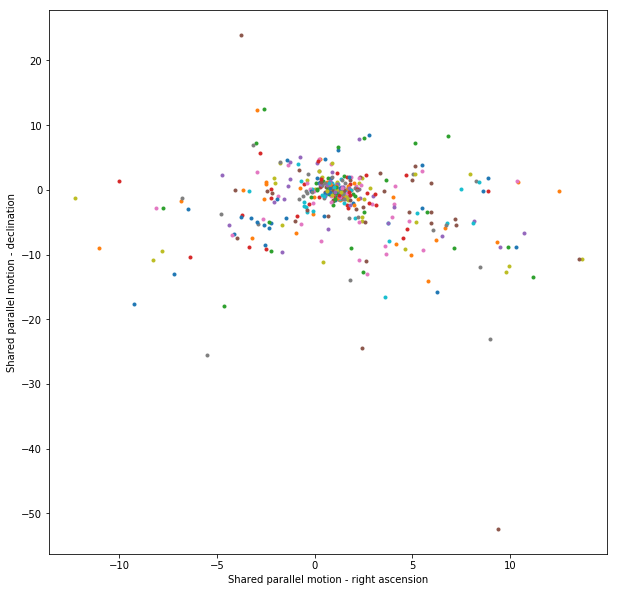

In [11]:
fig, axs = plt.subplots(figsize = (10,10))
for chunk in tabl['Indices']:
    for pair in chunk:
        raVal, decVal = getParallelMotion(pair)
        axs.plot([raVal], [decVal], '.')
axs.set_xlabel('Shared parallel motion - right ascension')
axs.set_ylabel('Shared parallel motion - declination')
#axs.set_ylim(-.00001, .00001)
plt.show()

In [12]:
tabRa1 = []
tabRa2 = []
tabDec1 = []
tabDec2 = []
tabPmra1 = []
tabPmra2 = []
tabPmdec1 = []
tabPmdec2 = []

tabRaInitial1 = []
tabDecInitial1 = []
tabRaInitial2 = []
tabDecInitial2 =[]

tabPar1 = []
tabPar2 = []

tabRv1 = []
tabRv2 = []

ref_pmra = []
ref_pmdec = []

tabRa_err1 = []
tabDec_err1 = []
tabPmra_err1 = []
tabPmdec_err1 = []

tabRa_err2 = []
tabDec_err2 = []
tabPmra_err2 = []
tabPmdec_err2 = []

tabPar_err1 = []
tabRv_err1 = []
tabPar_err2 = []
tabRv_err2 = []

tabAbs_g1 = []
tabBp_rp1 = []
tabAbs_g2 = []
tabBp_rp2 = []

tabTime = []


for i in range(len(tabl)):
    inds = tabl['Indices'][i]
    inds = inds[0]
    time = tabl['Time'][i]
    
    tProject = getCoords(ra[inds], dec[inds], pmra[inds], pmdec[inds], time)
    vec = getParallelMotion(inds)
    
    tabTime.append(time)
    tabRa1.append(tProject[0][0]) #ra1
    tabDec1.append(tProject[1][0]) #dec1
    tabPmra1.append(tProject[2][0] * 3600 * 1000) #pmra1
    tabPmdec1.append(tProject[3][0] * 3600 * 1000) #pmdec1
    
    tabRa2.append(tProject[0][1]) #ra2
    tabDec2.append(tProject[1][1]) #dec2
    tabPmra2.append(tProject[2][1] * 3600 * 1000) #pmra2
    tabPmdec2.append(tProject[3][1] * 3600 * 1000) #pmdec2
    
    #These down could be done outside of the loop
    tabRaInitial1.append(ra[inds[0]])
    tabDecInitial1.append(dec[inds[0]])
    tabRaInitial2.append(ra[inds[1]])
    tabDecInitial2.append(dec[inds[1]])
    
    
    tabPar1.append(parallax[inds[0]]) #parallax1
    tabPar2.append(parallax[inds[1]]) #parallax2
    
    tabRv1.append(radial_velocity[inds[0]])
    tabRv2.append(radial_velocity[inds[1]])
    
    ref_pmra.append(vec[0]) #Add these to the table
    ref_pmdec.append(vec[1])
    
    tabAbs_g1.append(G[inds[0]])
    tabAbs_g2.append(G[inds[1]])
    tabBp_rp1.append(bp_rp[inds[0]])
    tabBp_rp2.append(bp_rp[inds[1]])
    
    tabRa_err1.append(ra_err[inds[0]])
    tabDec_err1.append(dec_err[inds[0]])
    tabPmra_err1.append(pmra_err[inds[0]])
    tabPmdec_err1.append(pmdec_err[inds[0]])

    tabRa_err2.append(ra_err[inds[1]])
    tabDec_err2.append(dec_err[inds[1]])
    tabPmra_err2.append(pmra_err[inds[1]])
    tabPmdec_err2.append(pmdec_err[inds[1]])
    
    tabPar_err1.append(parallax_err[inds[0]])
    tabPar_err2.append(parallax_err[inds[1]])
    tabRv_err1.append(rv_err[inds[0]])
    tabRv_err2.append(rv_err[inds[1]])
    
populatedTable = Table(
    [tabRaInitial1, tabDecInitial1, tabPmra1, tabPmdec1, tabRa1, tabDec1, tabPar1, tabRv1,tabAbs_g1, tabBp_rp1,
     tabRa_err1, tabDec_err1, tabPmra_err1, tabPmdec_err1, tabPar_err1, tabRv_err1,
     
     tabRaInitial2, tabDecInitial2, tabPmra2, tabPmdec2, tabRa2, tabDec2, tabPar2, tabRv2, tabAbs_g2, tabBp_rp2,
     tabRa_err2, tabDec_err2, tabPmra_err2, tabPmdec_err2, tabPar_err2, tabRv_err2,
     ref_pmra, ref_pmdec, tabTime],    
    names = ('ra1', 'dec1', 'pmra1', 'pmdec1', 'projected_ra1', 'projected_dec1', 'parallax1', 'rVelocity1', 'G1', 'bprp1',
             'ra_err1', 'dec_err1', 'pmra_err1', 'pmdec_err1', 'parralax_err1', 'rv_err1',
             'ra2', 'dec2', 'pmra2', 'pmdec2', 'projected_ra2', 'projected_dec2', 'parallax2', 'rVelocity2', 'G2', 'bprp2',
             'ra_err2', 'dec_err2', 'pmra_err2', 'pmdec_err2', 'parralax_err2', 'rv_err2',
             'ref_pmra', 'ref_pmdec', 'time'),
    meta = {'name': 'CompleteTable'})

In [13]:
populatedTable #Note radial velocities are often nan

ra1,dec1,pmra1,pmdec1,projected_ra1,projected_dec1,parallax1,rVelocity1,G1,bprp1,ra_err1,dec_err1,pmra_err1,pmdec_err1,parralax_err1,rv_err1,ra2,dec2,pmra2,pmdec2,projected_ra2,projected_dec2,parallax2,rVelocity2,G2,bprp2,ra_err2,dec_err2,pmra_err2,pmdec_err2,parralax_err2,rv_err2,ref_pmra,ref_pmdec,time
float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int32
83.48251170091393,-4.797265264995391,0.6447739881206371,0.946648818204142,83.4824400593597,-4.797370448197414,2.446124574615641,nan,16.8622,2.7225971,0.0975906924092268,0.09586025503680433,0.2411820526140304,0.1982581688380465,0.13176411603228833,nan,83.48253321864347,-4.797049560919736,-0.07499483289390126,1.3499021915126073,83.48254155140268,-4.7971995500521265,2.479931510507315,nan,16.948454,2.6344328,0.1091233109154024,0.10085048692611268,0.2713176242934988,0.2537414393881067,0.13401914755570907,nan,0.284889577613368,1.1482755048583748,-400
84.53876810637198,-6.821279333750583,0.24341211743322042,-0.5376869219573865,84.53870725334262,-6.8211449120200935,2.555351015682546,nan,13.023477,2.278349,0.03657946680206794,0.043071152775523674,0.08480524907547862,0.08690065435335688,0.05314236868699175,nan,84.53840611426924,-6.824308421585931,-2.1650734999397305,-12.71708095634933,84.53894738264422,-6.8211291513468435,2.381508354627957,nan,18.831034,3.316311,0.218529866356268,0.24742385187365107,0.5494369682820555,0.5891574911896434,0.3027479997254582,nan,-0.9608306912532552,-6.627383939153358,-900
84.50349454157684,-7.264919768031094,-0.010701943245293588,1.3953914020712481,84.50349959527226,-7.26557870285985,3.152727556491071,nan,15.249276,2.1309347,0.09954479511210143,0.0933556609361285,0.24836261730137532,0.20048602022075482,0.13085510796305624,nan,84.50335136108642,-7.265221329201588,0.11152819090463771,0.8443734708342436,84.50329869499626,-7.265620061118371,2.6833273594620985,nan,15.752002,2.3069115,0.08932226618754684,0.08195359697557524,0.19207466954507768,0.16359151484472476,0.10607502368011383,nan,0.050413123829672064,1.119882436452746,-1700
84.08028325875834,-5.0079025103820145,1.9289053108034433,0.10875771429393918,84.07921164469678,-5.0079629313344,2.380364991994506,nan,17.38141,3.2439833,0.09092217957386244,0.09248528687591666,0.22757602112369593,0.23283750486366234,0.11973001911974872,nan,84.07983711301937,-5.010653864554236,1.416340135215205,-4.906162244794249,84.07905025738869,-5.007928218862683,2.1517806811876303,nan,16.9702,2.341385,0.060584980841551686,0.061652922293499036,0.1503192418278543,0.1531460075089603,0.07901936980633972,nan,1.6726227230093242,-2.398702265250155,-2000
83.85776095102422,-5.132364341100109,3.525223471317901,-0.6938061298633568,83.85521495629493,-5.131863258895208,2.507368734750781,nan,14.307585,2.1879883,0.02545239424027045,0.027579579759516835,0.058046045197556996,0.05561210751701419,0.03437069040242561,nan,83.85690201927144,-5.132569536849398,2.4404869156115954,-1.1889684760861023,83.85513944538795,-5.131710837394447,2.671313954363518,nan,15.432099,3.105173,0.08750562534712117,0.09272331631182928,0.20602097167940933,0.18852674170235675,0.12109833413754126,nan,2.982855193464748,-0.9413873029747294,-2600
83.34410194171222,-5.544440845586294,0.6748556793650204,-0.5098740984182977,83.34342708603286,-5.5439309714878755,2.5627001622811405,nan,15.797495,2.4328175,0.04052977143774015,0.04396736644833838,0.09414459566951451,0.09660420650968513,0.06300865240435996,nan,83.34336921538706,-5.5426058067787745,-0.1759589082098121,1.241023365508144,83.34354517429527,-5.5438468301442825,3.3059120378334512,nan,13.9214325,1.8929348,0.17341219875726513,0.18472373843051418,0.4015471224687479,0.3930374821598586,0.26108914422589574,nan,0.24944838557760418,0.3655746335449231,-3600
83.80750024239218,-5.368619012600222,-0.044086781065910796

In [14]:
populatedTable.write('MatchedPairData.fits', format = 'fits', overwrite = True)

##### The file `matchedWithRvs.fits` uses the file made earlier (`matchedPairData.fits`) cross-referenced with some confirmed Rvs in the region

In [15]:
enhanceTab = Table.read('c:\\users\\sahal\\2018TrinaryWork\\TrinaryStarSearch\\data\\matchedWithRvs.fits')
enhanceTab

ra1,dec1,pmra1,pmdec1,projected_ra1,projected_dec1,parallax1,rVelocity1,G1,bprp1,ra_err1,dec_err1,pmra_err1,pmdec_err1,parralax_err1,rv_err1,ra2,dec2,pmra2,pmdec2,projected_ra2,projected_dec2,parallax2,rVelocity2,G2,bprp2,ra_err2,dec_err2,pmra_err2,pmdec_err2,parralax_err2,rv_err2,ref_pmra,ref_pmdec,time,ra_1,dec_1,rv_1,rve_1,isbin_1,Separation_1,ra_2,dec_2,rv_2,rve_2,isbin_2,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,arcsec
float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,int16,float64
83.48251170091393,-4.797265264995391,0.6447739881206371,0.946648818204142,83.4824400593597,-4.797370448197414,2.446124574615641,nan,16.8622,2.7225971,0.0975906924092268,0.09586025503680433,0.2411820526140304,0.1982581688380465,0.13176411603228833,nan,83.48253321864347,-4.797049560919736,-0.07499483289390126,1.3499021915126073,83.48254155140268,-4.7971995500521265,2.479931510507315,nan,16.948454,2.6344328,0.1091233109154024,0.10085048692611268,0.2713176242934988,0.2537414393881067,0.13401914755570907,nan,0.284889577613368,1.1482755048583748,-400,83.482506,-4.797142,28.9363,0.386201,-1,0.44422500761004136,83.482506,-4.797142,28.9363,0.386201,-1,0.34681019841963845
84.53876810637198,-6.821279333750583,0.24341211743322042,-0.5376869219573865,84.53870725334262,-6.8211449120200935,2.555351015682546,nan,13.023477,2.278349,0.03657946680206794,0.043071152775523674,0.08480524907547862,0.08690065435335688,0.05314236868699175,nan,84.53840611426924,-6.824308421585931,-2.1650734999397305,-12.71708095634933,84.53894738264422,-6.8211291513468435,2.381508354627957,nan,18.831034,3.316311,0.218529866356268,0.24742385187365107,0.5494369682820555,0.5891574911896434,0.3027479997254582,nan,-0.9608306912532552,-6.627383939153358,-900,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,--,nan
84.50349454157684,-7.264919768031094,-0.010701943245293588,1.3953914020712481,84.50349959527226,-7.26557870285985,3.152727556491071,nan,15.249276,2.1309347,0.09954479511210143,0.0933556609361285,0.24836261730137532,0.20048602022075482,0.13085510796305624,nan,84.50335136108642,-7.265221329201588,0.11152819090463771,0.8443734708342436,84.50329869499626,-7.265620061118371,2.6833273594620985,nan,15.752002,2.3069115,0.08932226618754684,0.08195359697557524,0.19207466954507768,0.16359151484472476,0.10607502368011383,nan,0.050413123829672064,1.119882436452746,-1700,84.503448,-7.2650442,23.5248,0.120057,0,0.47779464343022504,84.503448,-7.2650442,23.5248,0.120057,0,0.7250625183653897
84.08028325875834,-5.0079025103820145,1.9289053108034433,0.10875771429393918,84.07921164469678,-5.0079629313344,2.380364991994506,nan,17.38141,3.2439833,0.09092217957386244,0.09248528687591666,0.22757602112369593,0.23283750486366234,0.11973001911974872,nan,84.07983711301937,-5.010653864554236,1.416340135215205,-4.906162244794249,84.07905025738869,-5.007928218862683,2.1517806811876303,nan,16.9702,2.341385,0.060584980841551686,0.061652922293499036,0.1503192418278543,0.1531460075089603,0.07901936980633972,nan,1.6726227230093242,-2.398702265250155,-2000,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,--,nan
83.85776095102422,-5.132364341100109,3.525223471317901,-0.6938061298633568,83.85521495629493,-5.131863258895208,2.507368734750781,nan,14.307585,2.1879883,0.02545239424027045,0.027579579759516835,0.058046045197556996,0.05561210751701419,0.03437069040242561,nan,83.85690201927144,-5.132569536849398,2.4404869156115954,-1.1889684760861023,83.85513944538795,-5.131710837394447,2.671313954363518,nan,15.432099,3.105173,0.08750562534712117,0.09272331631182928,0.20602097167940933,0.18852674170235675,0.12109833413754126,nan,2.982855193464748,-0.9413873029747294,-2600,83.85775,-5.1323762,28.0852,0.227183,0,0.05800344443789961

In [16]:
bi1 = enhanceTab['isbin_1']
bi2 = enhanceTab['isbin_2']

In [17]:
biIn1 = np.where(bi1 == 3)[0]
biIn2 = np.where(bi2 == 3)[0]
print(len(biIn1)+len(biIn2))

13


In [18]:
confirmed = Table.read('c:\\users\\sahal\\2018TrinaryWork\\TrinaryStarSearch\\data\\oriona-allmembers.fits')
#confirmed
#It looks like I'm going to have to match this up against my own

In [19]:
#The product of these two being matched is enhancedMatchedConfirmedMembers.fits
confEnhance = Table.read('c:\\users\\sahal\\2018TrinaryWork\\TrinaryStarSearch\\data\\enhancedMatchedConfirmedMembers.fits')
confEnhance

ra1,dec1,pmra1,pmdec1,projected_ra1,projected_dec1,parallax1,rVelocity1,G1,bprp1,ra_err1,dec_err1,pmra_err1,pmdec_err1,parralax_err1,rv_err1,ra2,dec2,pmra2,pmdec2,projected_ra2,projected_dec2,parallax2,rVelocity2,G2,bprp2,ra_err2,dec_err2,pmra_err2,pmdec_err2,parralax_err2,rv_err2,ref_pmra,ref_pmdec,time,ra_1,dec_1,rv_1,rve_1,isbin_1,Separation_1,ra_2,dec_2,rv_2,rve_2,isbin_2,Separation_1a,RA_1a,DEC_1a,apogee_1,grosschedl18_1,fang09_1,fang13_1,hsu12_1,hsu13_1,kounkel16_1,hasenberger16_1,pillitteri13_1,fang17_1,megeath12_1,kounkel17_1,rebull06_1,furesz08_1,getman05_1,hillenbrand97_1,dario10_1,dario12_1,kuhn14_1,getman14a_1,getman14b_1,sicilia-aguilar05_1,Separation_1b,RA_2a,DEC_2a,apogee_2,grosschedl18_2,fang09_2,fang13_2,hsu12_2,hsu13_2,kounkel16_2,hasenberger16_2,pillitteri13_2,fang17_2,megeath12_2,kounkel17_2,rebull06_2,furesz08_2,getman05_2,hillenbrand97_2,dario10_2,dario12_2,kuhn14_2,getman14a_2,getman14b_2,sicilia-aguilar05_2,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,int16,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64
83.48251170091393,-4.797265264995391,0.6447739881206371,0.946648818204142,83.4824400593597,-4.797370448197414,2.446124574615641,nan,16.8622,2.7225971,0.0975906924092268,0.09586025503680433,0.2411820526140304,0.1982581688380465,0.13176411603228833,nan,83.48253321864347,-4.797049560919736,-0.07499483289390126,1.3499021915126073,83.48254155140268,-4.7971995500521265,2.479931510507315,nan,16.948454,2.6344328,0.1091233109154024,0.10085048692611268,0.2713176242934988,0.2537414393881067,0.13401914755570907,nan,0.284889577613368,1.1482755048583748,-400,83.482506,-4.797142,28.9363,0.386201,-1,0.44422500761004136,83.482506,-4.797142,28.9363,0.386201,-1,0.34681019841963845,83.48250579833984,-4.797142028808594,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,0.44415530804199466,83.48250579833984,-4.797142028808594,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,0.3471140324808718
84.53876810637198,-6.821279333750583,0.24341211743322042,-0.5376869219573865,84.53870725334262,-6.8211449120200935,2.555351015682546,nan,13.023477,2.278349,0.03657946680206794,0.043071152775523674,0.08480524907547862,0.08690065435335688,0.05314236868699175,nan,84.53840611426924,-6.824308421585931,-2.1650734999397305,-12.71708095634933,84.53894738264422,-6.8211291513468435,2.381508354627957,nan,18.831034,3.316311,0.218529866356268,0.24742385187365107,0.5494369682820555,0.5891574911896434,0.3027479997254582,nan,-0.9608306912532552,-6.627383939153358,-900,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,--,nan,84.5387950028182,-6.821276737886405,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,0.09659492271329072,nan,nan,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,nan
84.50349454157684,-7.264919768031094,-0.010701943245293588,1.3953914020712481,84.50349959527226,-7.26557870285985,3.152727556491071,nan,15.249276,2.1309347,0.09954479511210143,0.0933556609361285,0.24836261730137532,0.20048602022075482,0.13085510796305624,nan,84.50335136108642,-7.265221329201588,0.11152819090463

In [20]:
aa1 = np.where(confEnhance['apogee_1'] == True)[0]
bb1 = np.where(confEnhance['grosschedl18_1'] == True)[0]
cc1 = np.where(confEnhance['fang09_1'] == True)[0]
dd1 = np.where(confEnhance['fang13_1'] == True)[0]
ee1 = np.where(confEnhance['hsu12_1'] == True)[0]
ff1 = np.where(confEnhance['hsu13_1'] == True)[0]
gg1 = np.where(confEnhance['kounkel16_1'] == True)[0]
hh1 = np.where(confEnhance['hasenberger16_1'] == True)[0]
ii1= np.where(confEnhance['pillitteri13_1'] == True)[0]
jj1= np.where(confEnhance['fang17_1'] == True)[0]
kk1= np.where(confEnhance['megeath12_1'] == True)[0]
ll1= np.where(confEnhance['kounkel17_1'] == True)[0]
mm1= np.where(confEnhance['rebull06_1'] == True)[0]
nn1= np.where(confEnhance['furesz08_1'] == True)[0]
oo1= np.where(confEnhance['getman05_1'] == True)[0]
pp1= np.where(confEnhance['hillenbrand97_1'] == True)[0]
qq1= np.where(confEnhance['dario10_1'] == True)[0]
rr1= np.where(confEnhance['dario12_1'] == True)[0]
ss1= np.where(confEnhance['kuhn14_1'] == True)[0]
tt1= np.where(confEnhance['getman14a_1'] == True)[0]
uu1= np.where(confEnhance['getman14b_1'] == True)[0]
vv1= np.where(confEnhance['sicilia-aguilar05_1'] == True)[0]

aa2 = np.where(confEnhance['apogee_2'] == True)[0]
bb2 = np.where(confEnhance['grosschedl18_2'] == True)[0]
cc2 = np.where(confEnhance['fang09_2'] == True)[0]
dd2 = np.where(confEnhance['fang13_2'] == True)[0]
ee2 = np.where(confEnhance['hsu12_2'] == True)[0]
ff2 = np.where(confEnhance['hsu13_2'] == True)[0]
gg2 = np.where(confEnhance['kounkel16_2'] == True)[0]
hh2= np.where(confEnhance['hasenberger16_2'] == True)[0]
ii2= np.where(confEnhance['pillitteri13_2'] == True)[0]
jj2= np.where(confEnhance['fang17_2'] == True)[0]
kk2= np.where(confEnhance['megeath12_2'] == True)[0]
ll2= np.where(confEnhance['kounkel17_2'] == True)[0]
mm2= np.where(confEnhance['rebull06_2'] == True)[0]
nn2= np.where(confEnhance['furesz08_2'] == True)[0]
oo2= np.where(confEnhance['getman05_2'] == True)[0]
pp2= np.where(confEnhance['hillenbrand97_2'] == True)[0]
qq2= np.where(confEnhance['dario10_2'] == True)[0]
rr2= np.where(confEnhance['dario12_2'] == True)[0]
ss2= np.where(confEnhance['kuhn14_2'] == True)[0]
tt2= np.where(confEnhance['getman14a_2'] == True)[0]
uu2= np.where(confEnhance['getman14b_2'] == True)[0]
vv2= np.where(confEnhance['sicilia-aguilar05_2'] == True)[0]

In [21]:
conf1 = np.unique(np.concatenate((aa1,bb1,cc1,dd1,ee1,ff1,gg1,hh1,ii1,jj1,ll1,mm1,nn1,oo1,pp1,qq1,rr1,ss1,tt1,uu1,vv1)))
conf2 = np.unique(np.concatenate((aa2,bb2,cc2,dd2,ee2,ff2,gg2,hh2,ii2,jj2,ll2,mm2,nn2,oo2,pp2,qq2,rr2,ss2,tt2,uu2,vv2)))

#print(conf1)
#print(conf2)

In [22]:
bothConf = np.intersect1d(conf1, conf2)

In [23]:
#print(bothConf)
#print(len(bothConf))

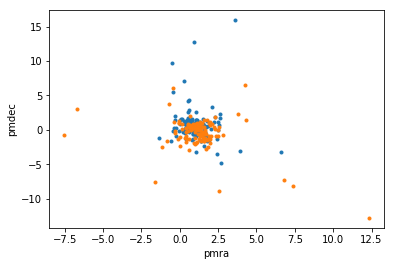

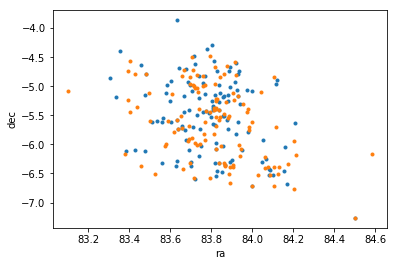

In [24]:
plt.plot(confEnhance['pmra1'][bothConf], confEnhance['pmdec1'][bothConf], '.')
plt.plot(confEnhance['pmra2'][bothConf], confEnhance['pmdec2'][bothConf], '.')
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.show()

plt.plot(confEnhance['ra1'][bothConf], confEnhance['dec1'][bothConf], '.')
plt.plot(confEnhance['ra2'][bothConf], confEnhance['dec2'][bothConf], '.')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()
#These are all the ones that are confirmed in the cluster

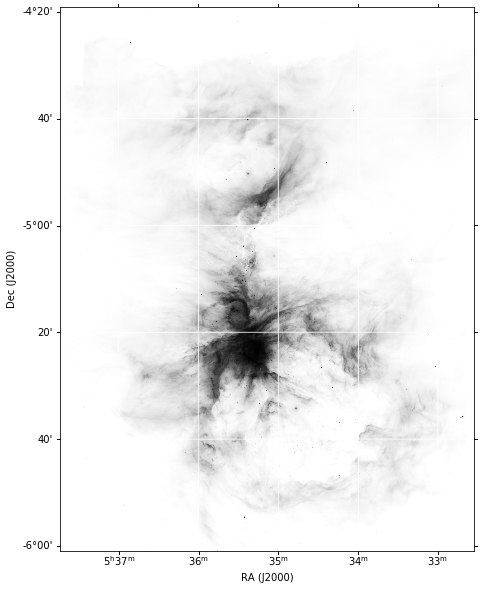

In [51]:
filename = 'C:\\users\\sahal\\2018TrinaryWork\\TrinaryStarSearch\\Data\\ch4_merged_clean.fits'#get_pkg_data_filename('ch4_merged_clean.fits')

hdu = fits.open(filename)[0]
hdu.header['CTYPE1']='RA---TAN-SIP'
hdu.header['CTYPE2']='DEC--TAN-SIP'
wcs = WCS(hdu.header)

plt.figure(figsize=(10,10))
plt.subplot(projection=wcs)
plt.imshow(np.arctan(0.0001*(hdu.data-np.median(hdu.data))), origin='lower',cmap='binary',vmin=0)
plt.grid(color='white', ls='solid')
plt.xlabel('RA (J2000)')
plt.ylabel('Dec (J2000)')
plt.gca().set_ylim(1500,6500)



#plt.plot(confEnhance['ra1'][bothConf], confEnhance['dec1'][bothConf], '.', transform = .get_transform())
plt.plot(confEnhance['ra2'][bothConf], confEnhance['dec2'][bothConf], '.')
plt.show()

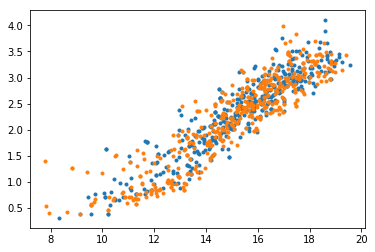

In [26]:
plt.plot(confEnhance['G1'], confEnhance['bprp1'], '.')
plt.plot(confEnhance['G2'], confEnhance['bprp2'], '.')
plt.show()

In [36]:
bi1 = confEnhance['isbin_1']
bi2 = confEnhance['isbin_2']

biIn1 = np.where(bi1 == 3)[0]
biIn2 = np.where(bi2 == 3)[0]
blist = np.concatenate((biIn1, biIn2))
blist

np.intersect1d(blist, bothConf)

array([127, 141, 146, 258, 382, 409, 415], dtype=int64)

From here I have a lot of work to do in comparing the proper motion of the relevant stars and seeing what happens. This should eventually get cleaned up

In [28]:
confEnhance[bothConf]

ra1,dec1,pmra1,pmdec1,projected_ra1,projected_dec1,parallax1,rVelocity1,G1,bprp1,ra_err1,dec_err1,pmra_err1,pmdec_err1,parralax_err1,rv_err1,ra2,dec2,pmra2,pmdec2,projected_ra2,projected_dec2,parallax2,rVelocity2,G2,bprp2,ra_err2,dec_err2,pmra_err2,pmdec_err2,parralax_err2,rv_err2,ref_pmra,ref_pmdec,time,ra_1,dec_1,rv_1,rve_1,isbin_1,Separation_1,ra_2,dec_2,rv_2,rve_2,isbin_2,Separation_1a,RA_1a,DEC_1a,apogee_1,grosschedl18_1,fang09_1,fang13_1,hsu12_1,hsu13_1,kounkel16_1,hasenberger16_1,pillitteri13_1,fang17_1,megeath12_1,kounkel17_1,rebull06_1,furesz08_1,getman05_1,hillenbrand97_1,dario10_1,dario12_1,kuhn14_1,getman14a_1,getman14b_1,sicilia-aguilar05_1,Separation_1b,RA_2a,DEC_2a,apogee_2,grosschedl18_2,fang09_2,fang13_2,hsu12_2,hsu13_2,kounkel16_2,hasenberger16_2,pillitteri13_2,fang17_2,megeath12_2,kounkel17_2,rebull06_2,furesz08_2,getman05_2,hillenbrand97_2,dario10_2,dario12_2,kuhn14_2,getman14a_2,getman14b_2,sicilia-aguilar05_2,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,int16,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64
83.48251170091393,-4.797265264995391,0.6447739881206371,0.946648818204142,83.4824400593597,-4.797370448197414,2.446124574615641,nan,16.8622,2.7225971,0.0975906924092268,0.09586025503680433,0.2411820526140304,0.1982581688380465,0.13176411603228833,nan,83.48253321864347,-4.797049560919736,-0.07499483289390126,1.3499021915126073,83.48254155140268,-4.7971995500521265,2.479931510507315,nan,16.948454,2.6344328,0.1091233109154024,0.10085048692611268,0.2713176242934988,0.2537414393881067,0.13401914755570907,nan,0.284889577613368,1.1482755048583748,-400,83.482506,-4.797142,28.9363,0.386201,-1,0.44422500761004136,83.482506,-4.797142,28.9363,0.386201,-1,0.34681019841963845,83.48250579833984,-4.797142028808594,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,0.44415530804199466,83.48250579833984,-4.797142028808594,True,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,0.3471140324808718
84.50349454157684,-7.264919768031094,-0.010701943245293588,1.3953914020712481,84.50349959527226,-7.26557870285985,3.152727556491071,nan,15.249276,2.1309347,0.09954479511210143,0.0933556609361285,0.24836261730137532,0.20048602022075482,0.13085510796305624,nan,84.50335136108642,-7.265221329201588,0.11152819090463771,0.8443734708342436,84.50329869499626,-7.265620061118371,2.6833273594620985,nan,15.752002,2.3069115,0.08932226618754684,0.08195359697557524,0.19207466954507768,0.16359151484472476,0.10607502368011383,nan,0.050413123829672064,1.119882436452746,-1700,84.503448,-7.2650442,23.5248,0.120057,0,0.47779464343022504,84.503448,-7.2650442,23.5248,0.120057,0,0.7250625183653897,84.50344848632812,-7.265044212341309,True,True,False,True,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,0.4772349945916211,84.50344848632812,-7.265044212341309,True,True,False,True,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,0.7258517235133175
83.80750024239218,-5.368619012600222,-0.044086781065910796,-0.22665684699832978,83.80755167697009,-5.368354579612057,2.461681498288419,nan,13.37713,1.2119122,0.034127890470838584,0.03632241624749289

### Things to do:
- Get intrinsic motion
- ID any high velocity stars from Kim18
- Compare orientation of vectors
- Compare the radial separation between them
- Check if entries are binaries
- Add image
- Clean up fits tables

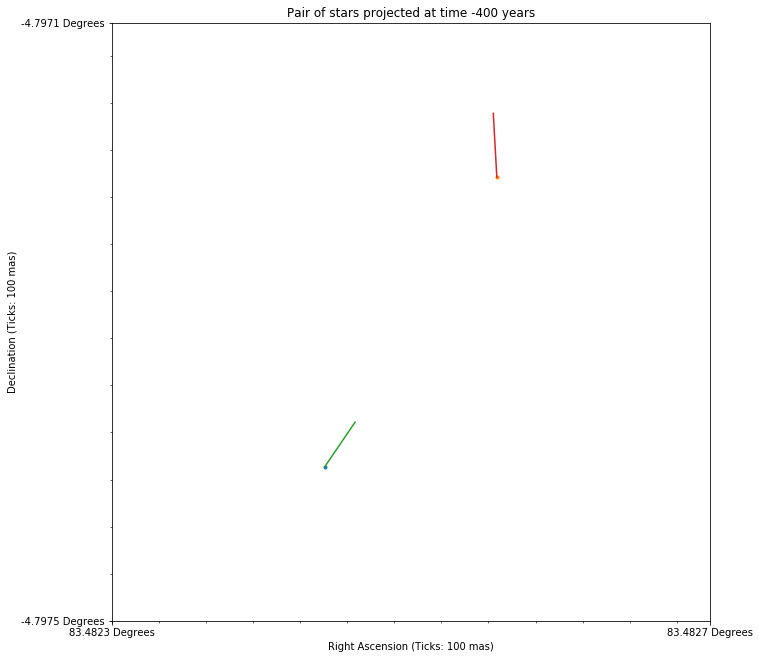

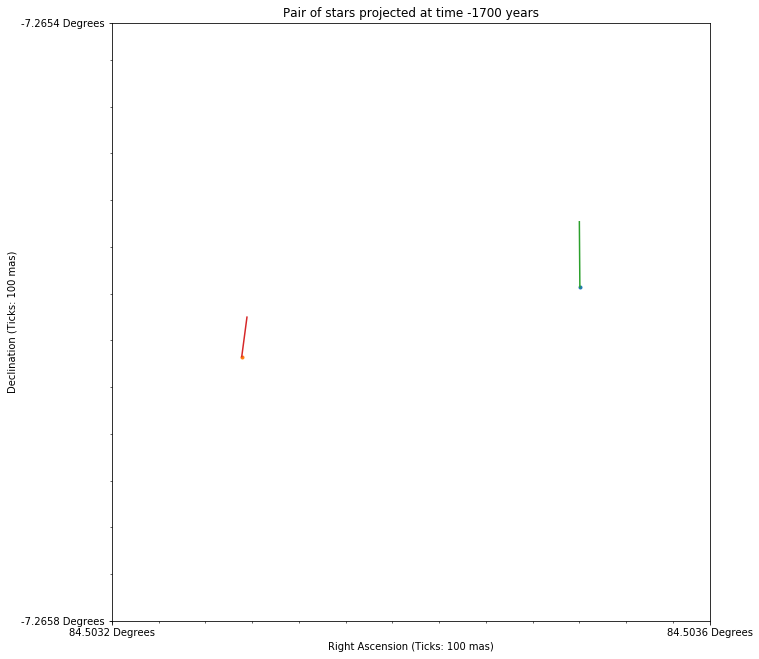

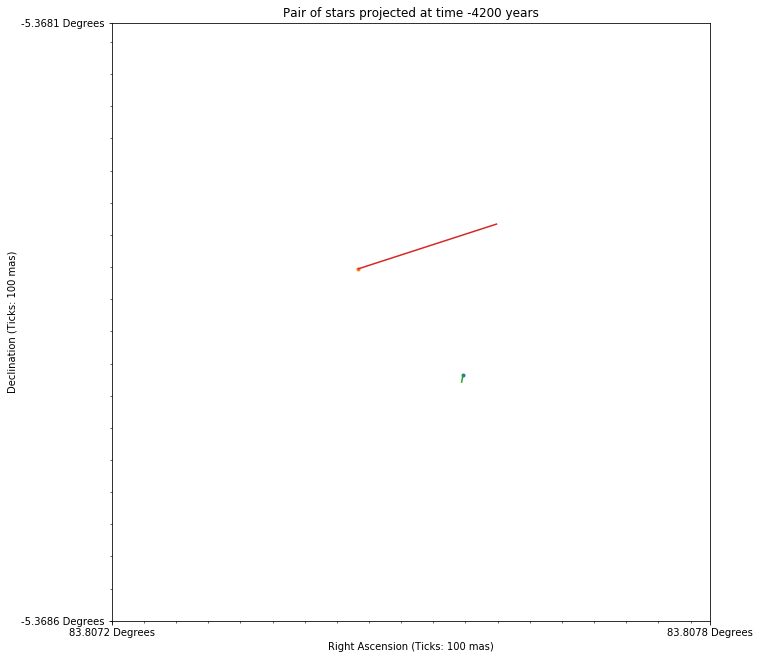

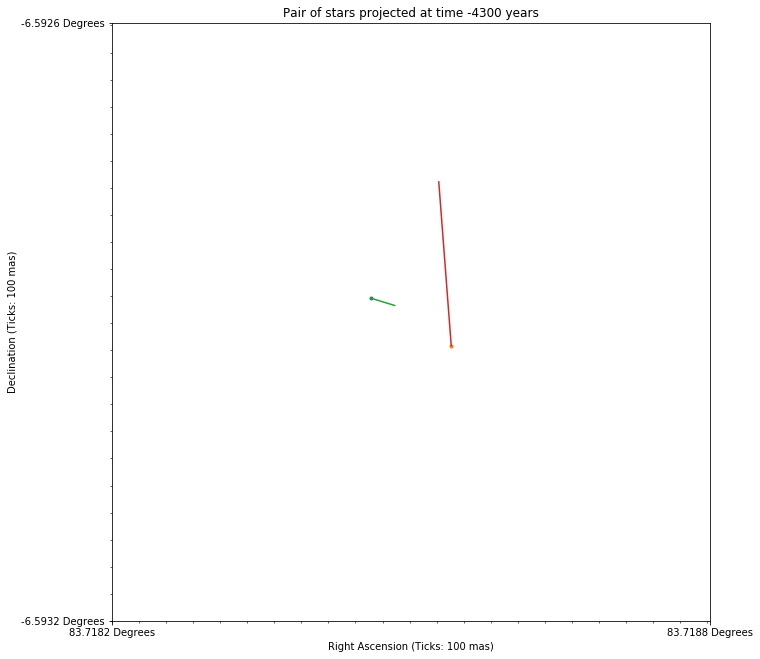

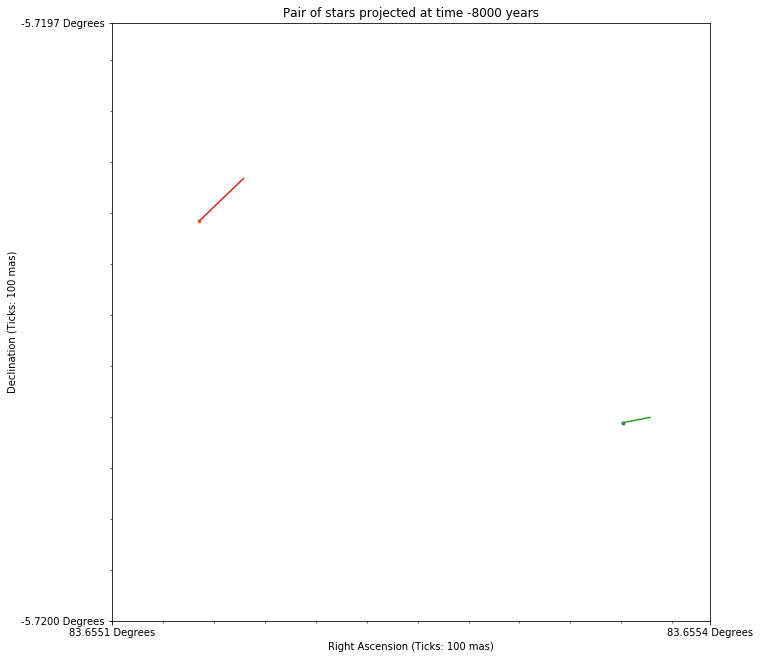

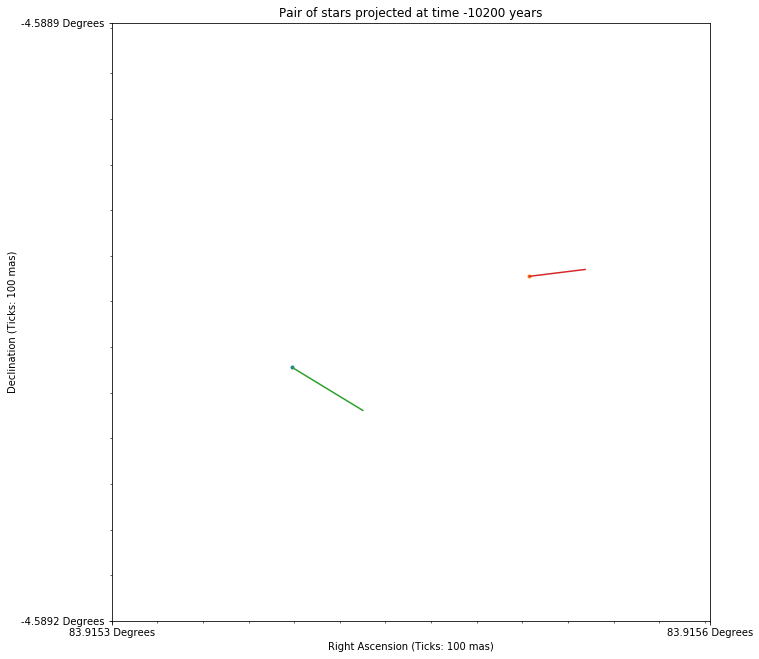

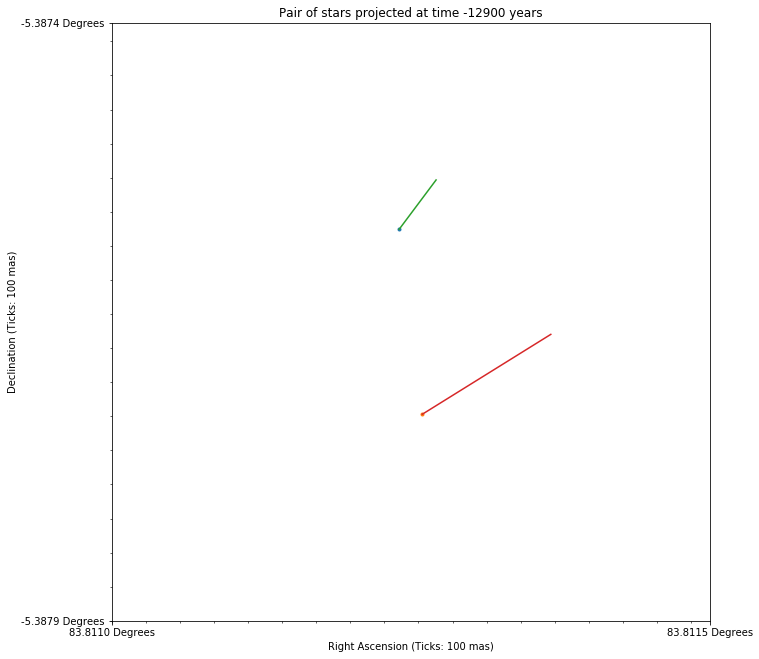

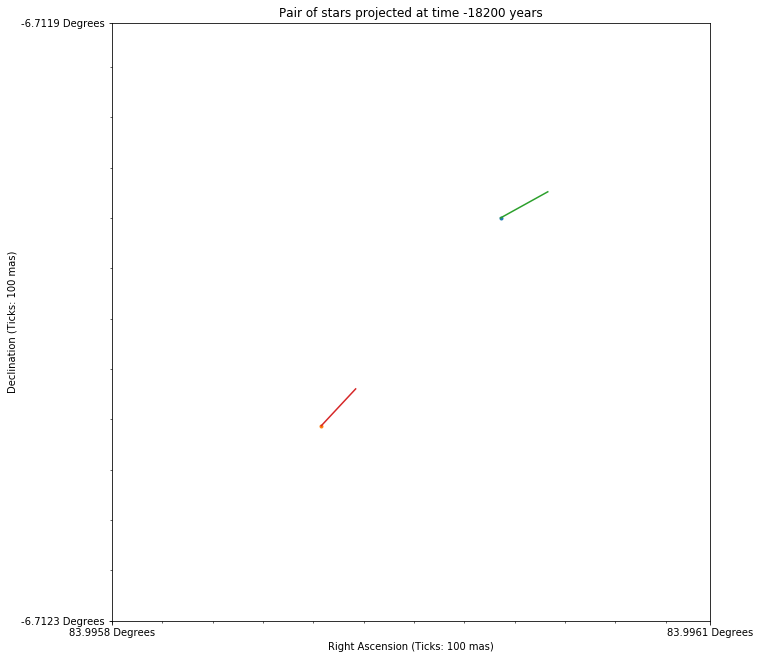

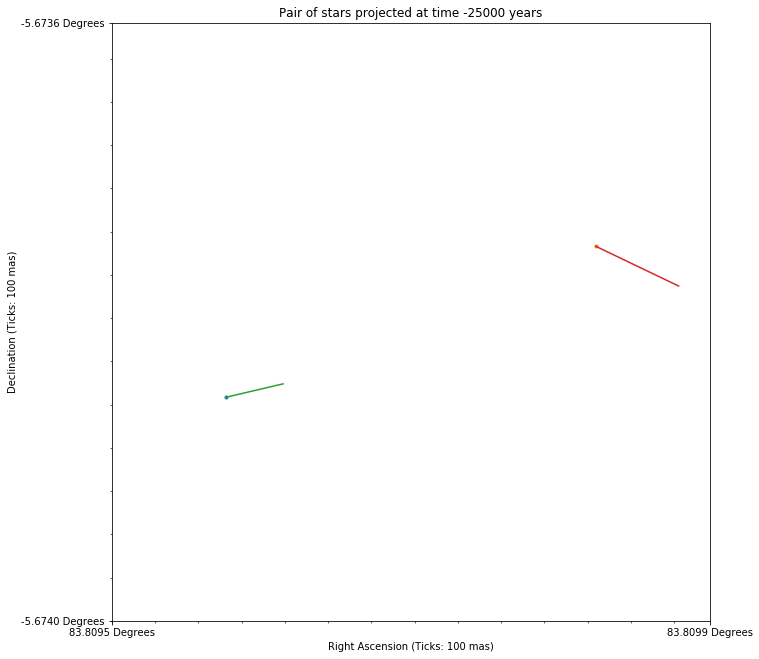

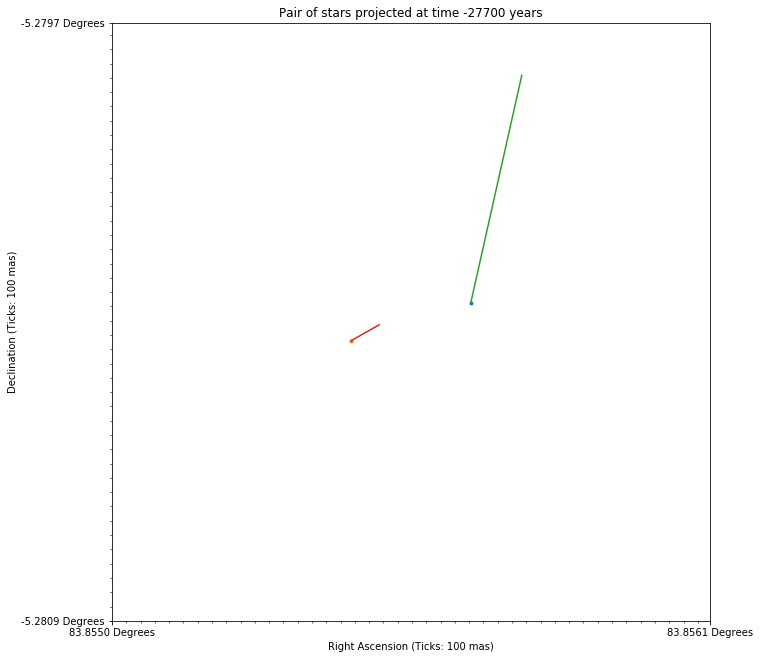

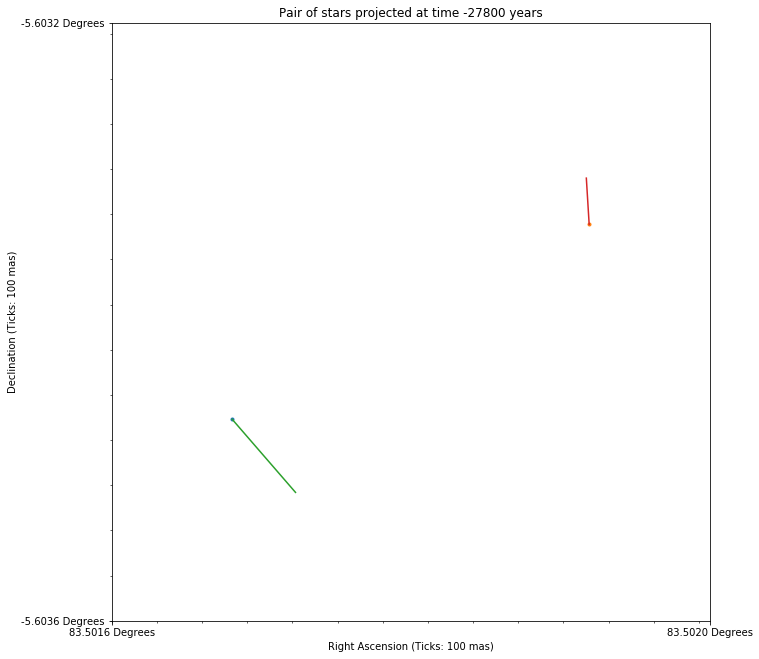

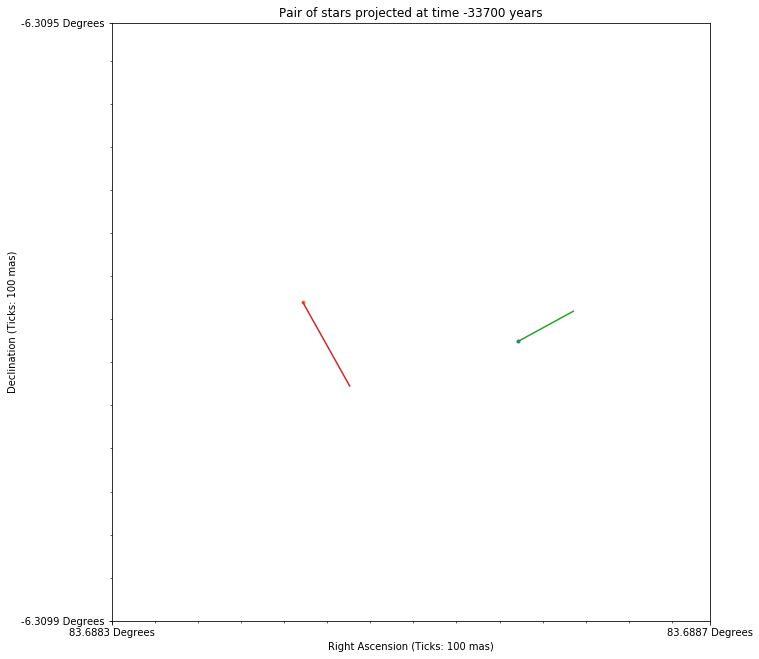

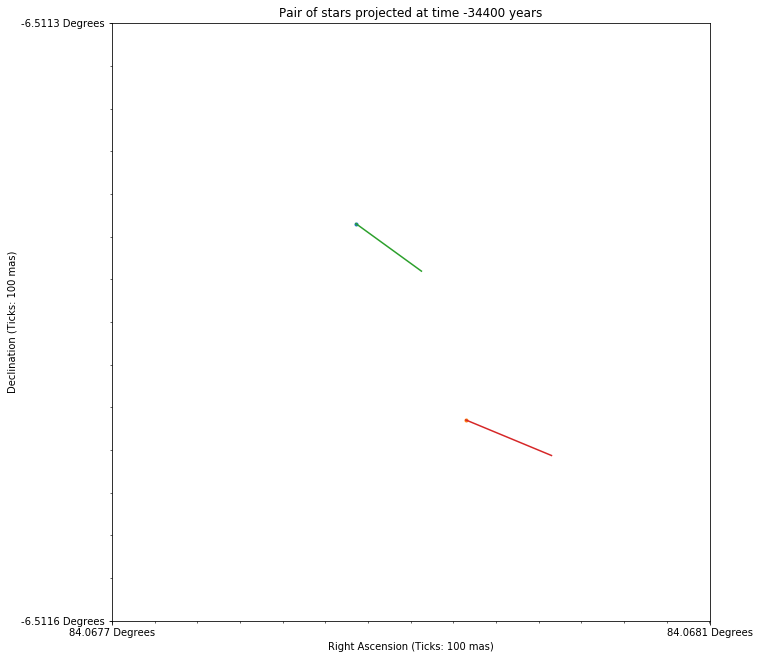

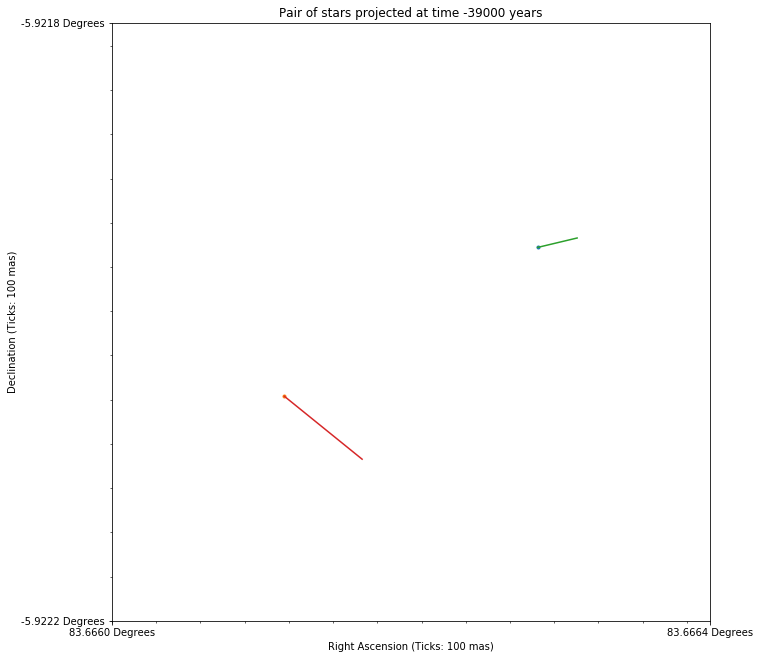

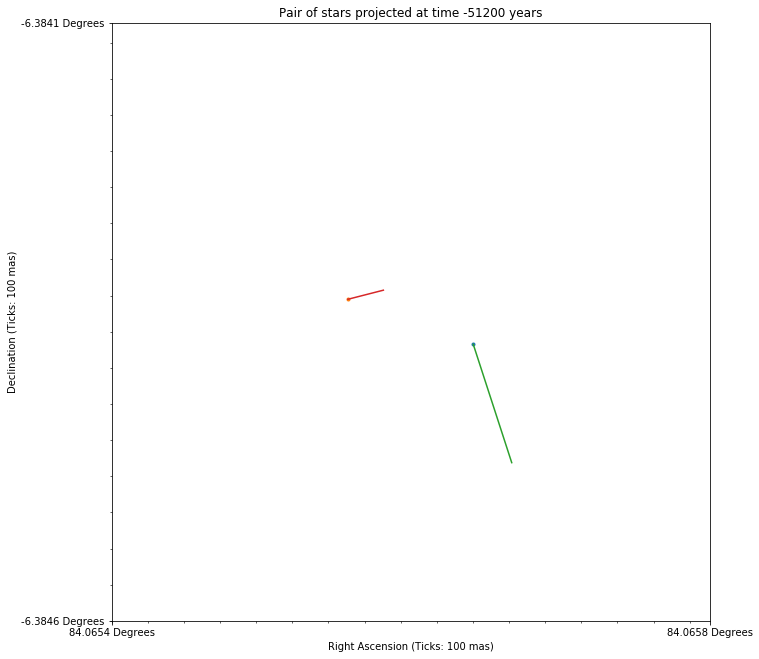

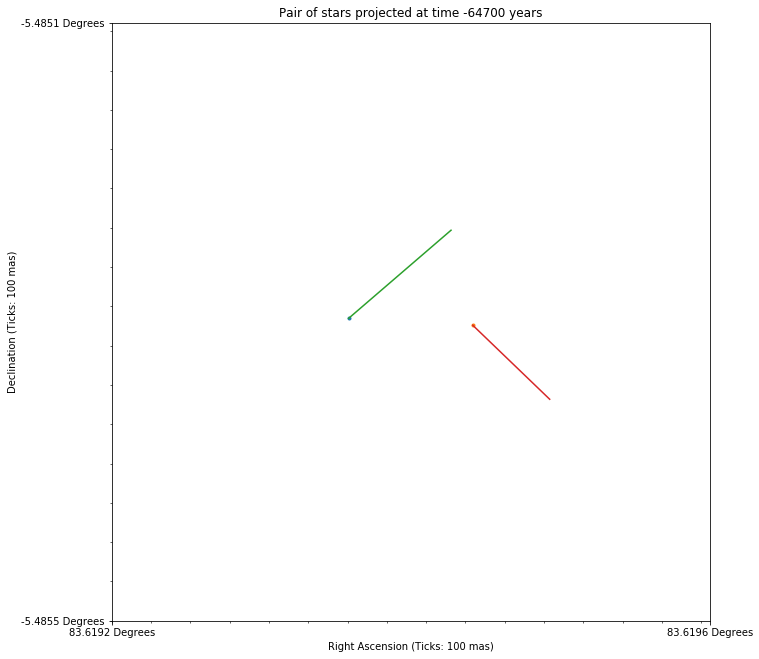

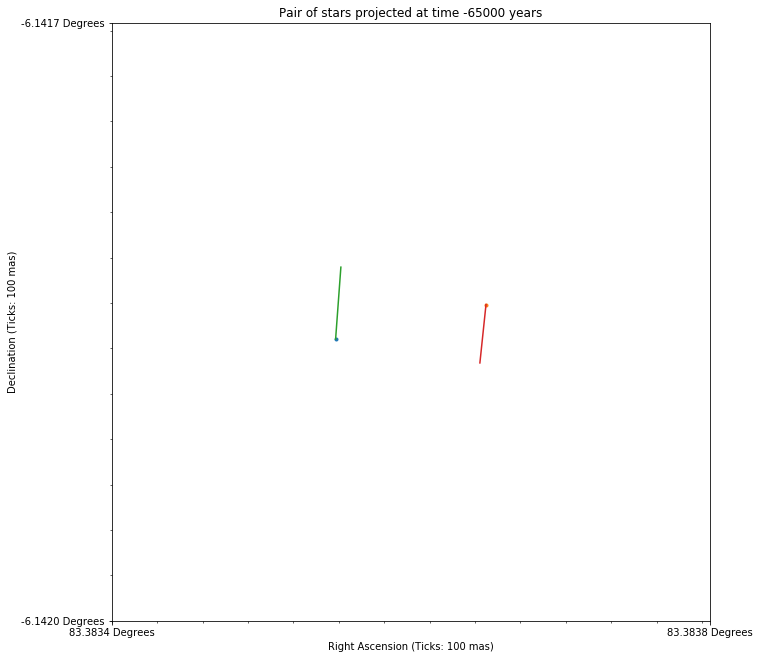

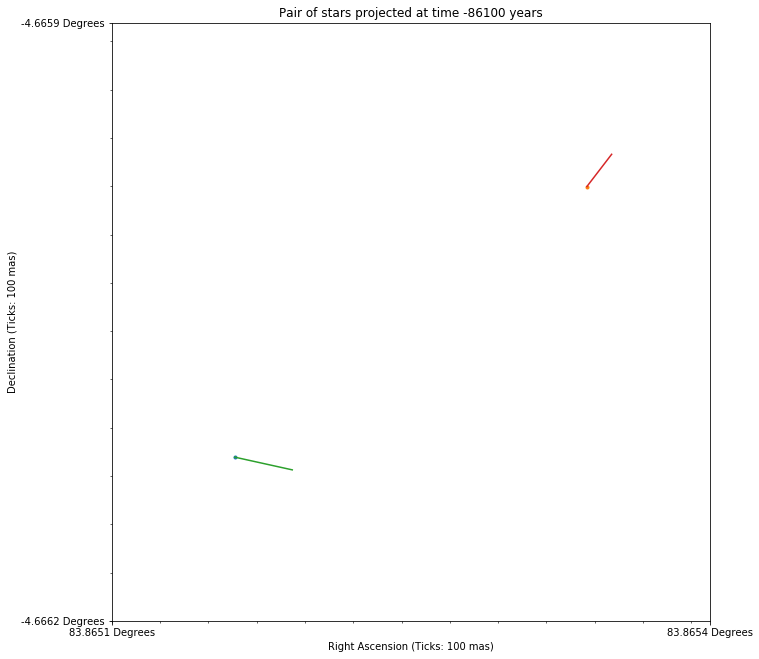

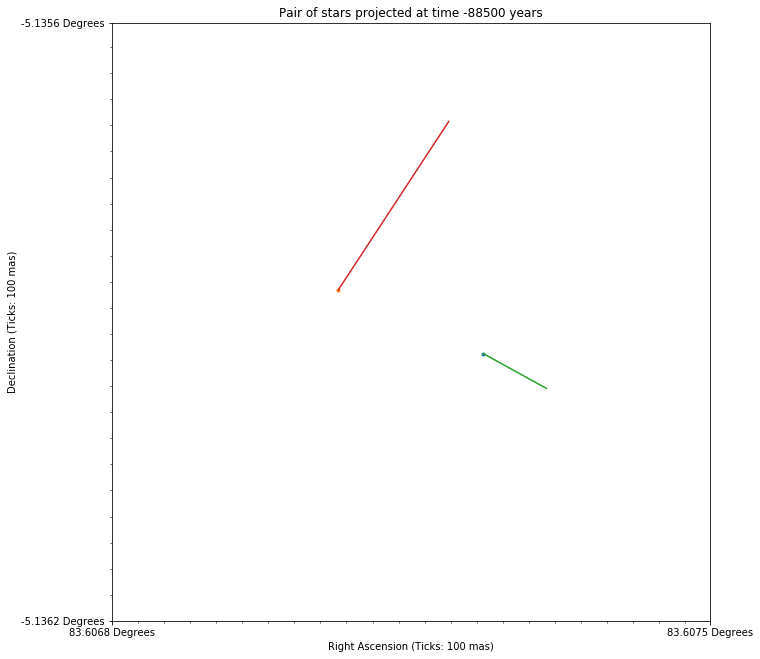

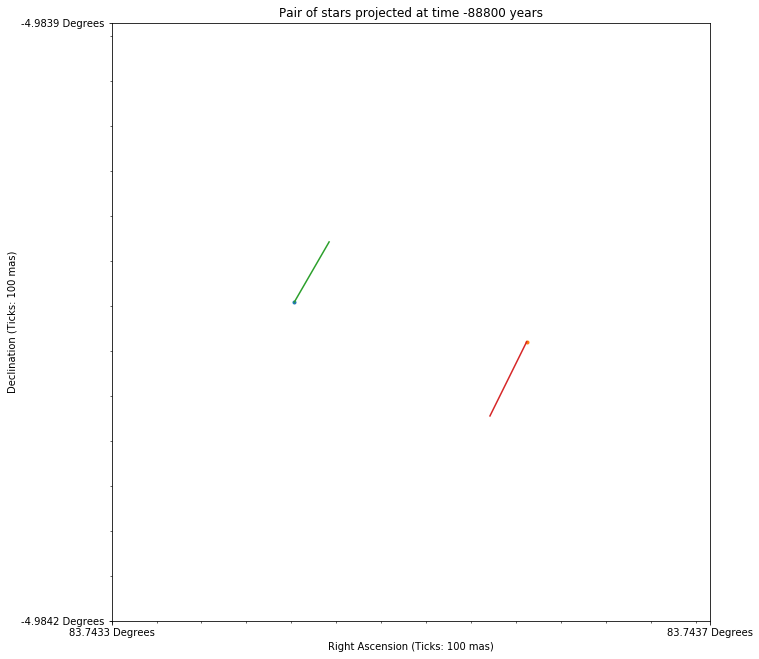

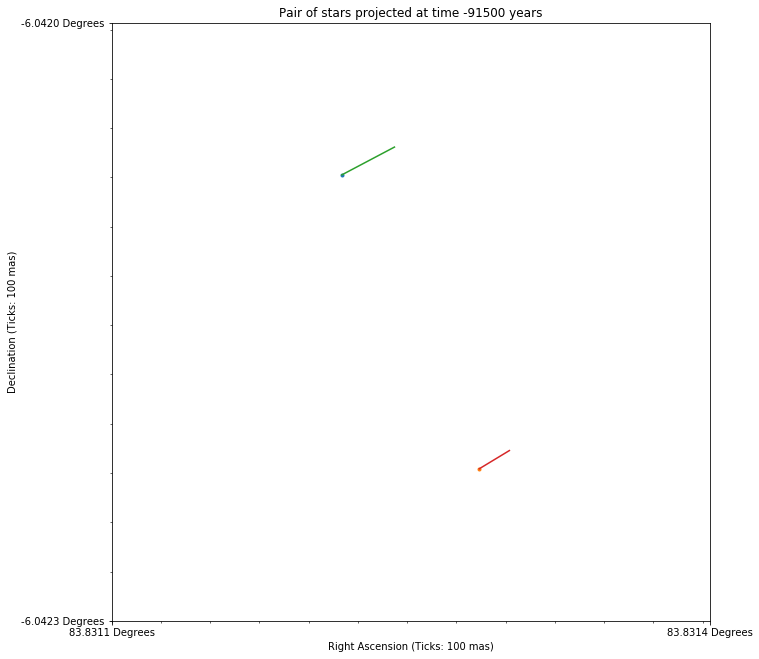

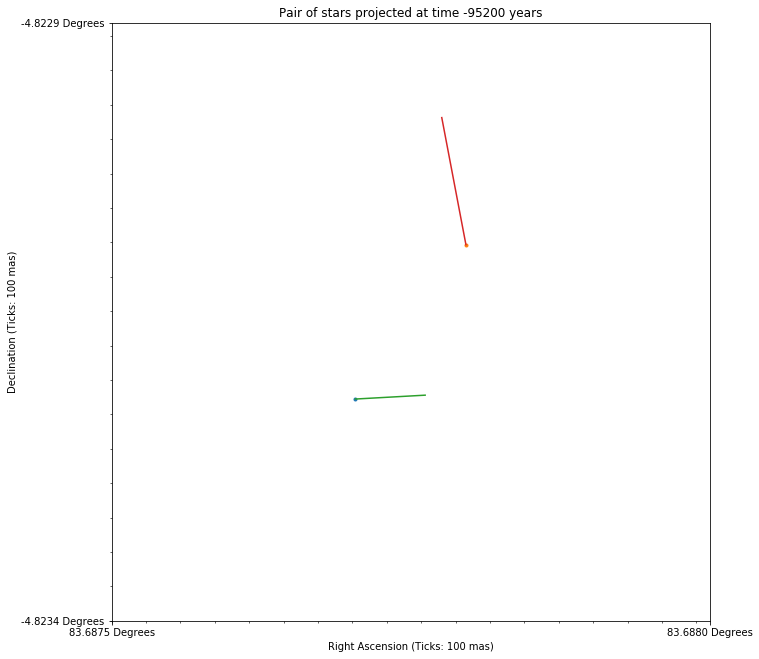

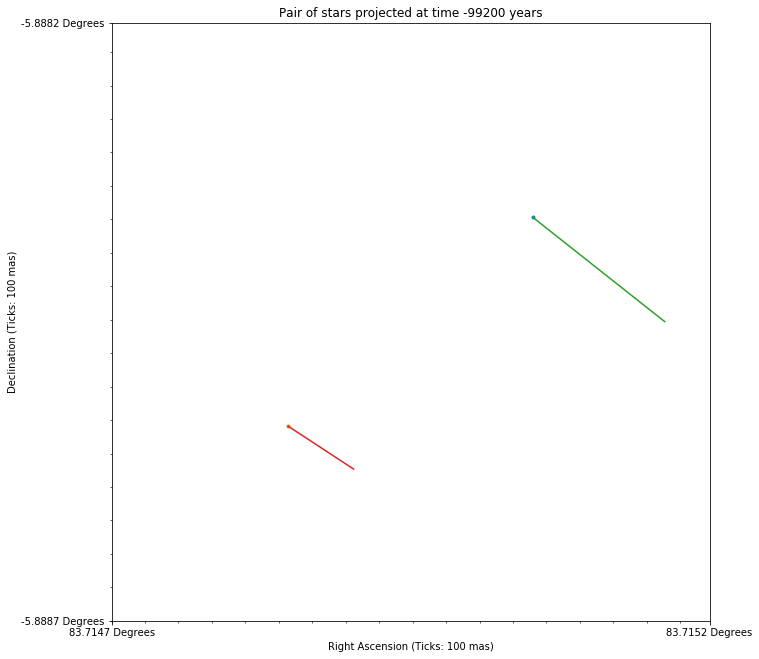

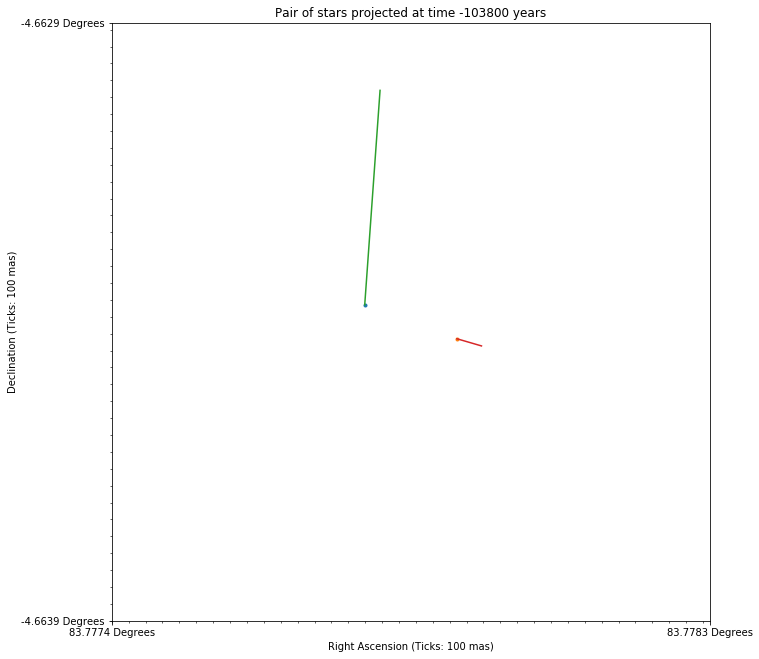

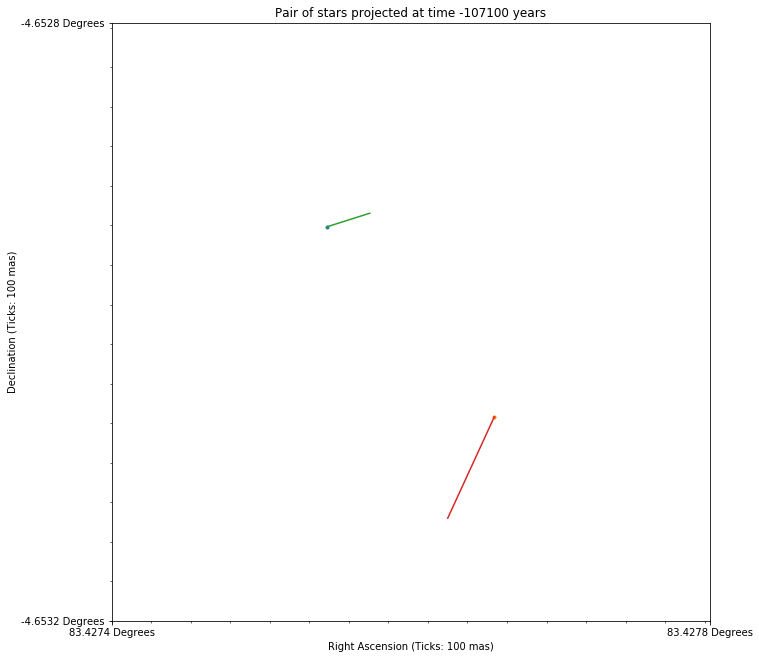

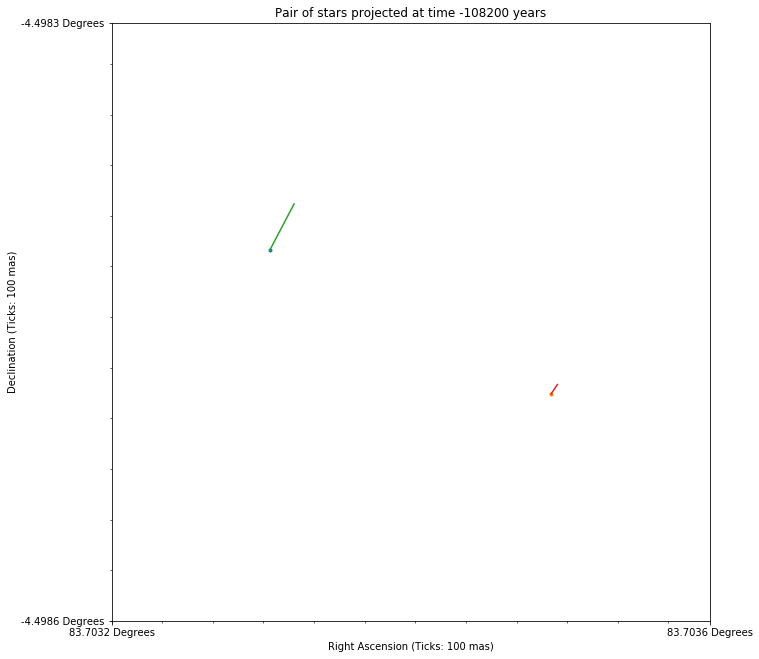

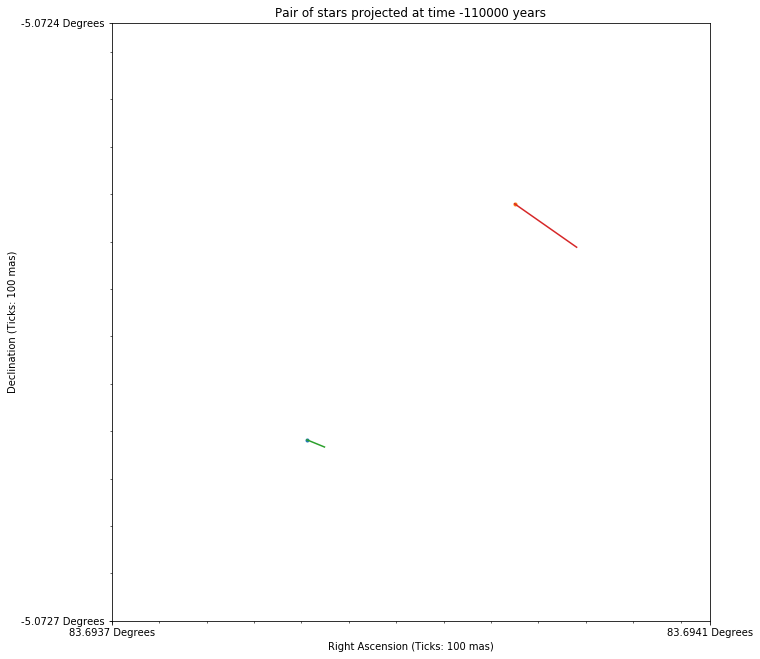

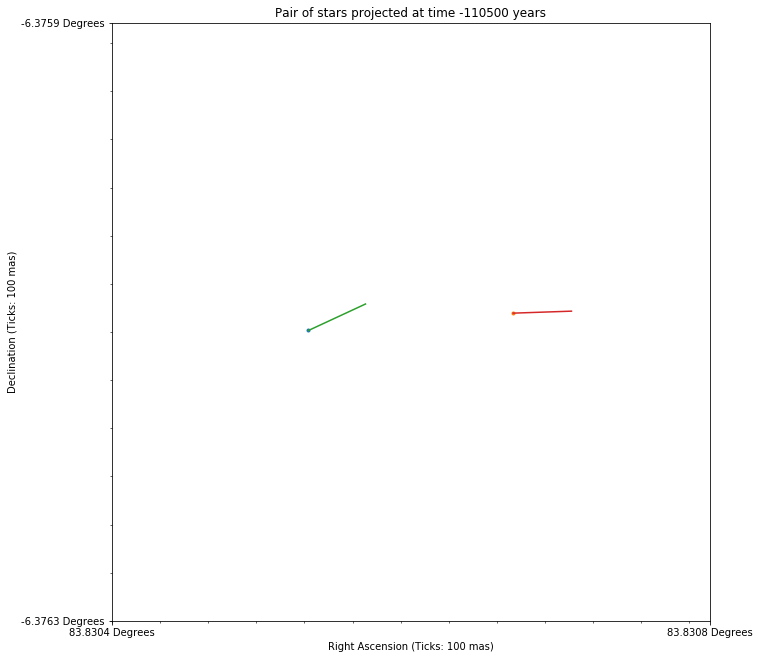

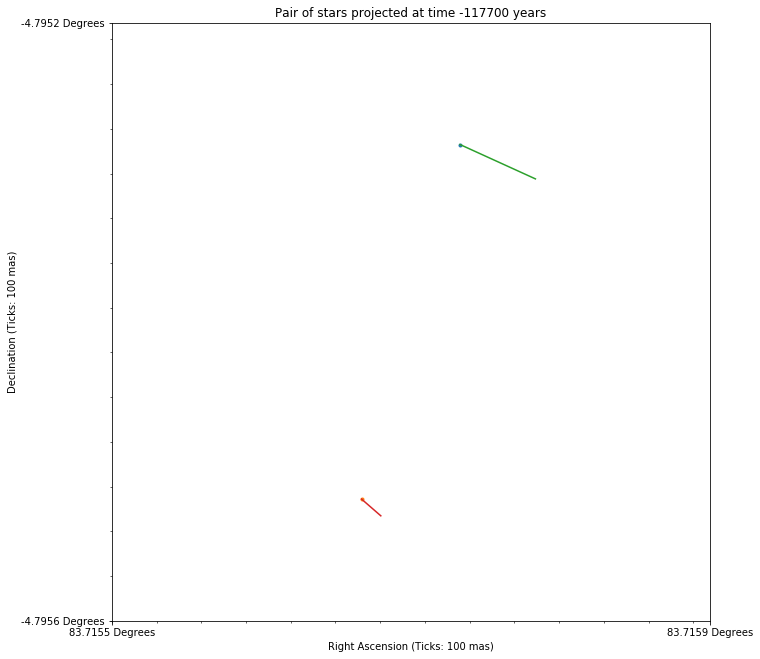

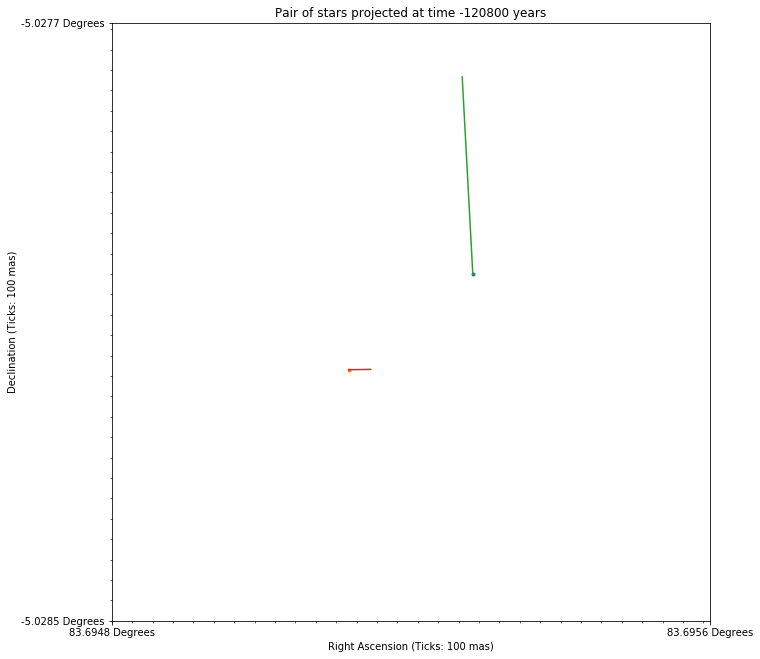

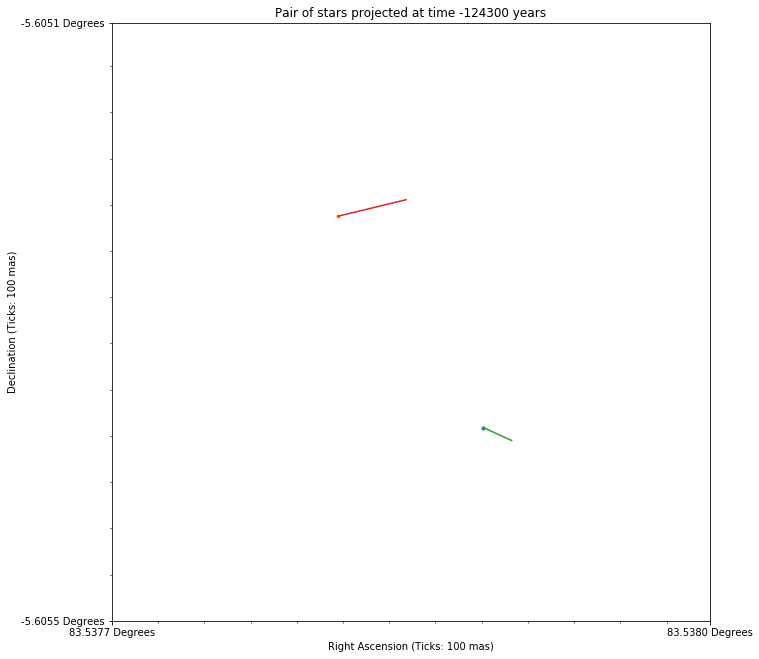

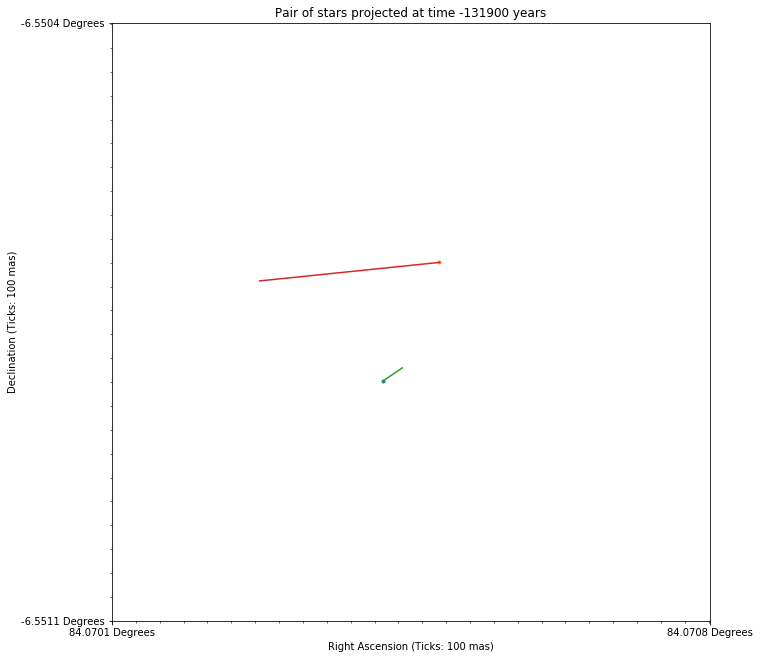

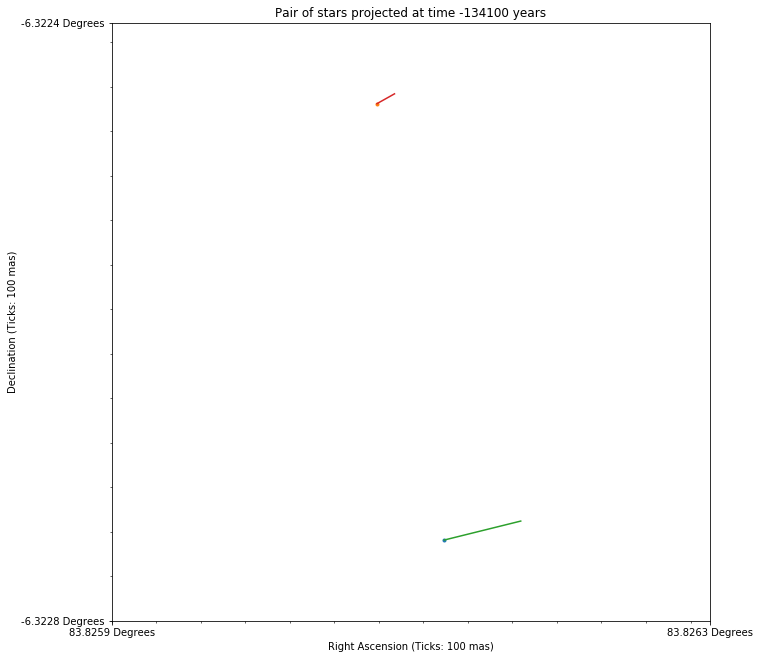

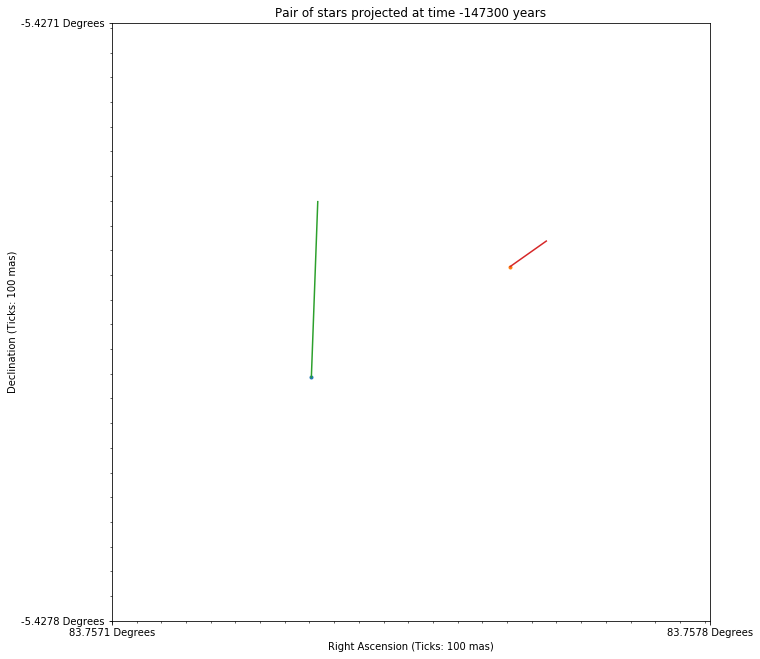

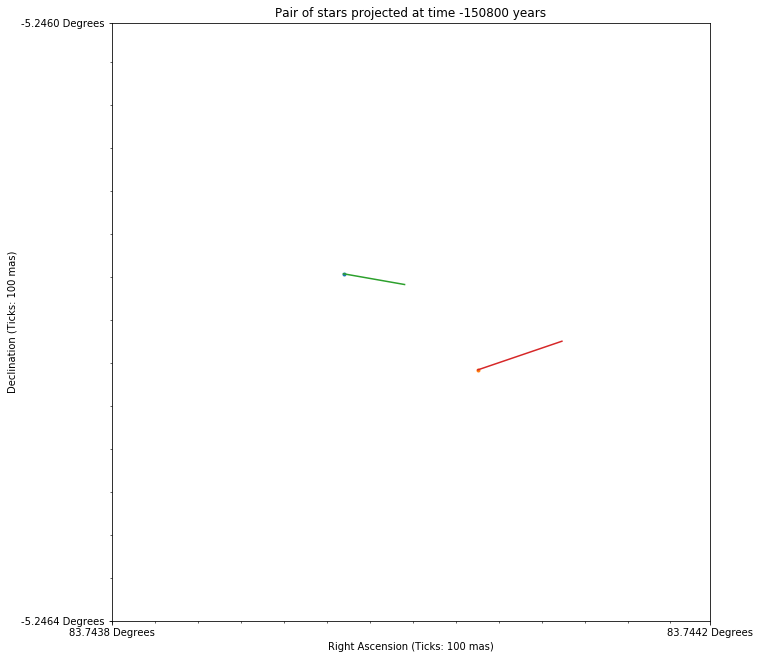

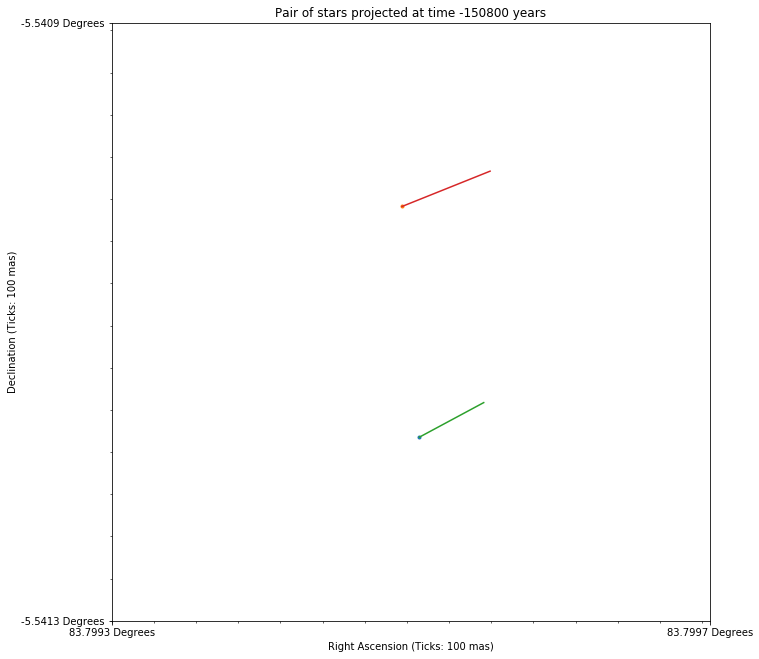

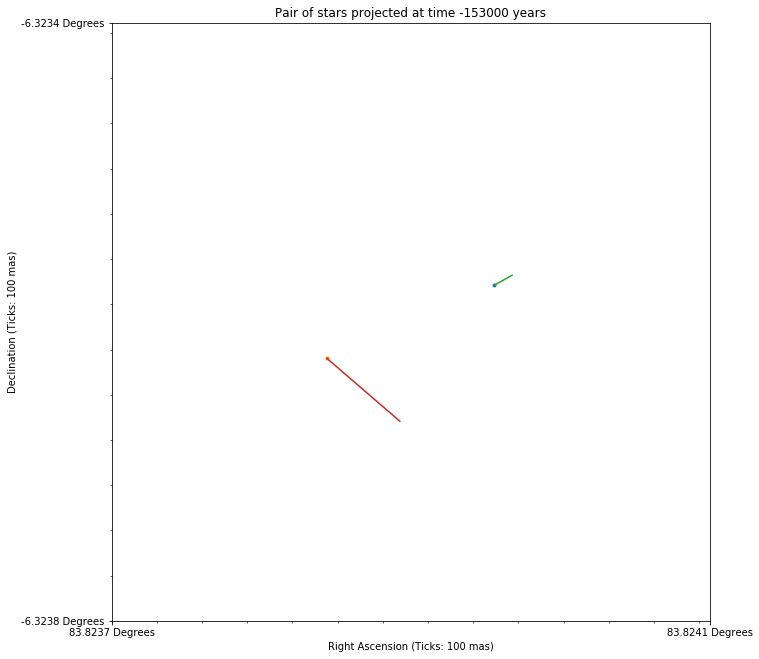

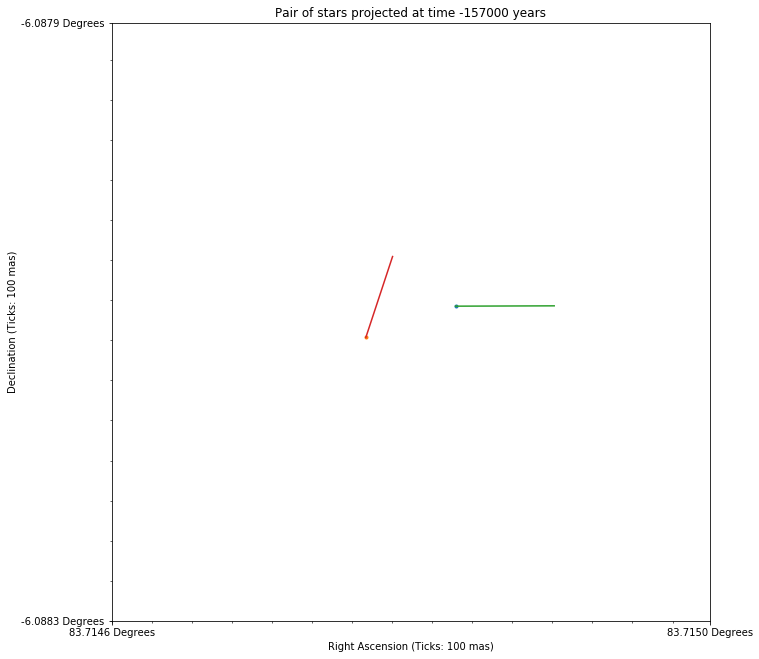

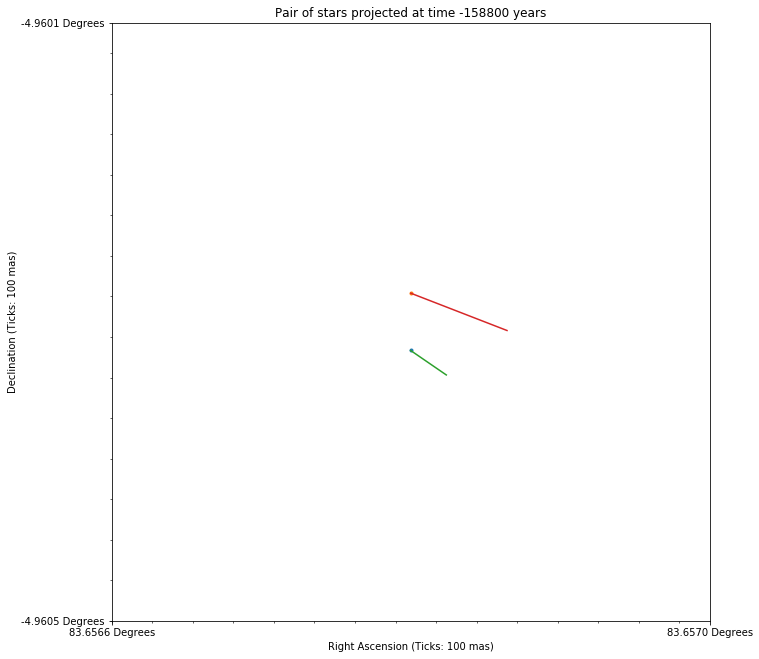

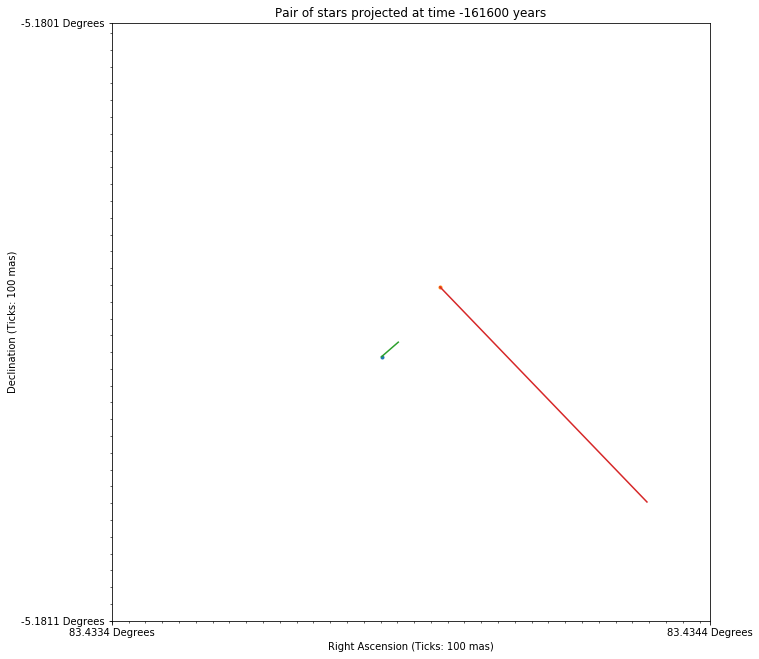

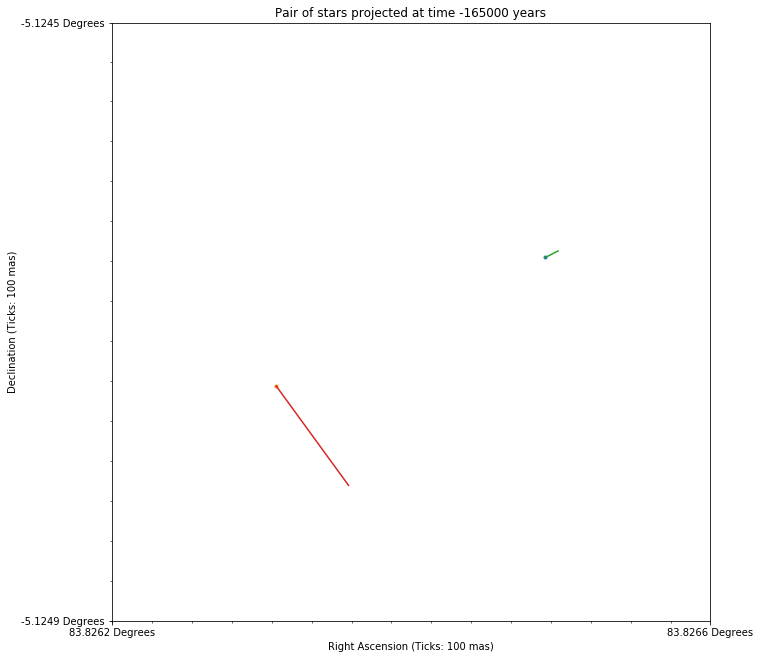

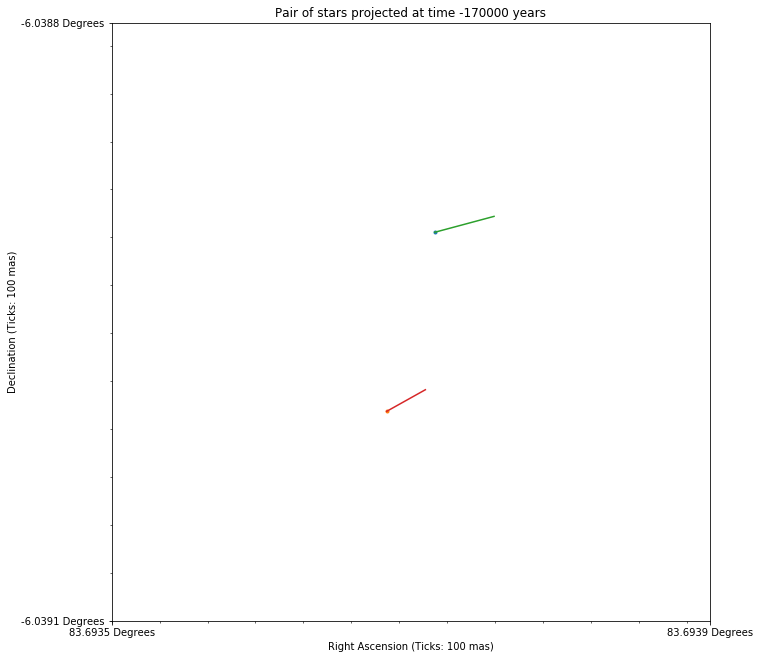

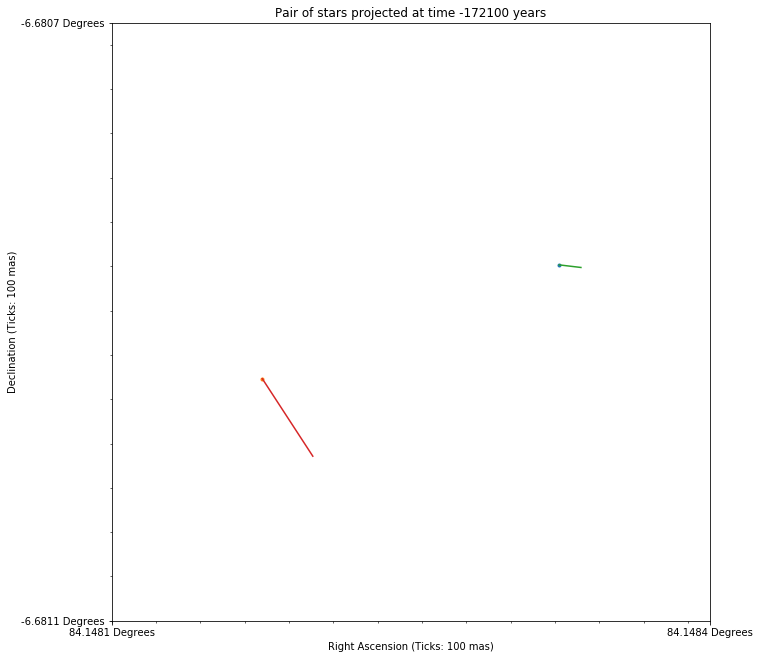

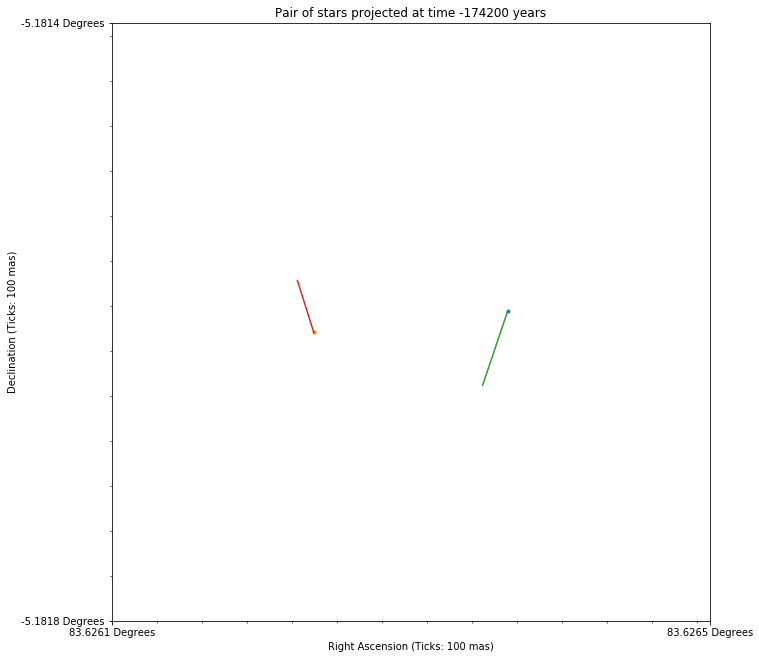

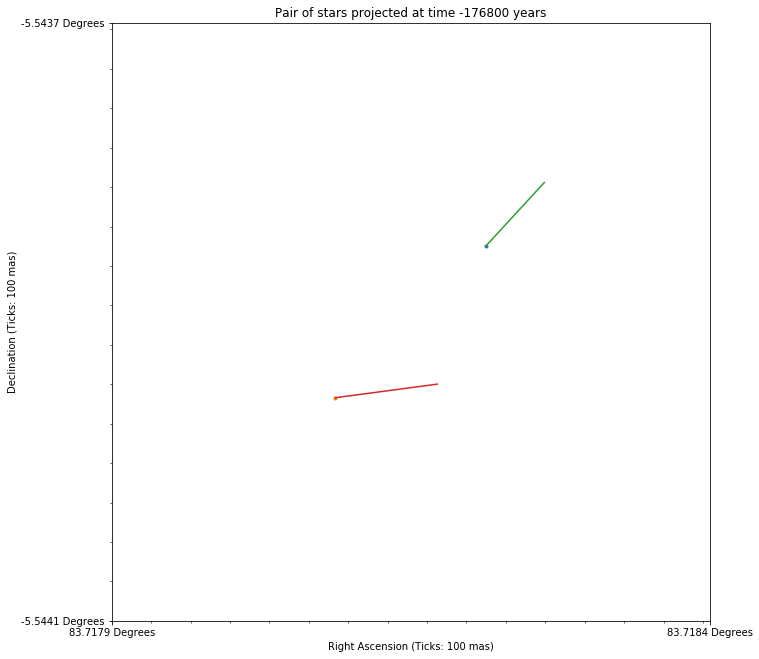

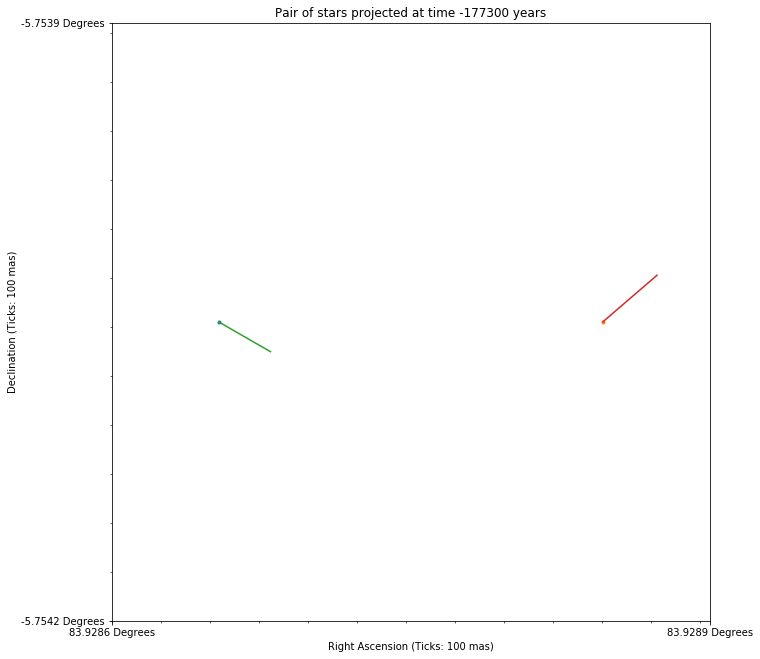

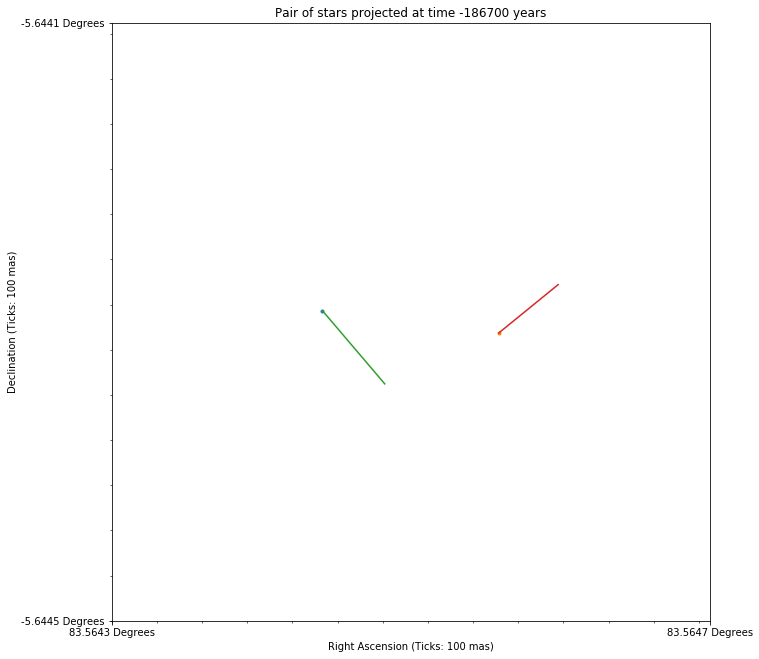

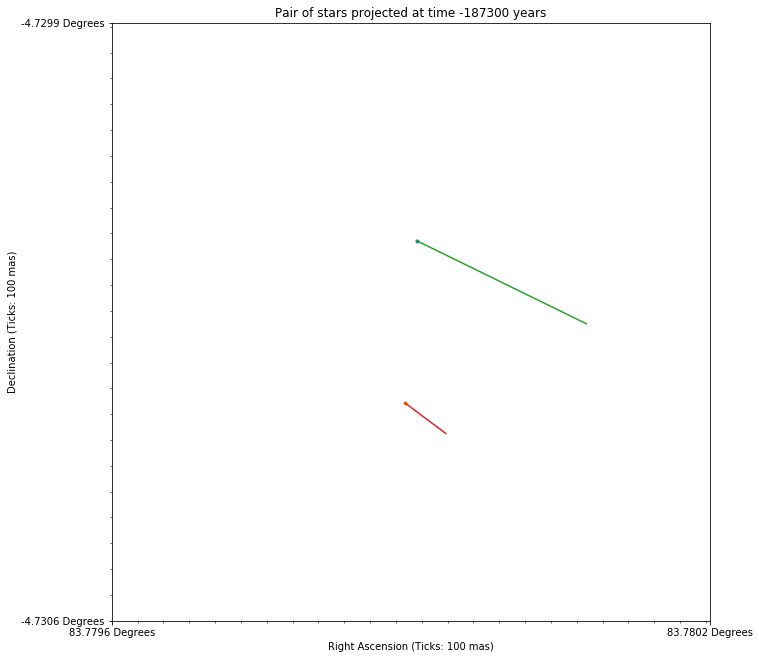

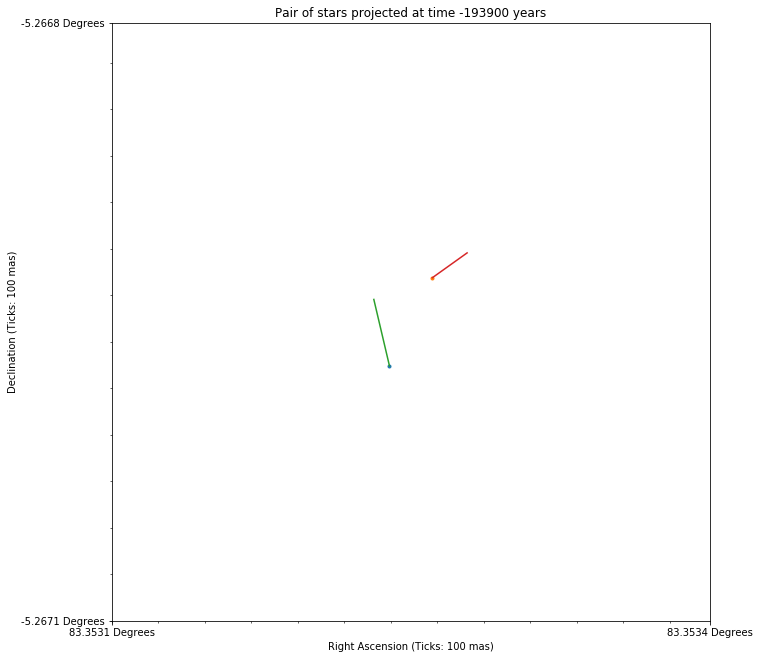

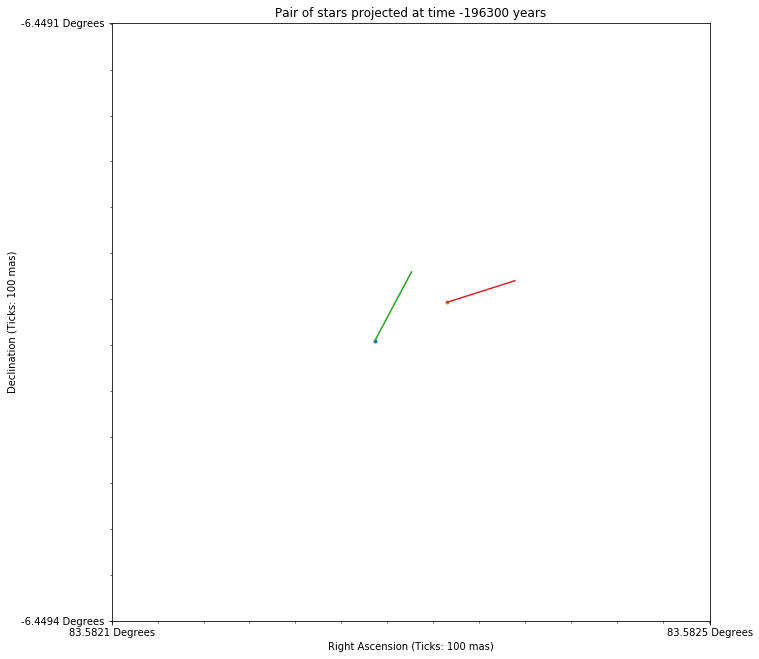

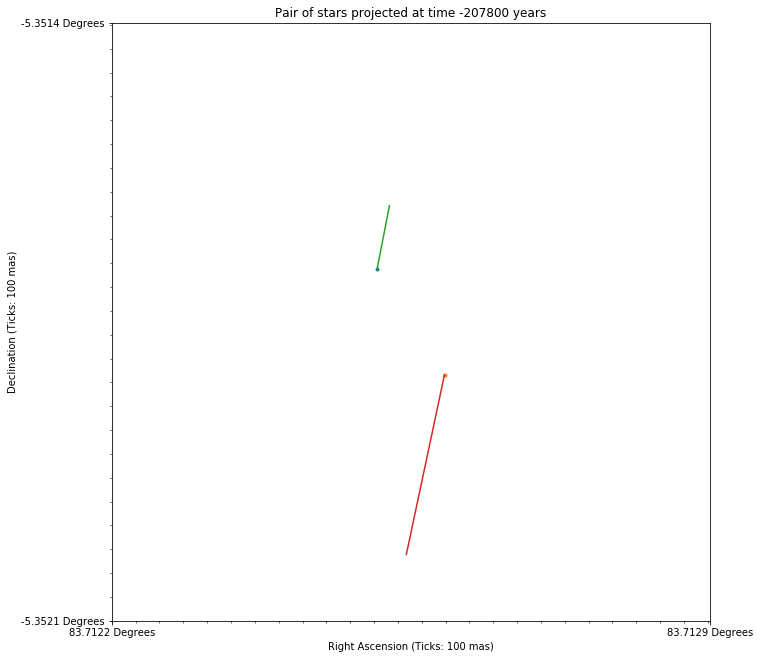

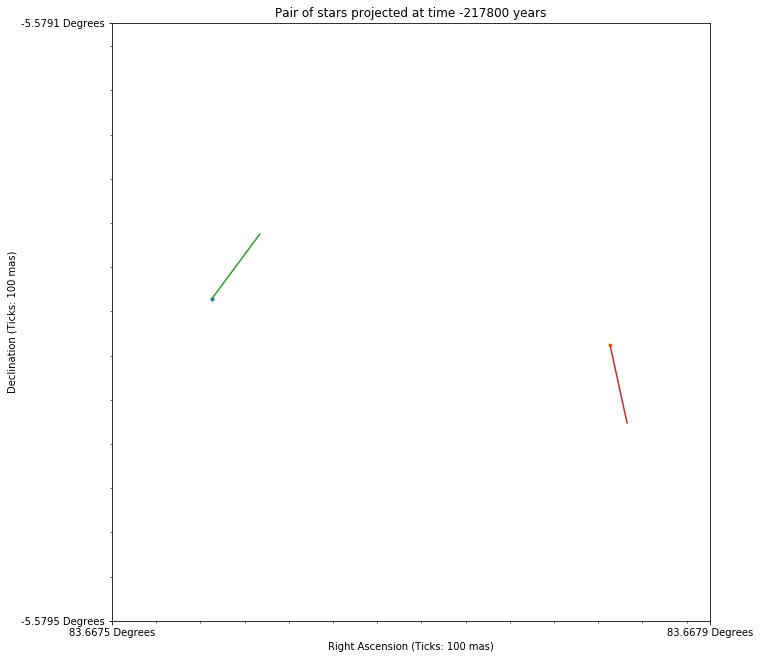

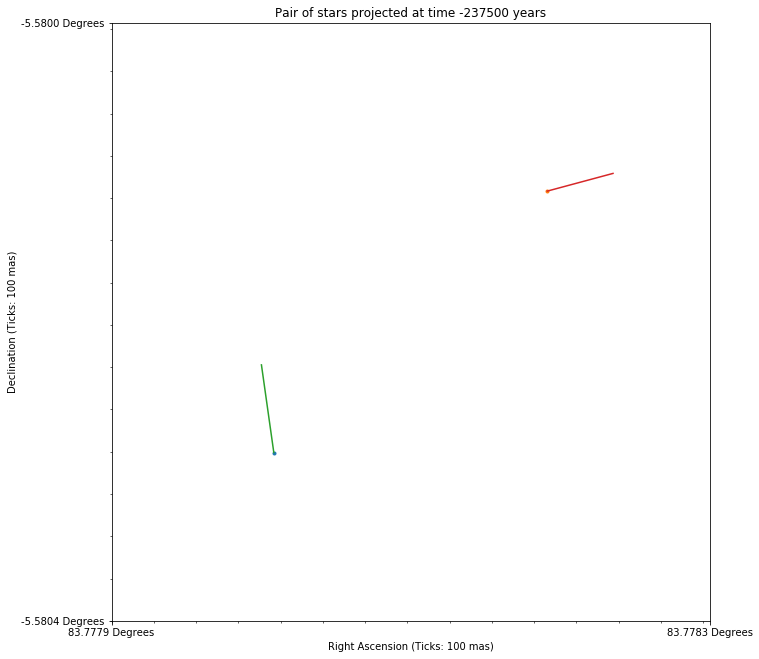

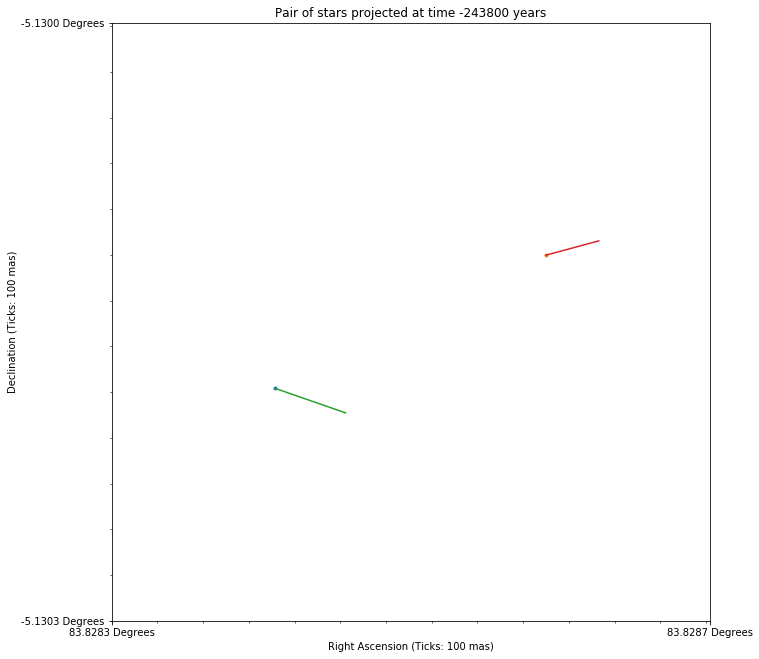

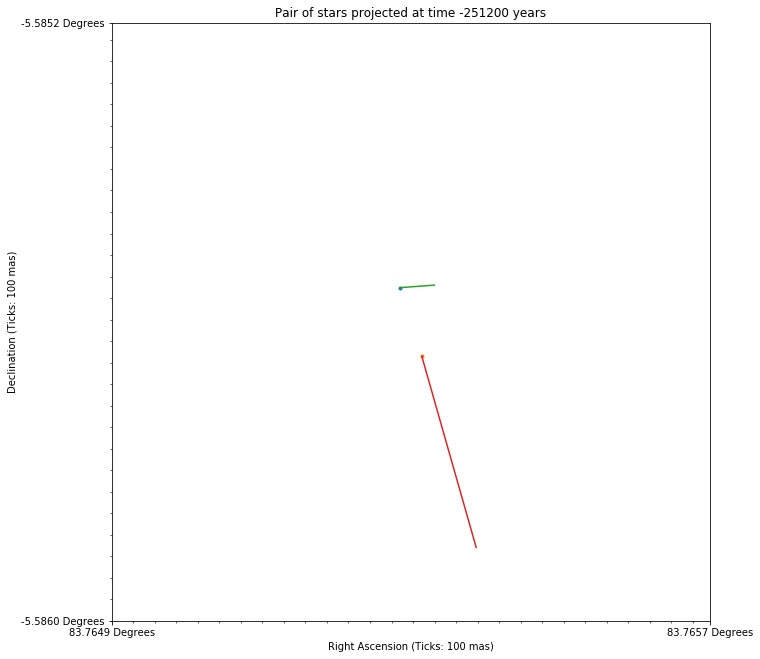

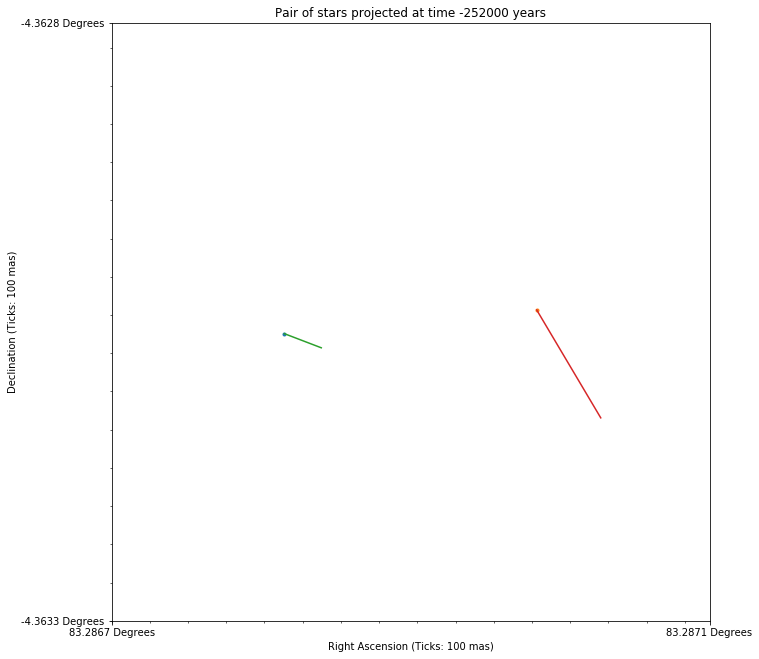

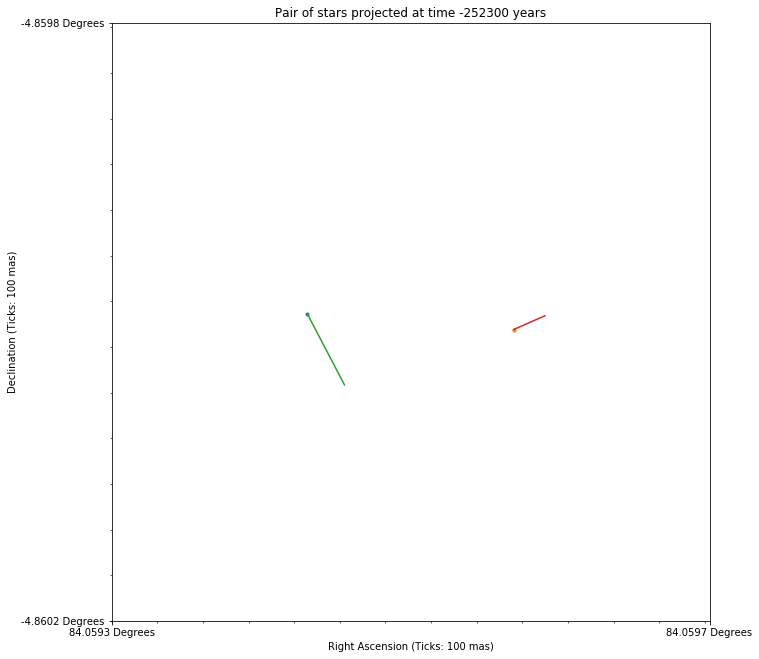

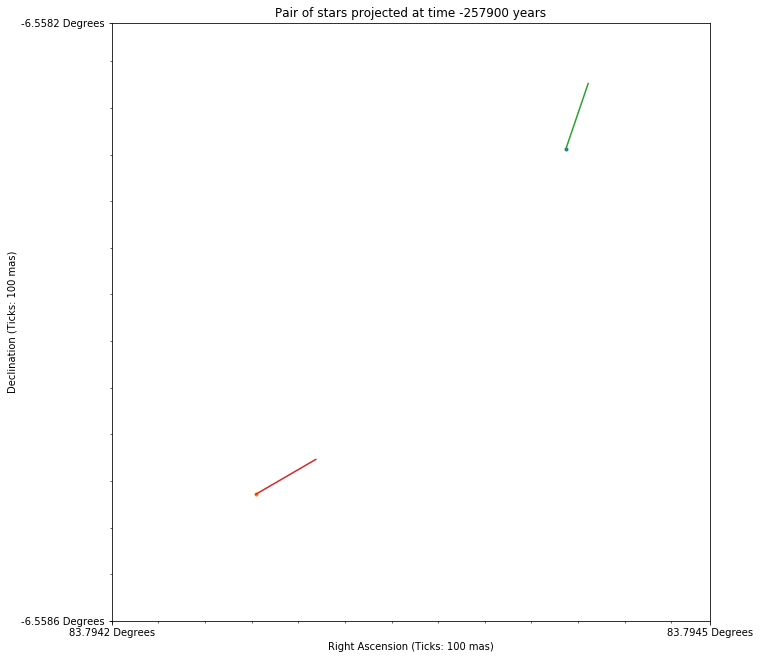

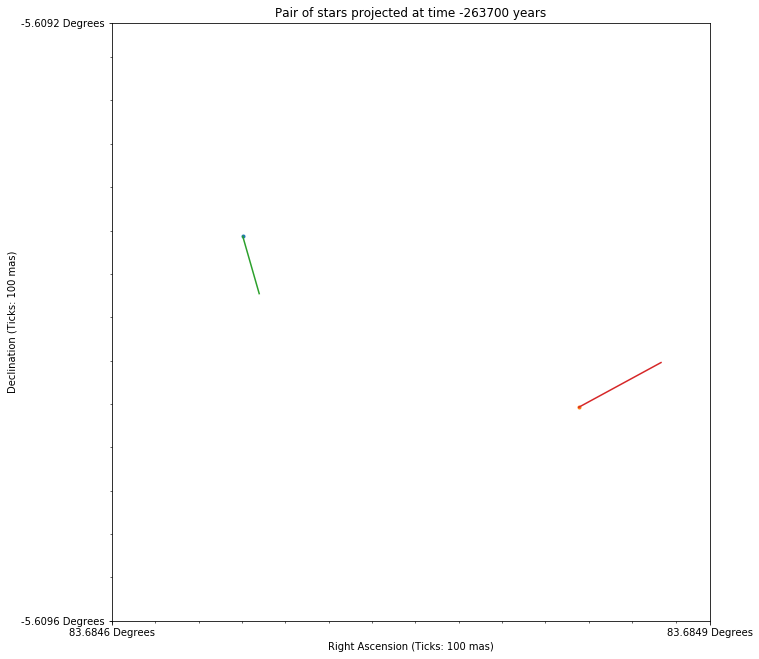

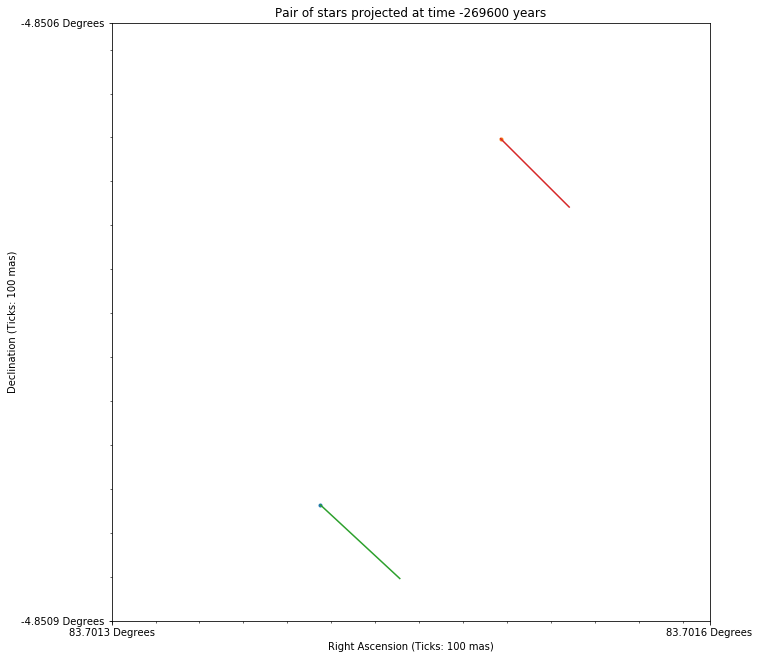

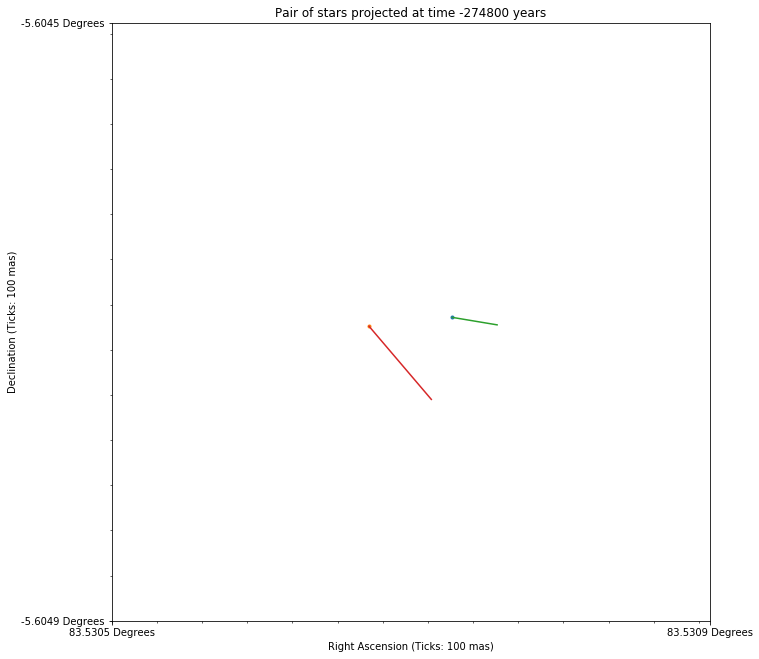

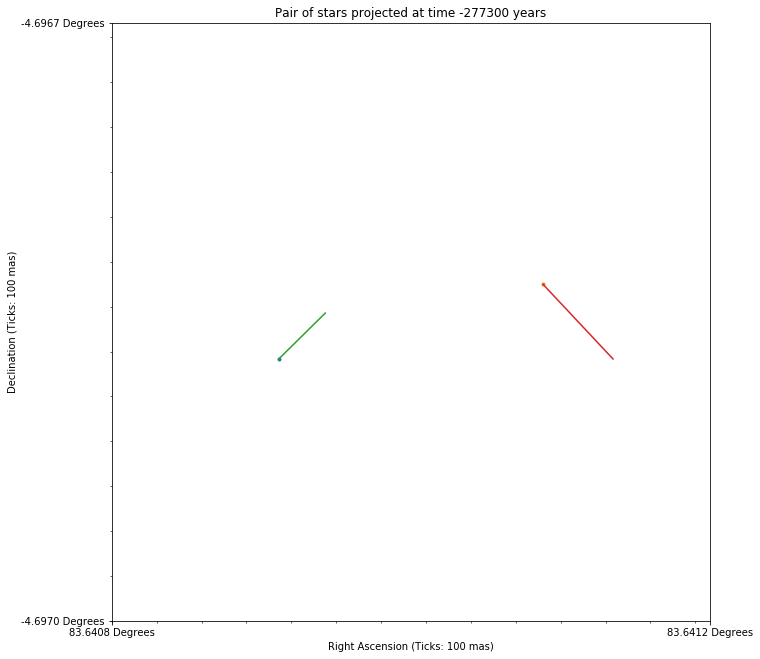

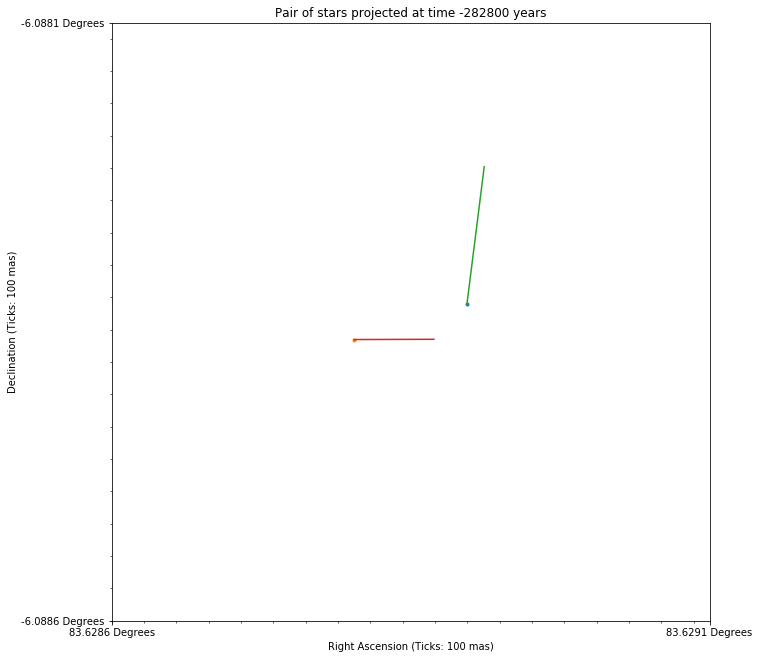

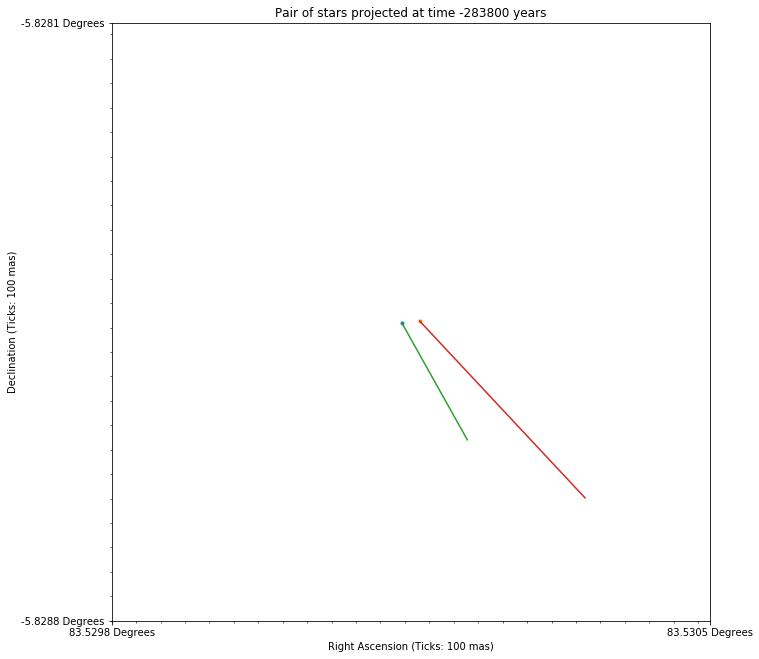

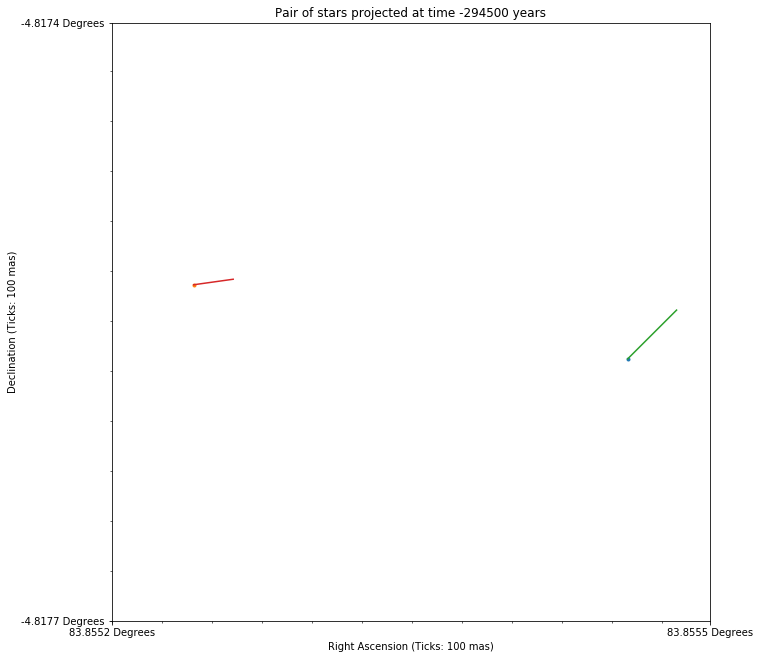

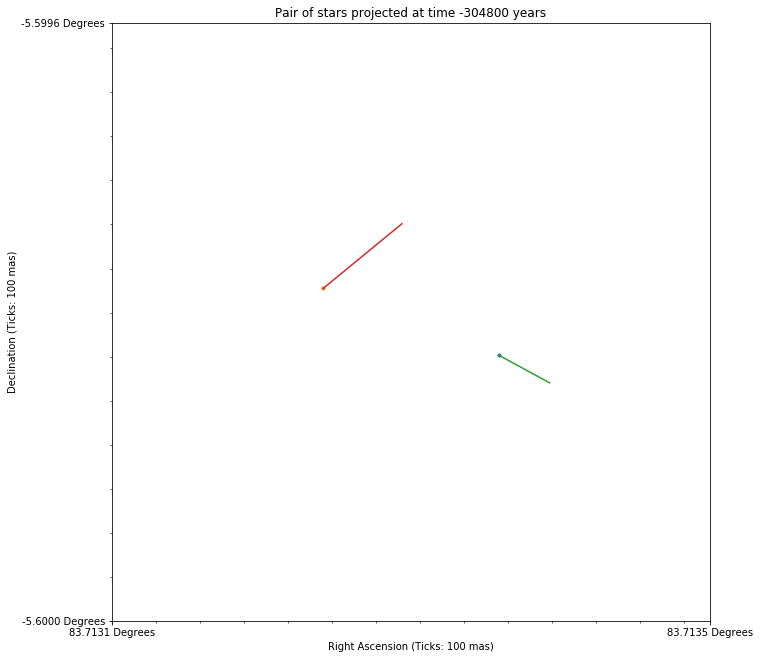

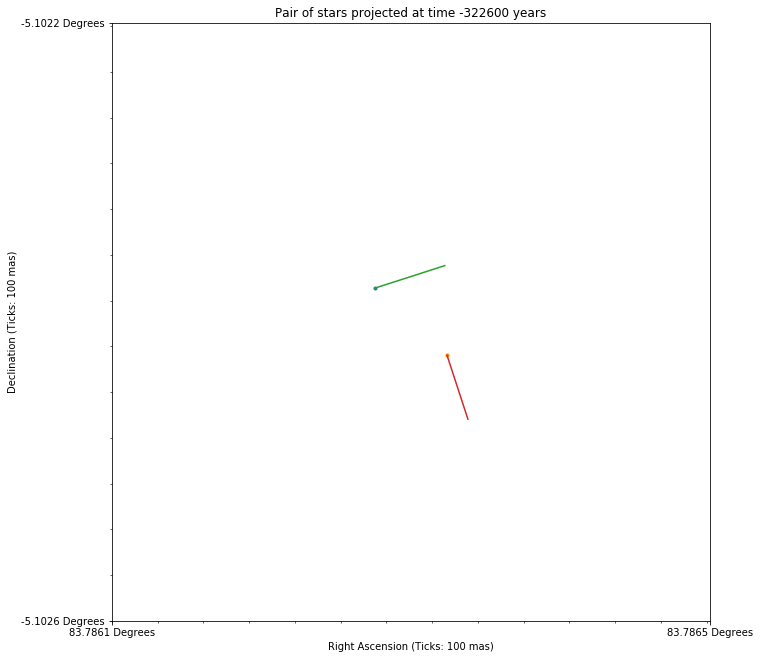

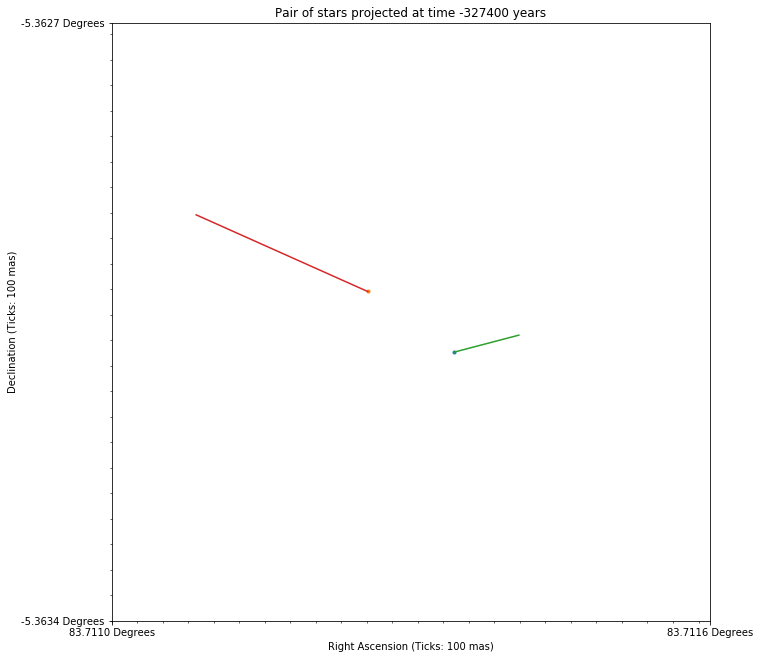

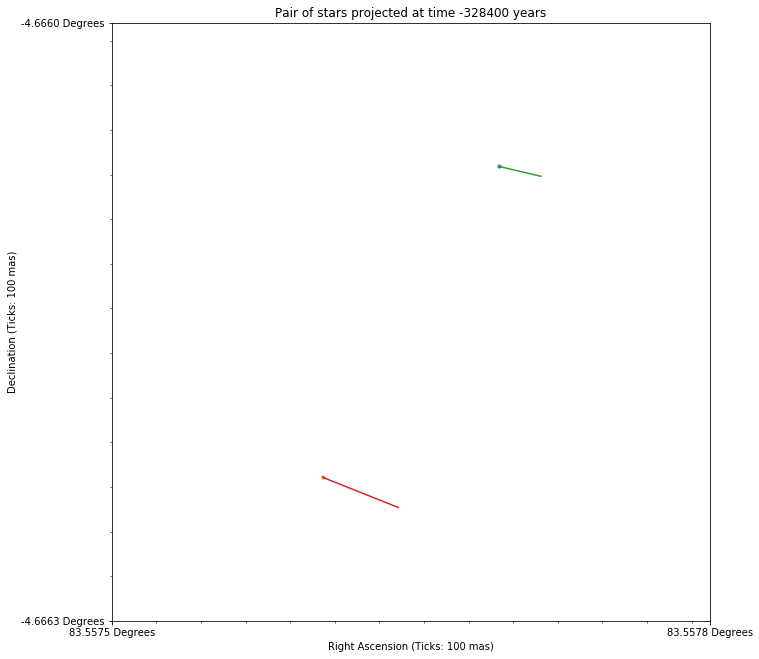

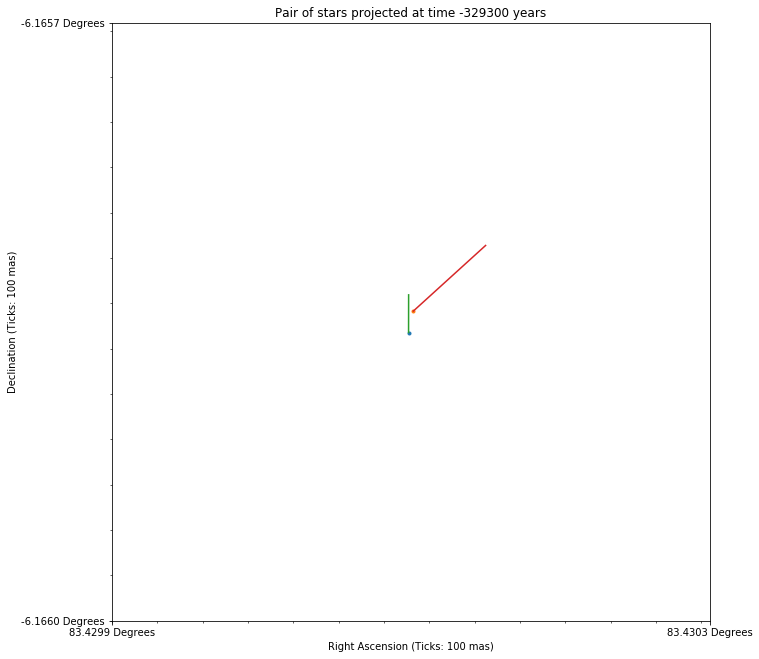

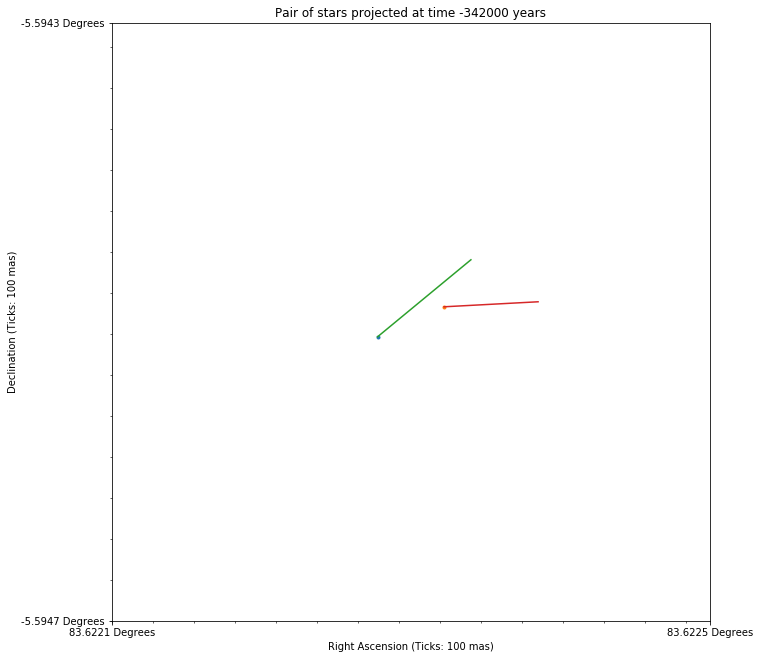

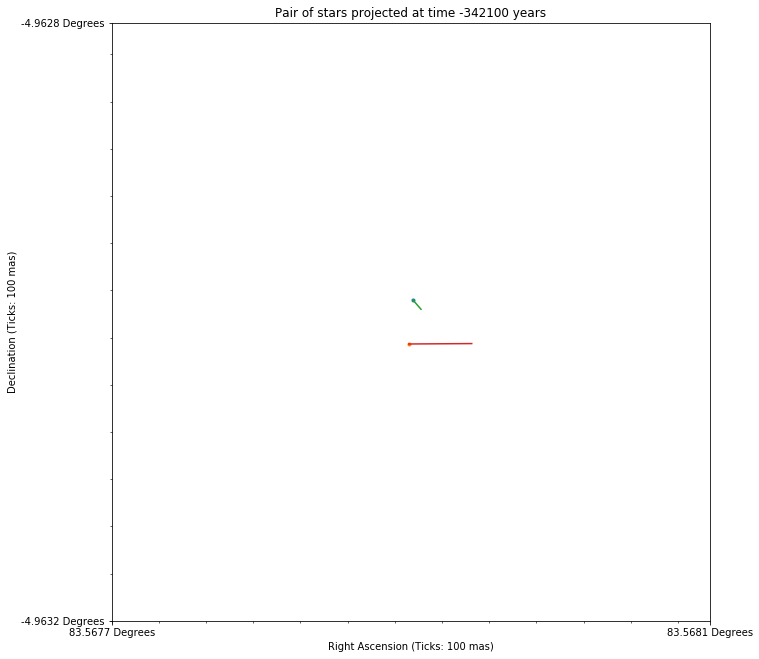

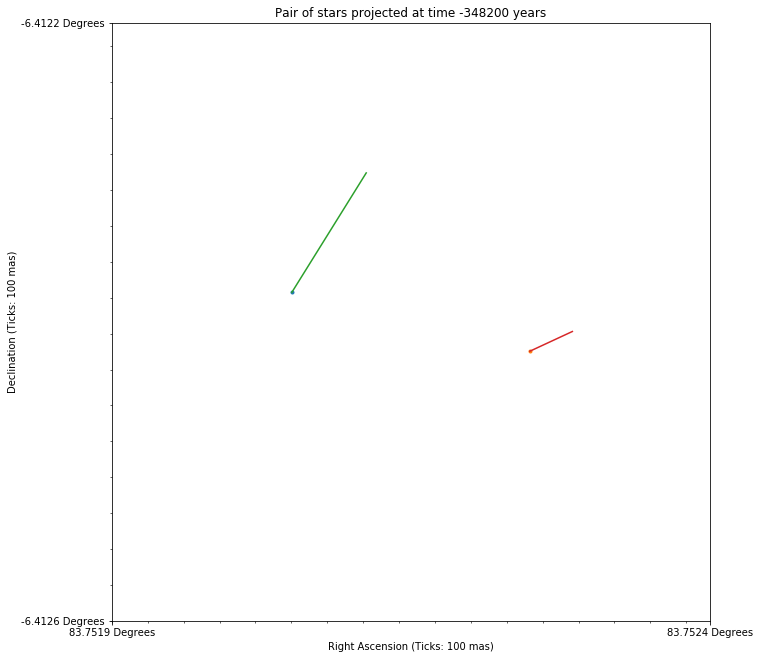

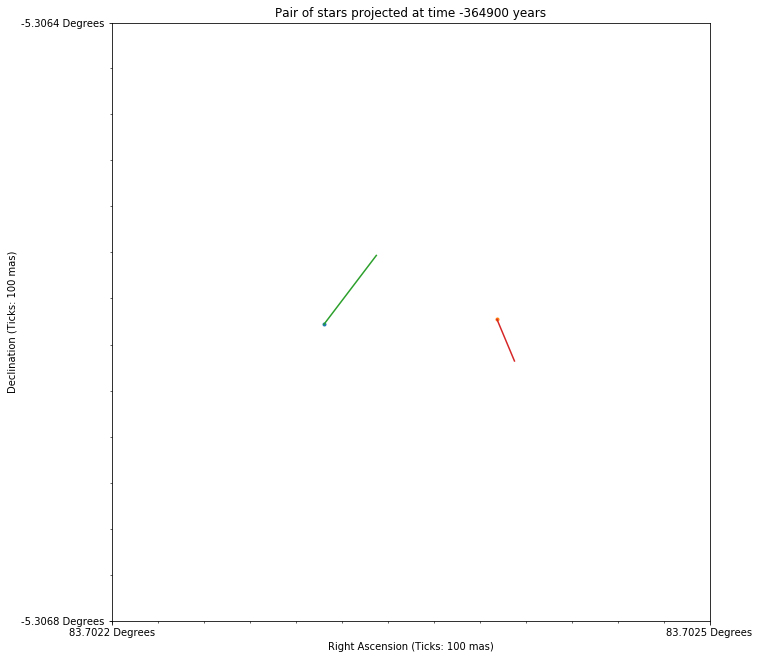

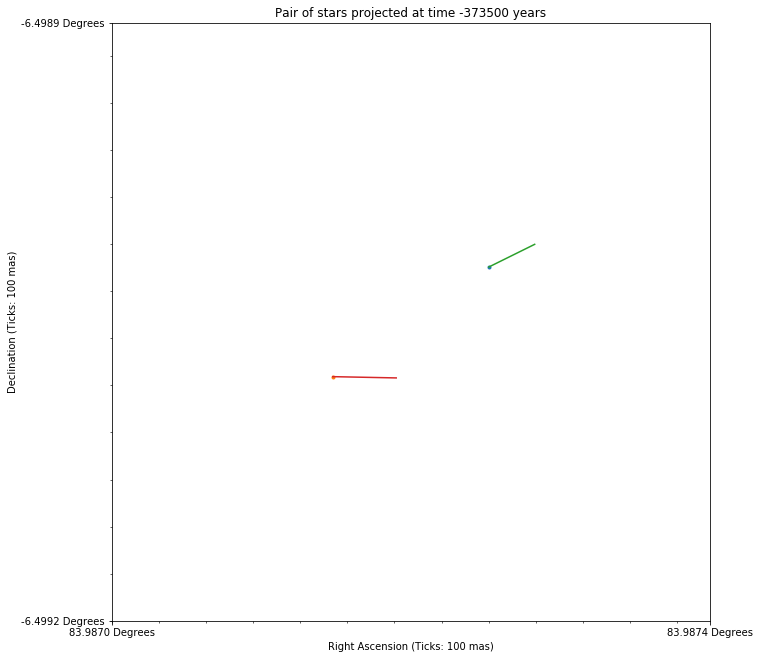

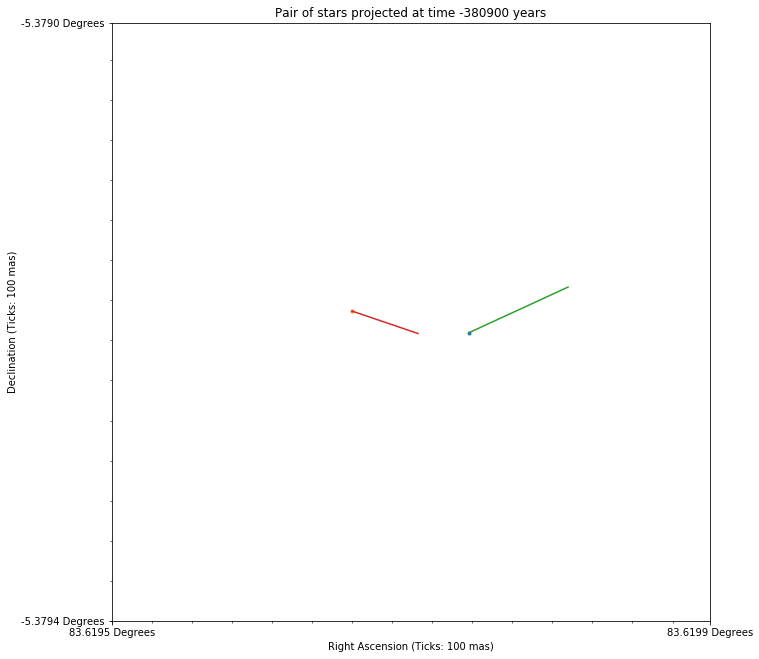

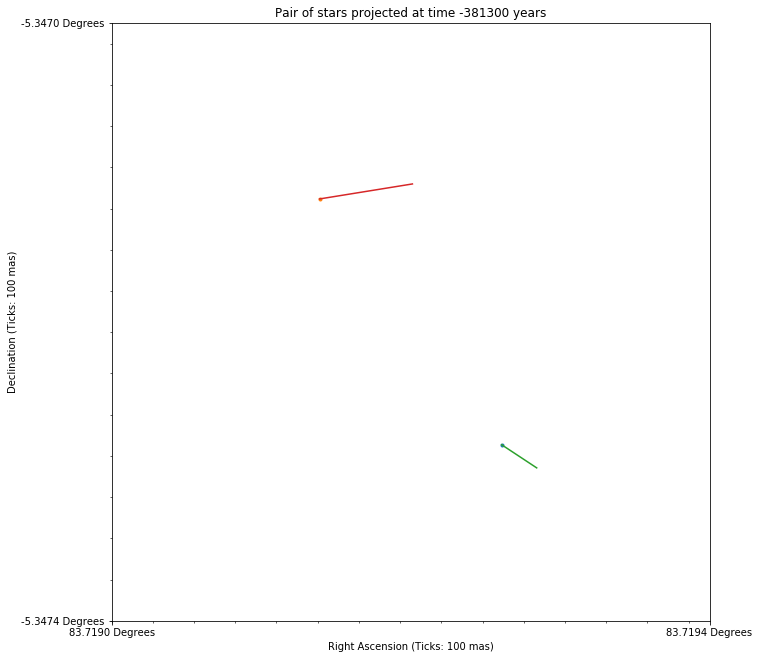

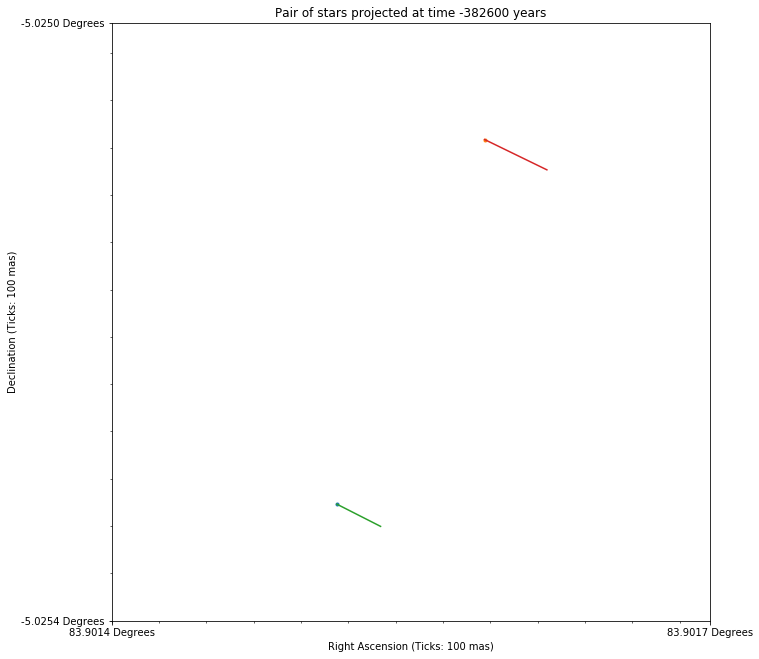

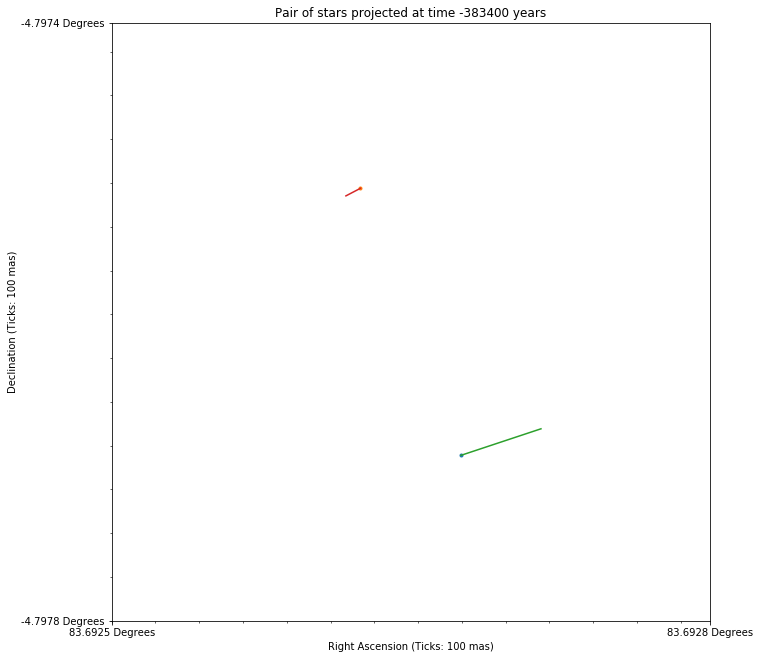

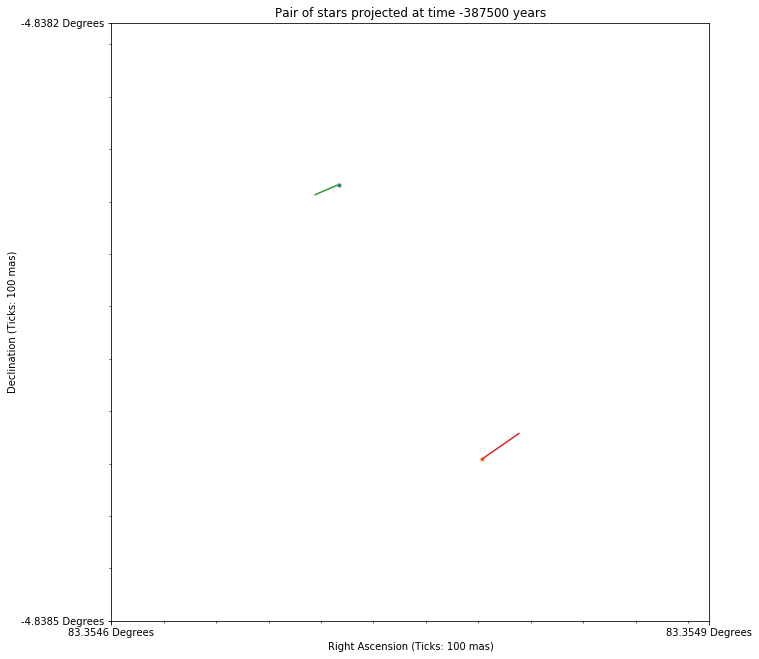

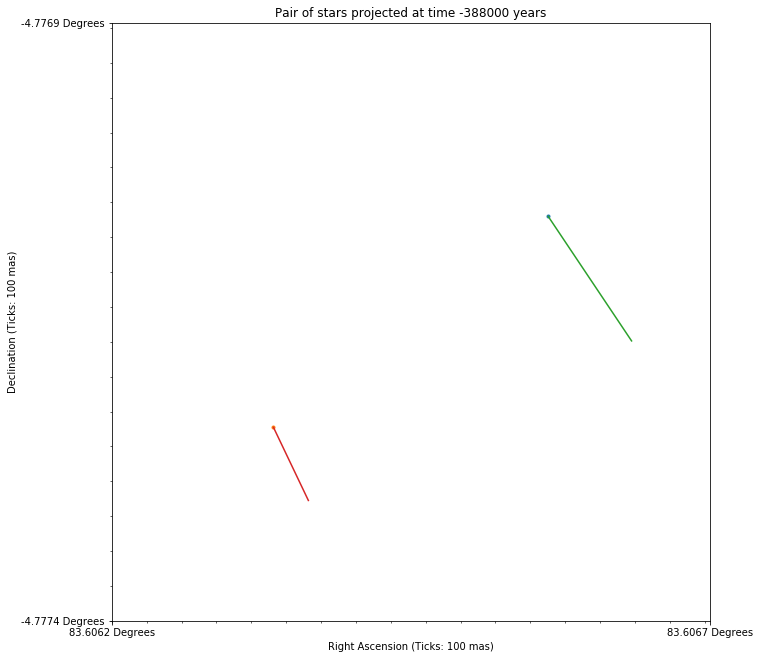

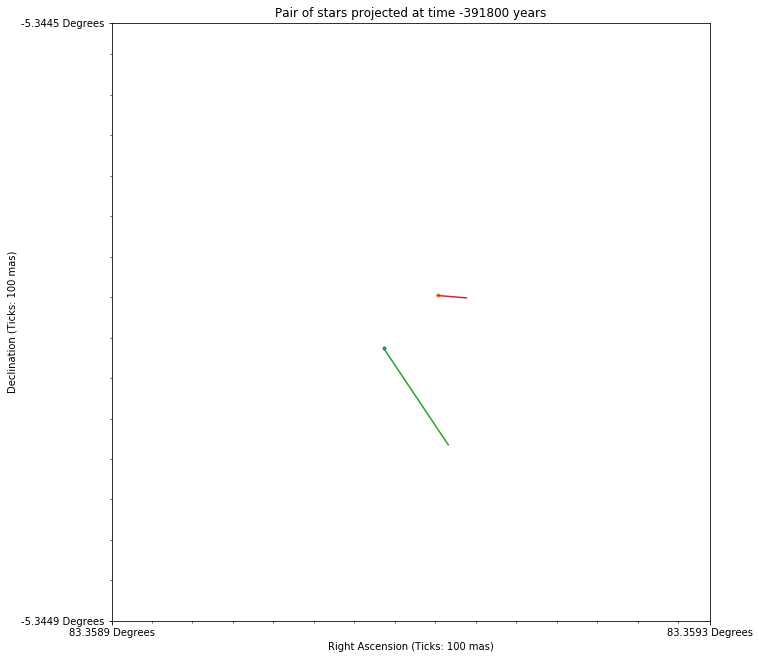

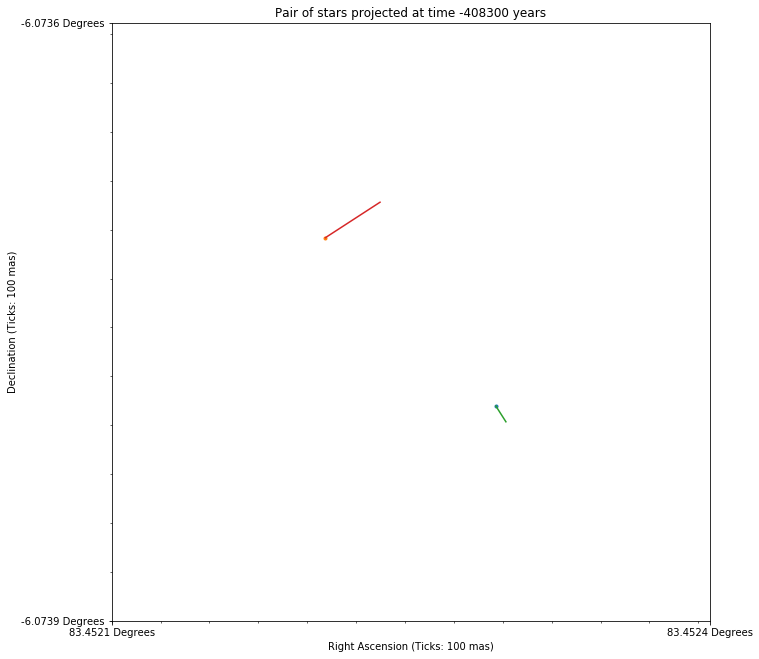

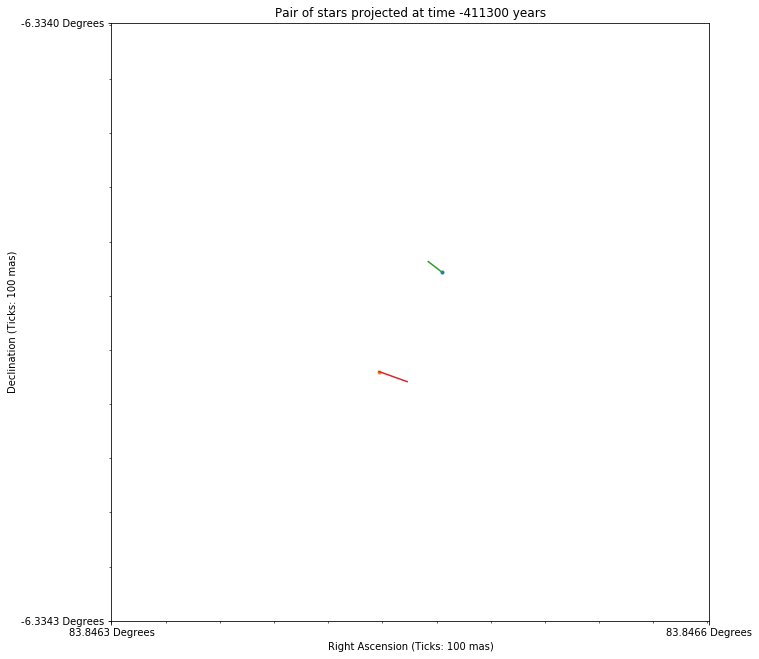

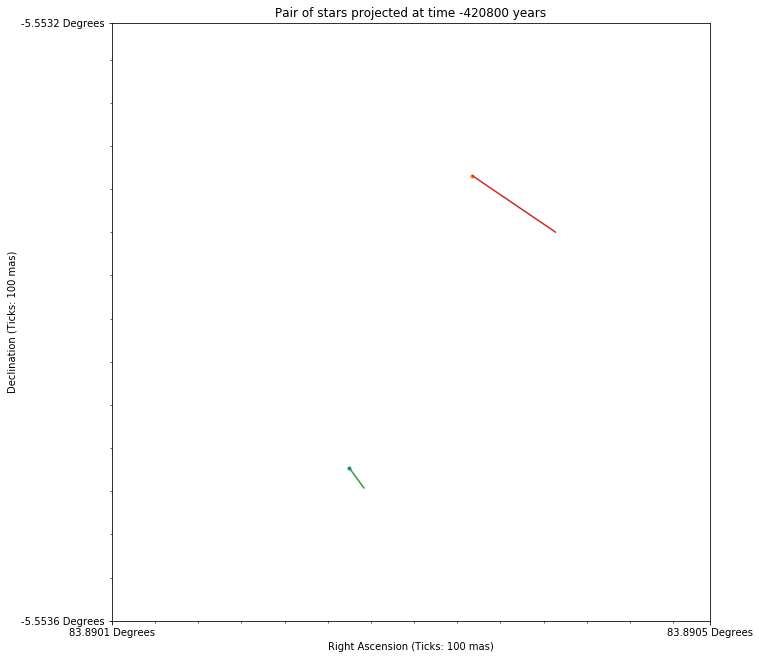

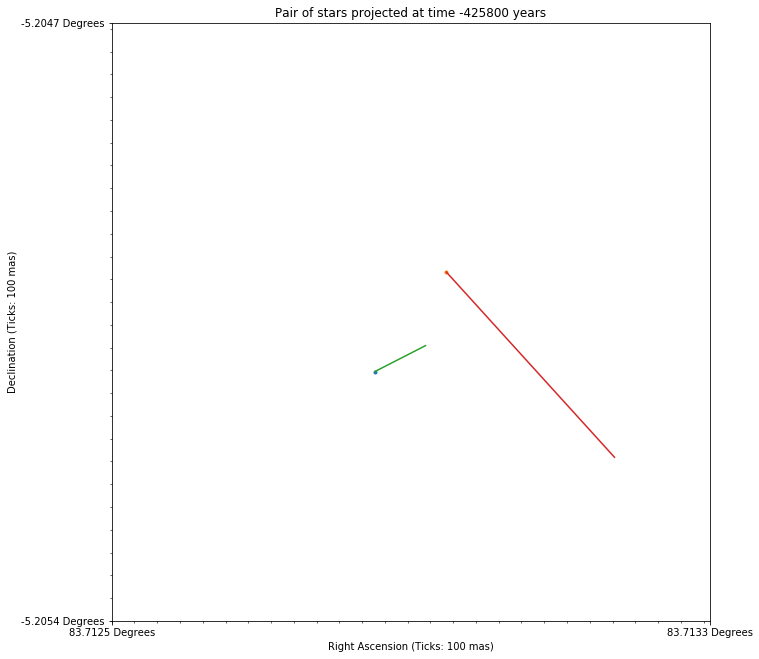

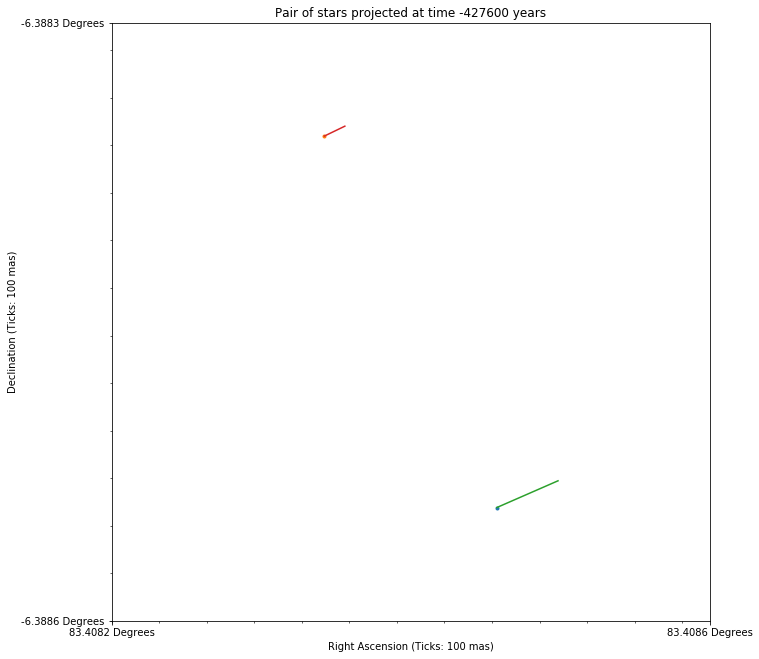

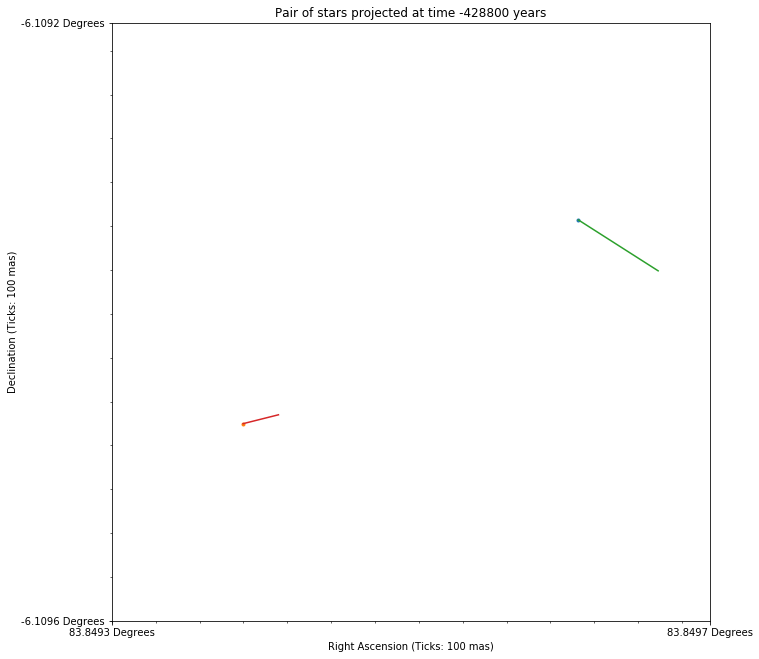

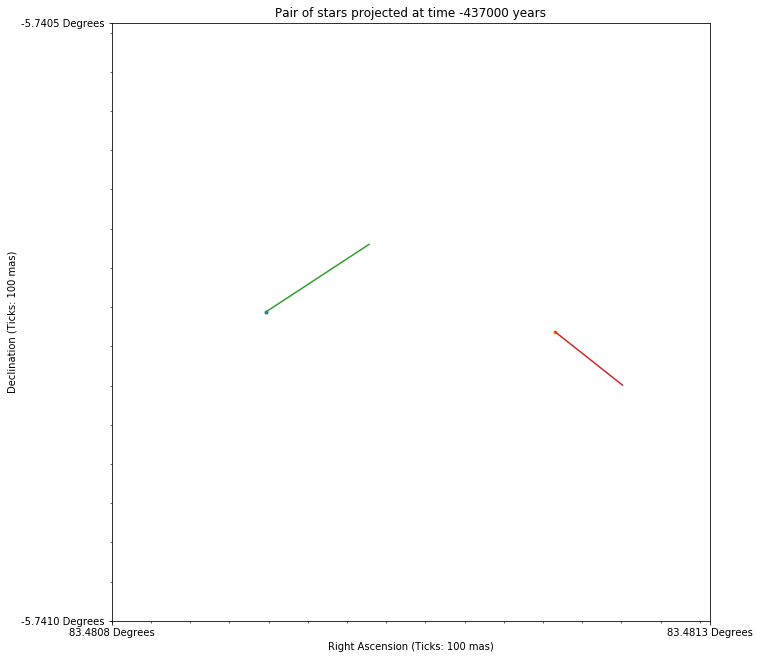

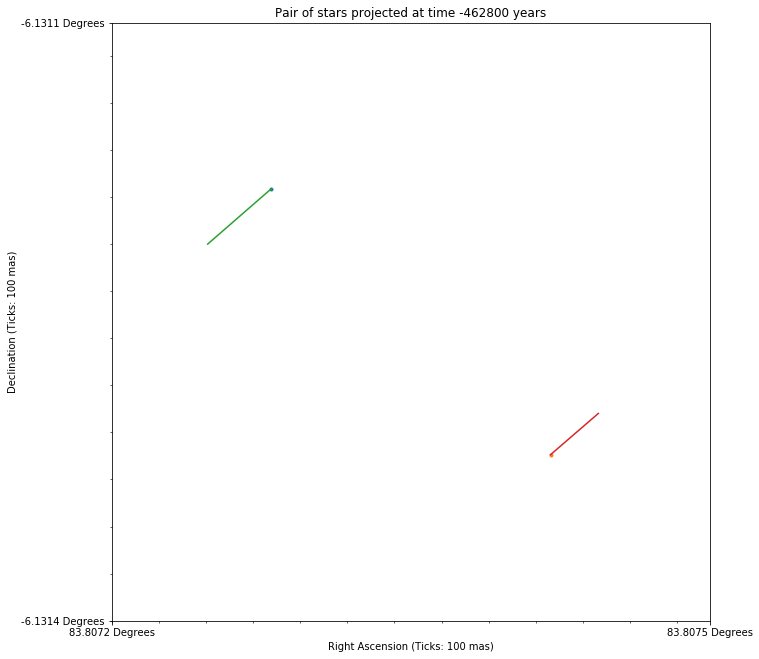

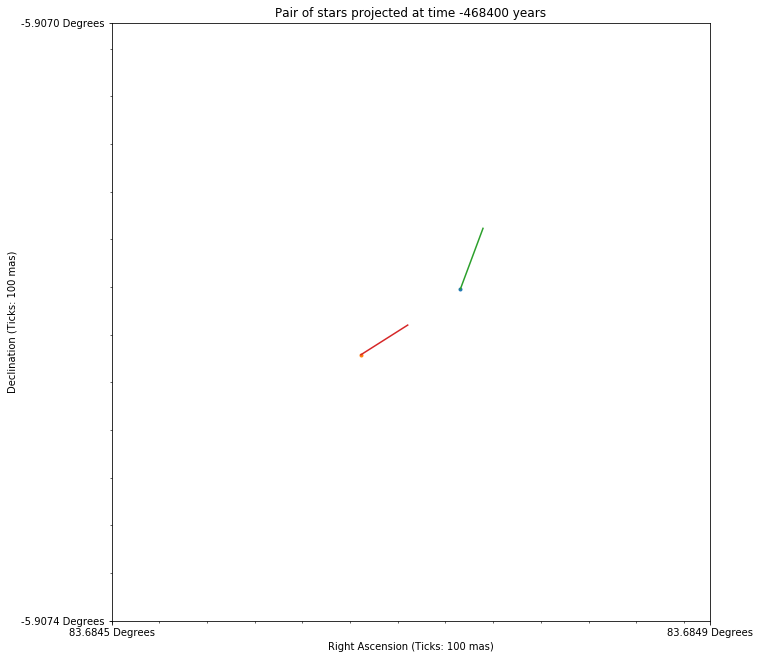

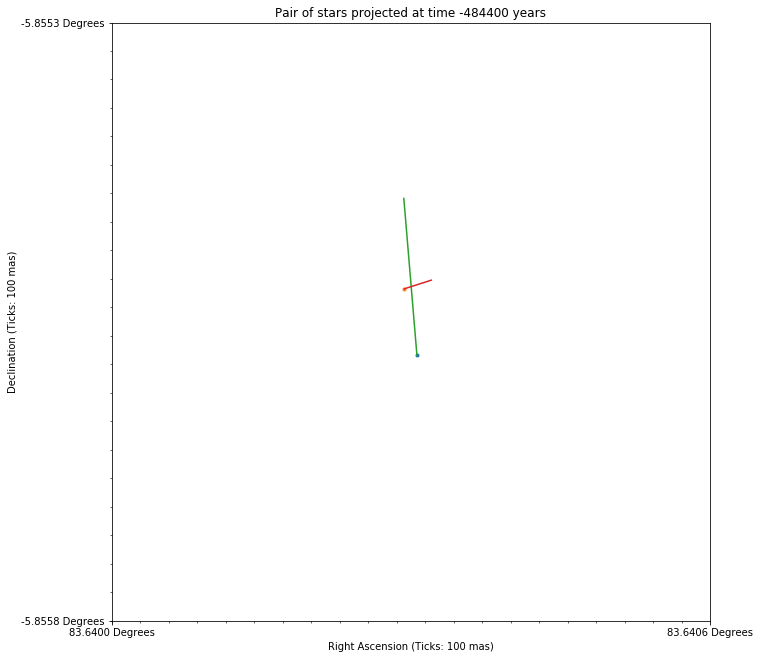

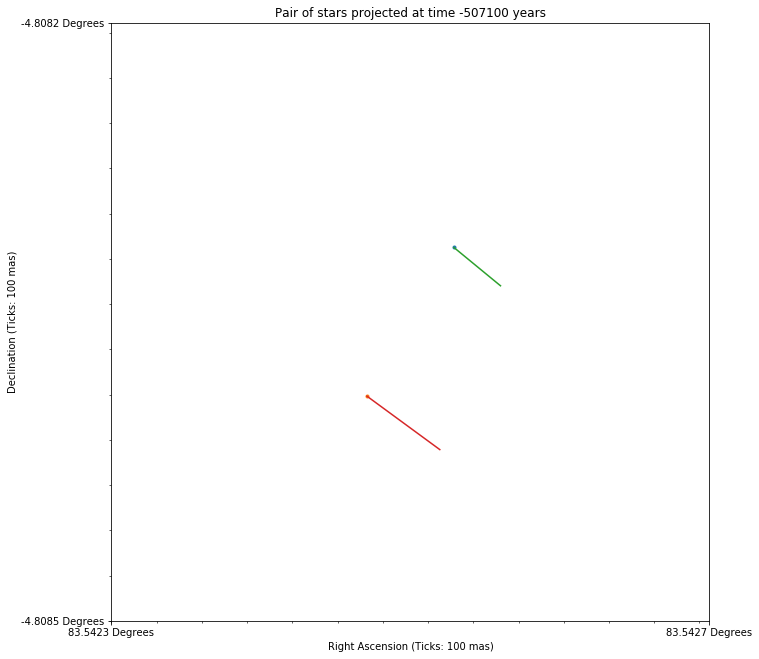

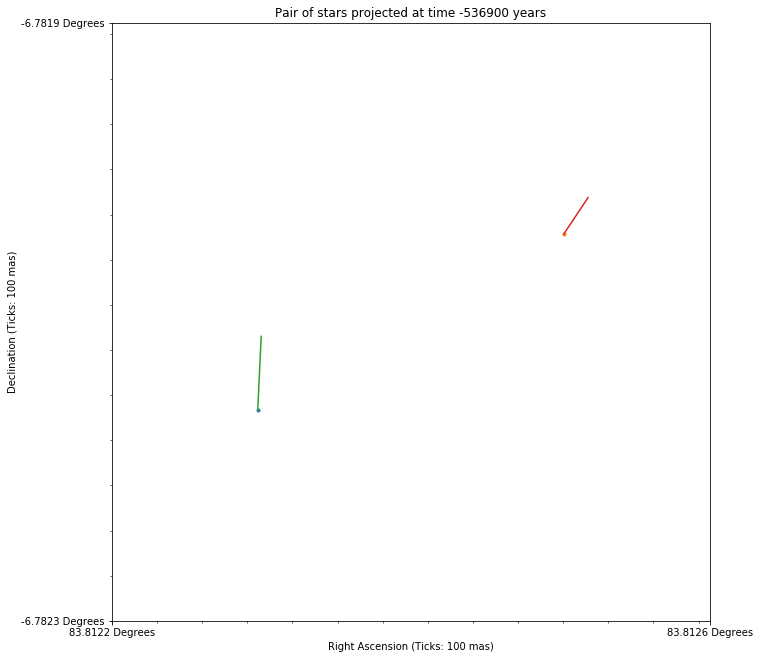

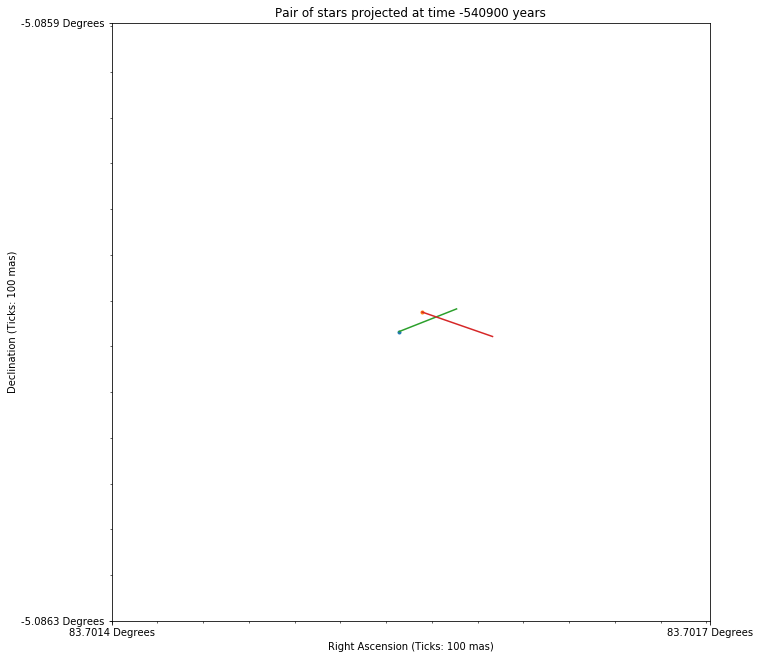

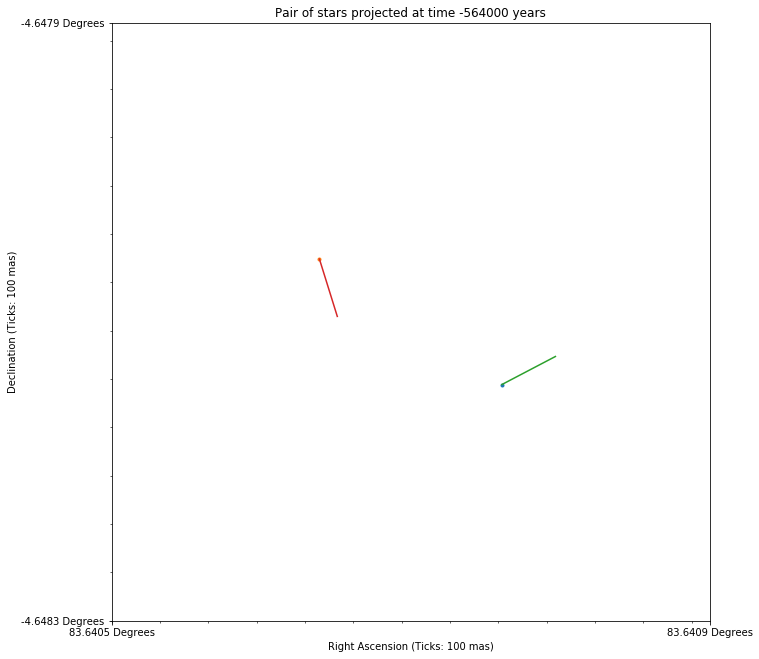

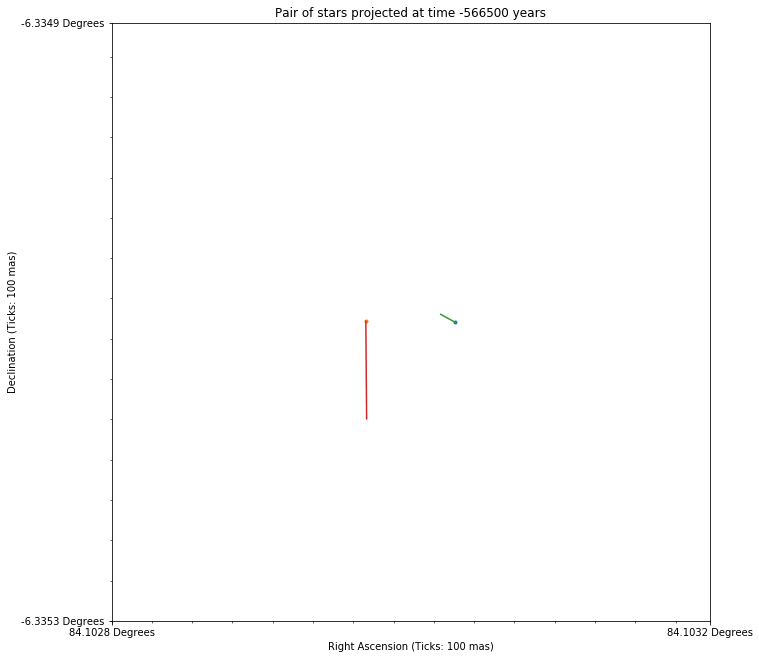

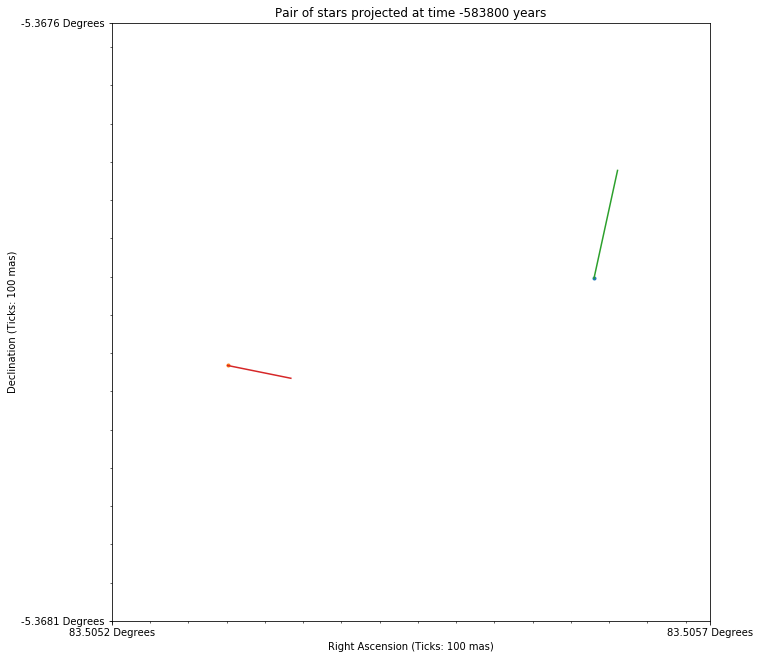

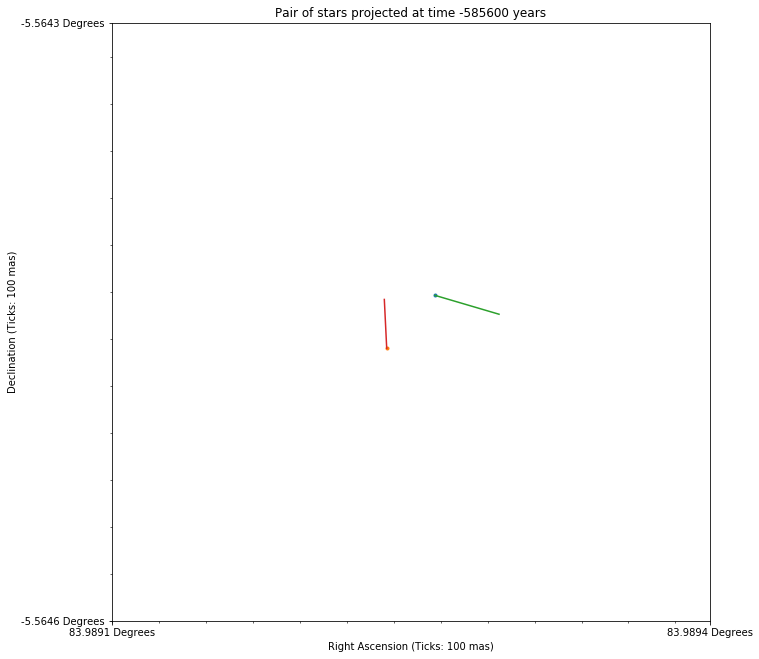

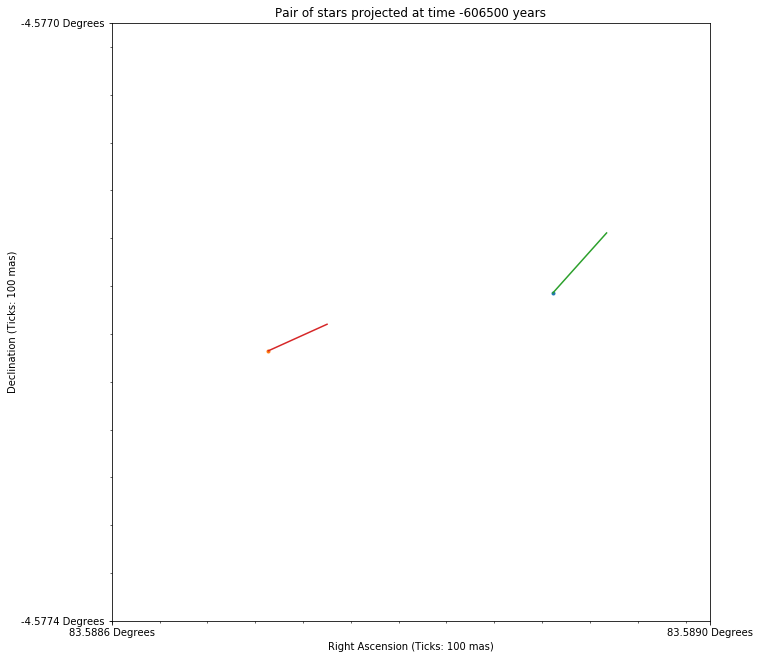

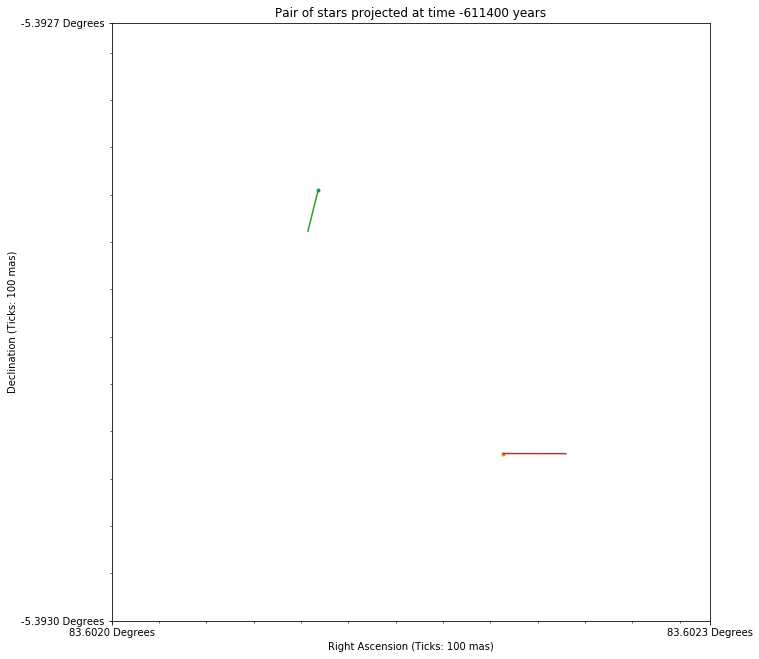

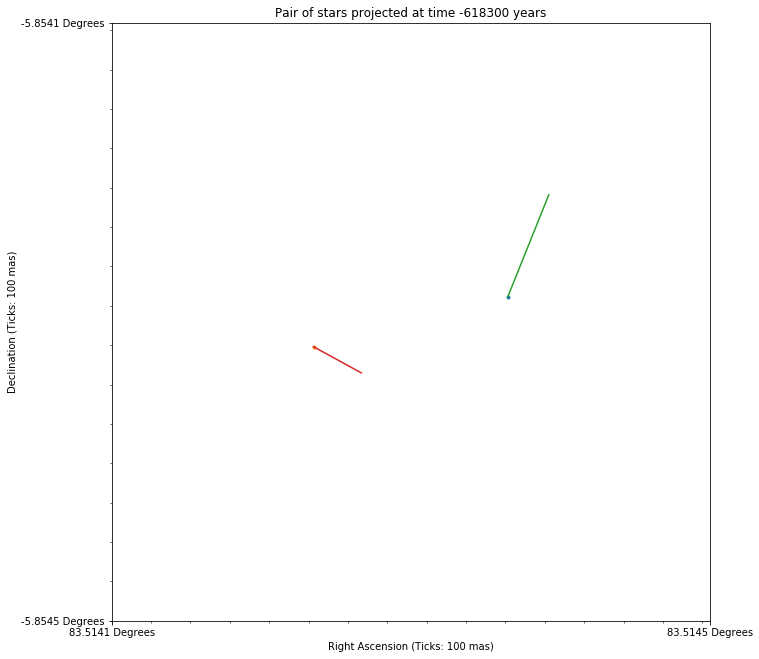

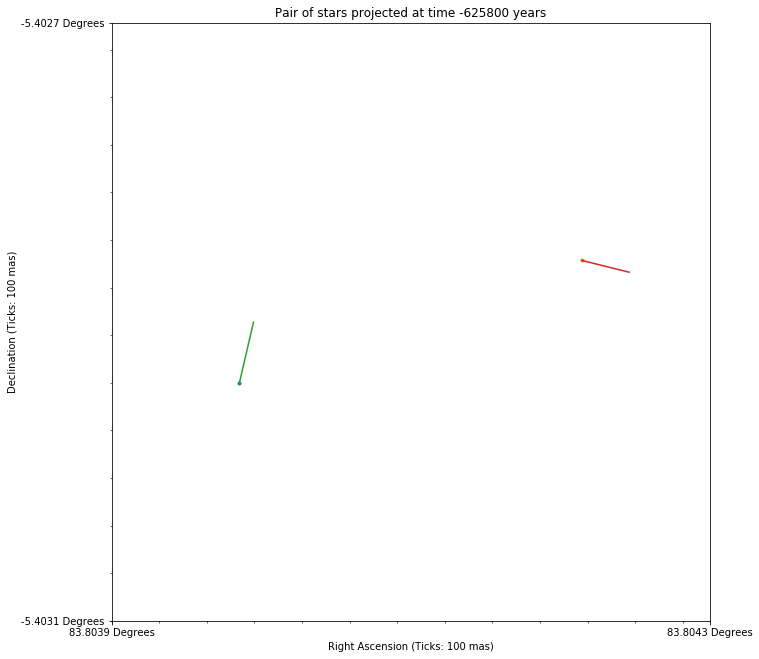

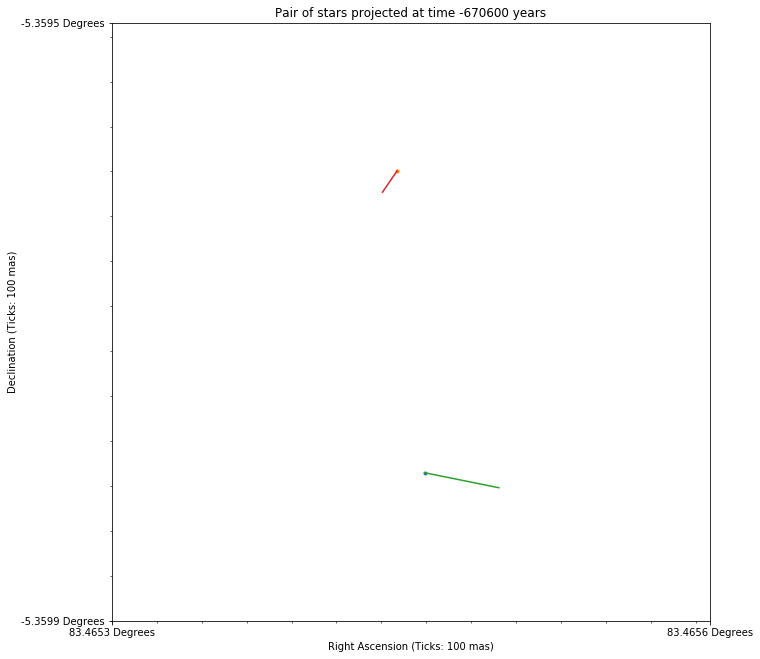

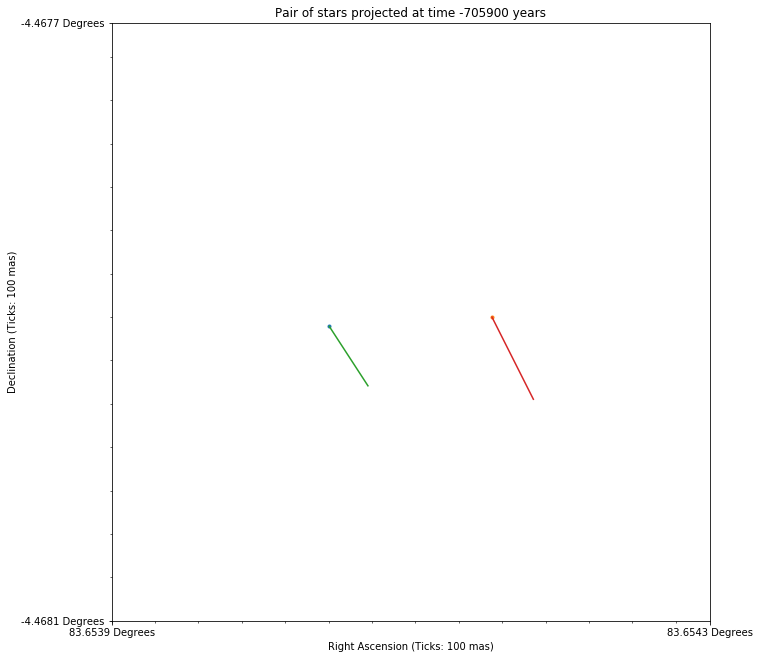

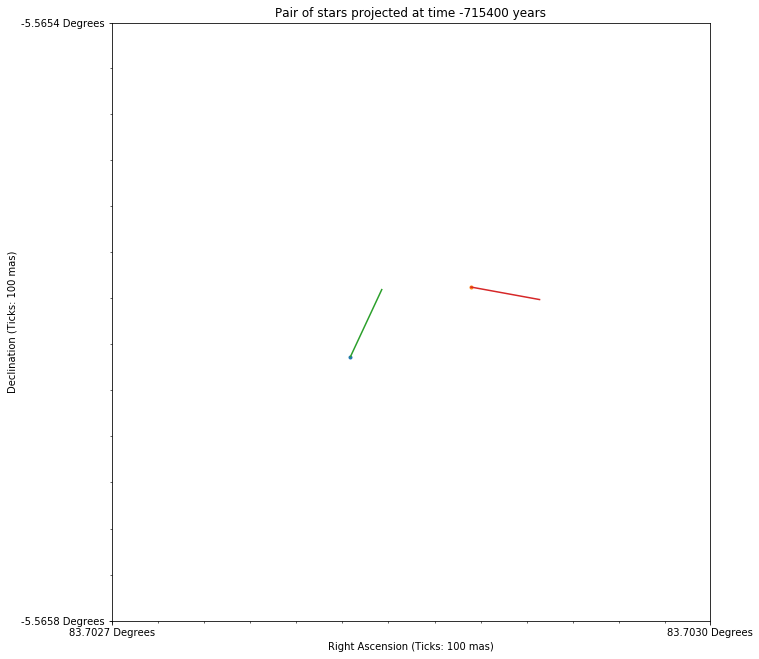

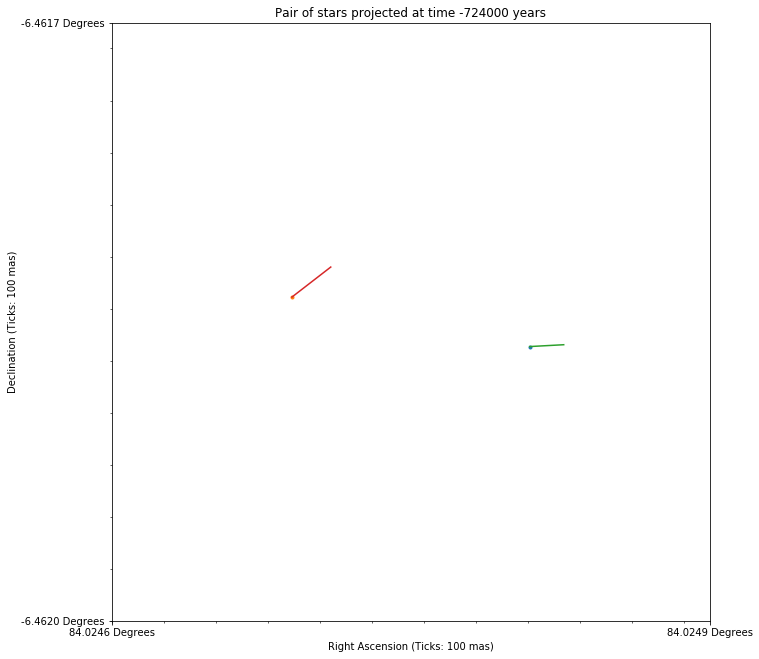

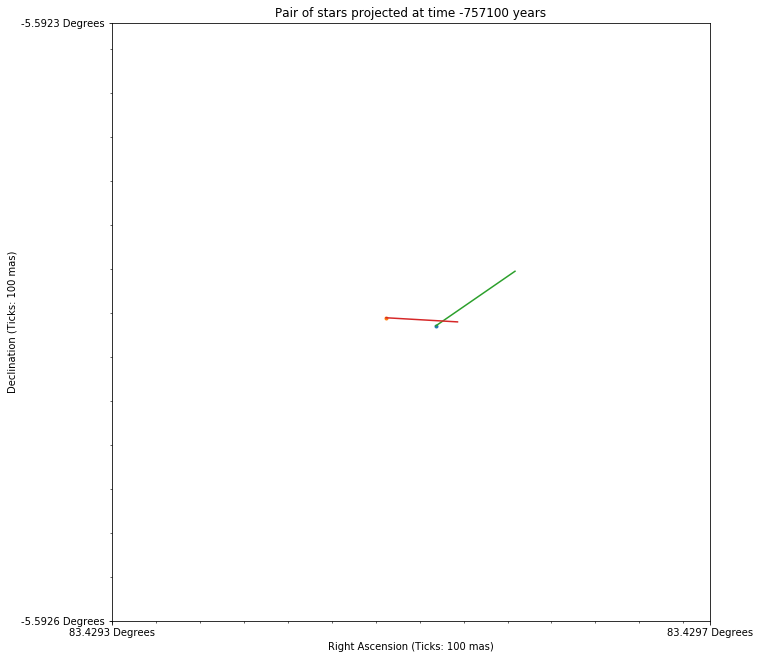

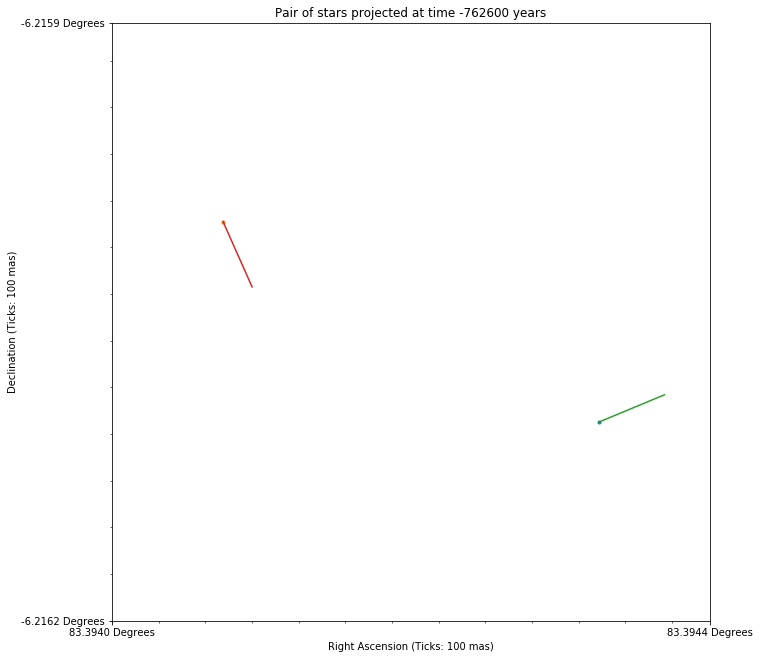

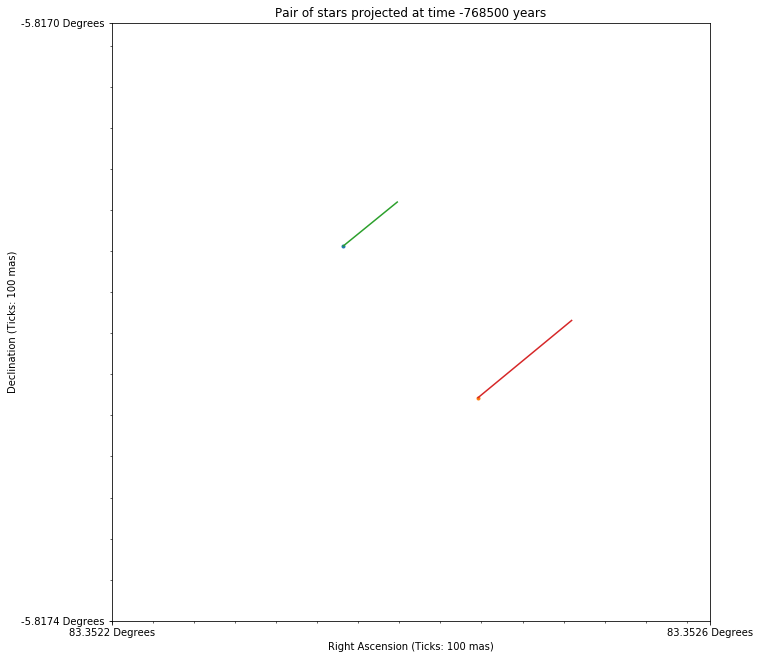

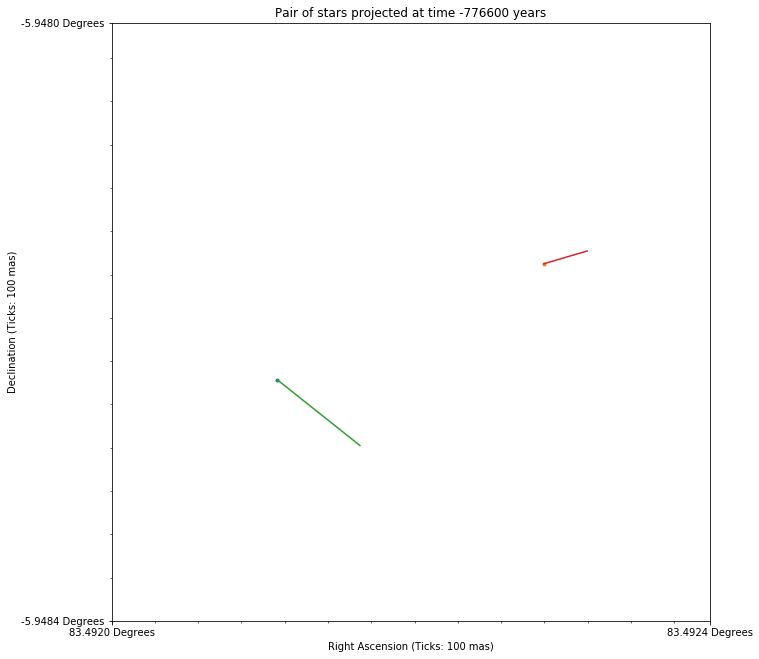

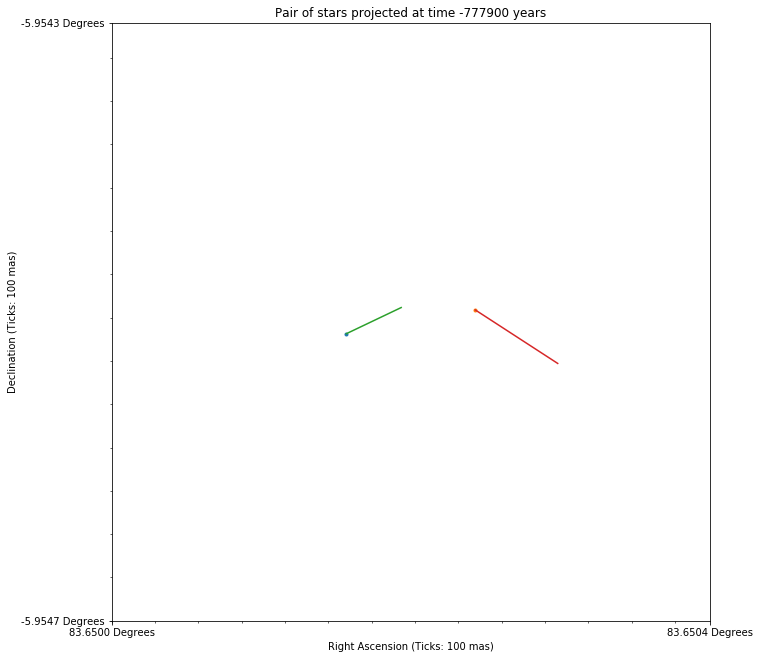

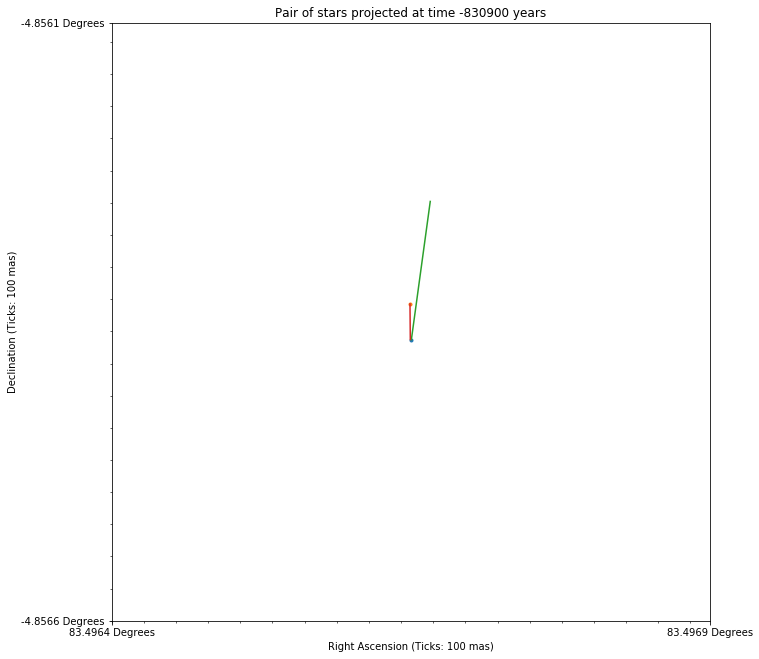

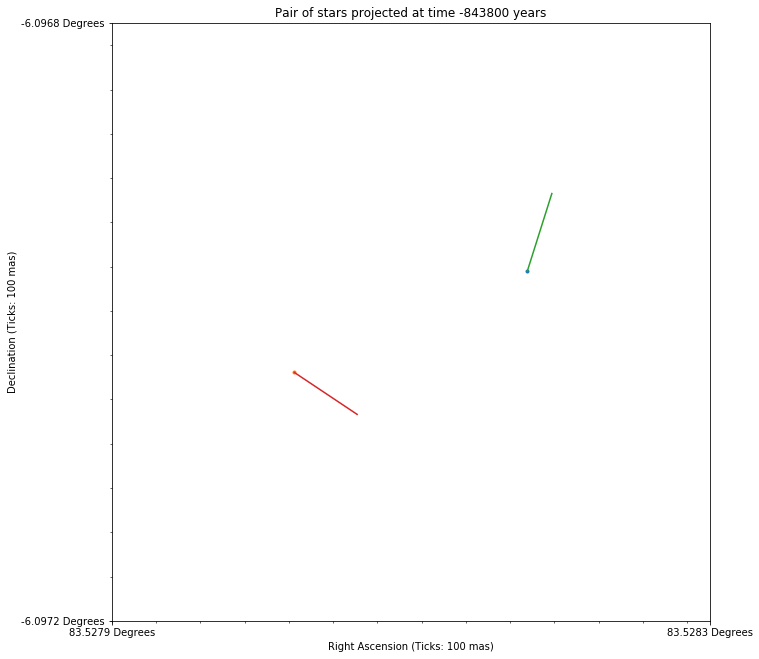

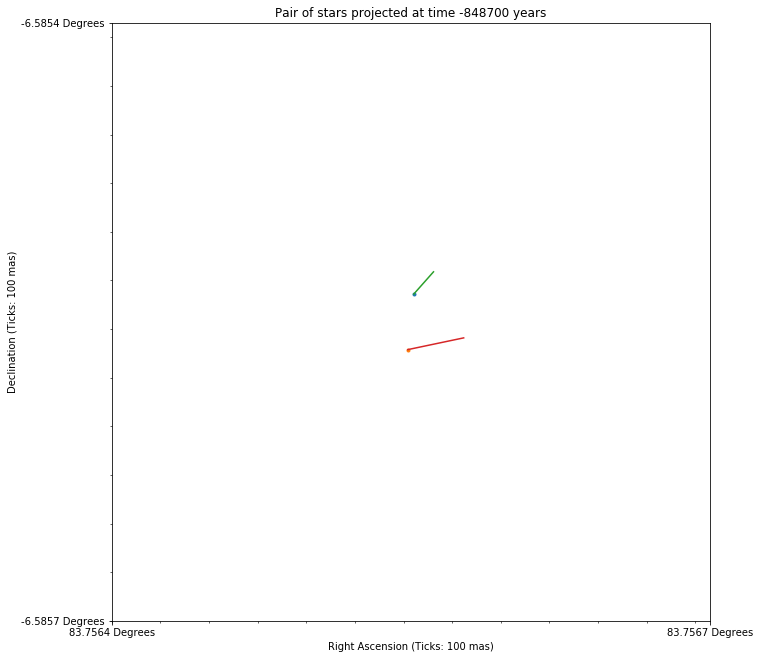

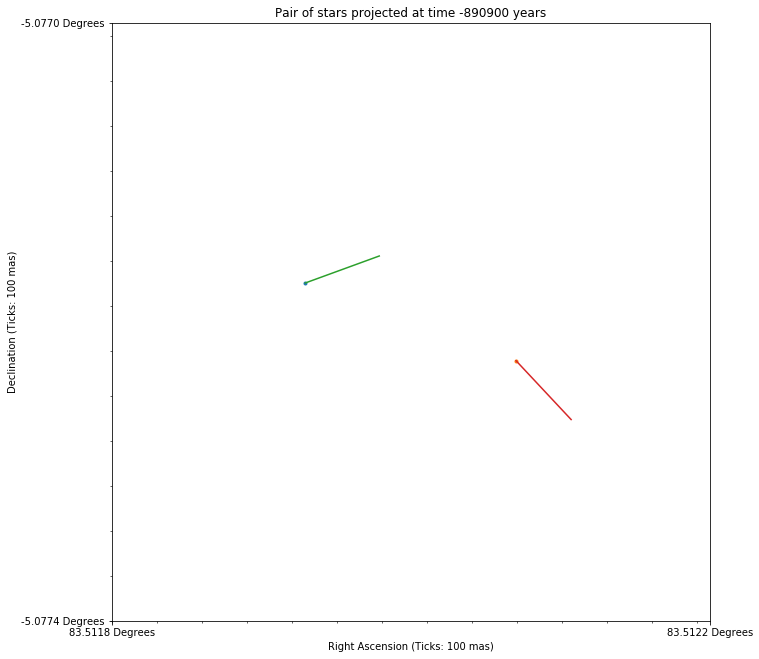

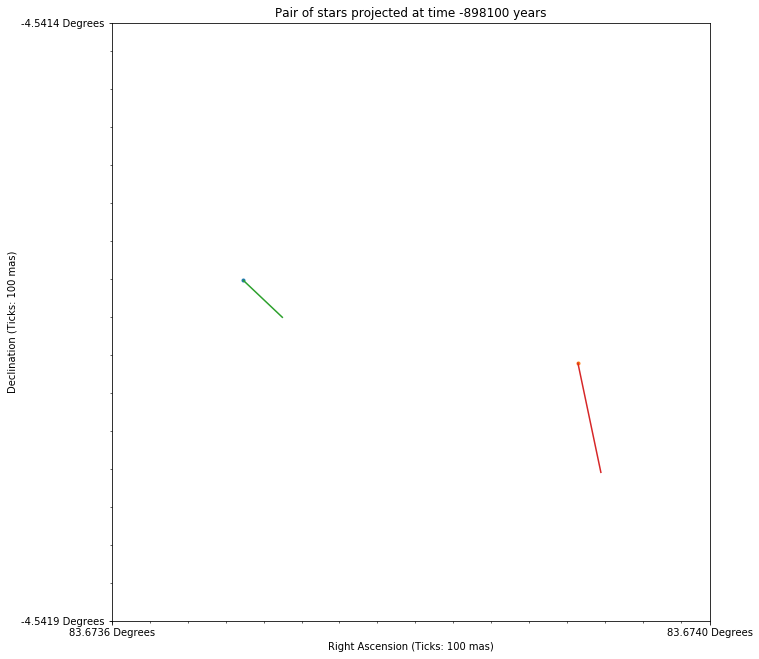

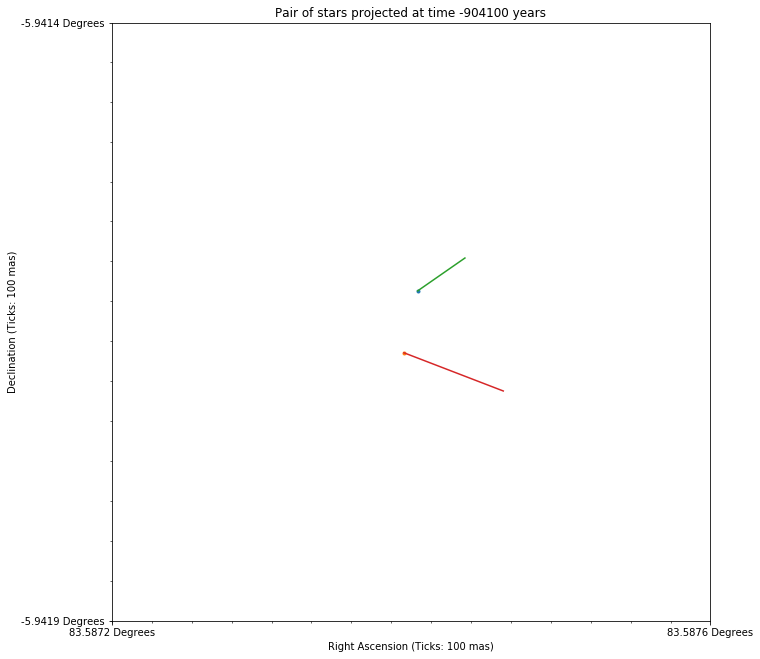

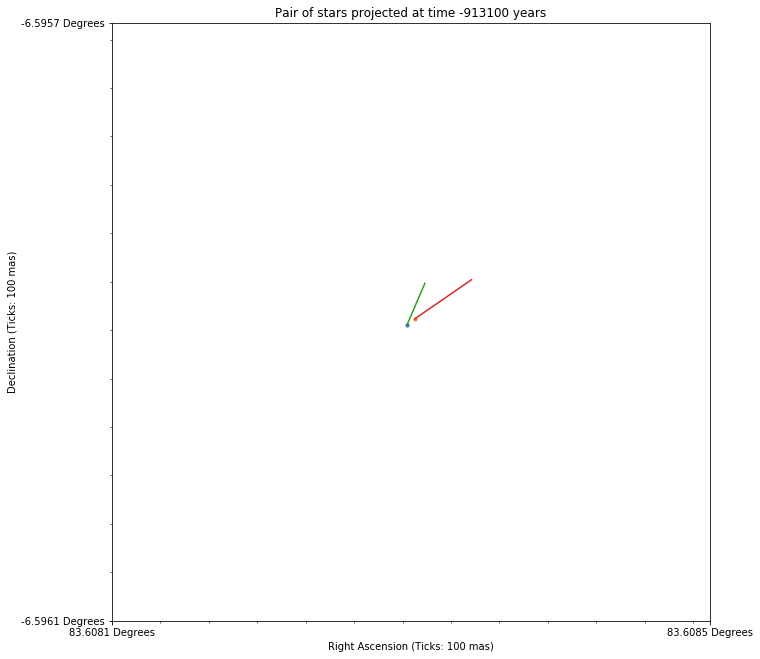

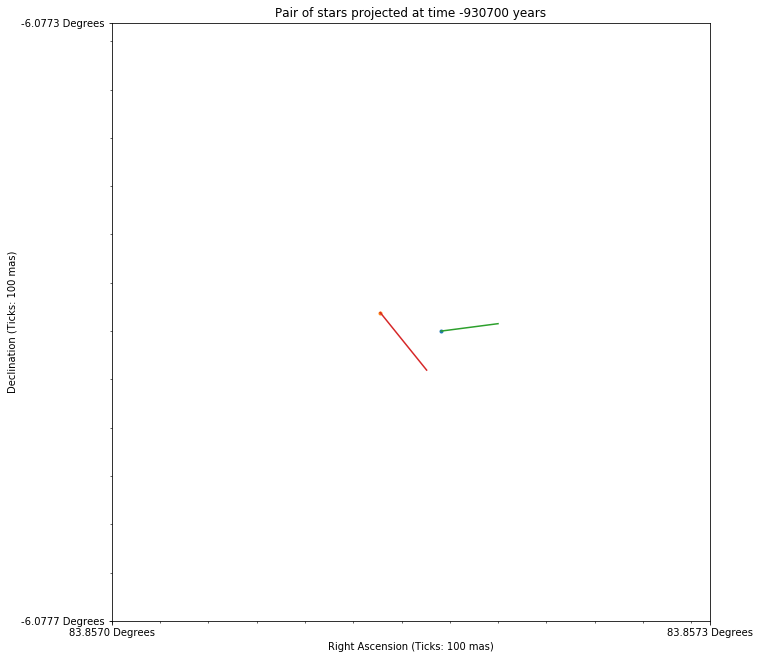

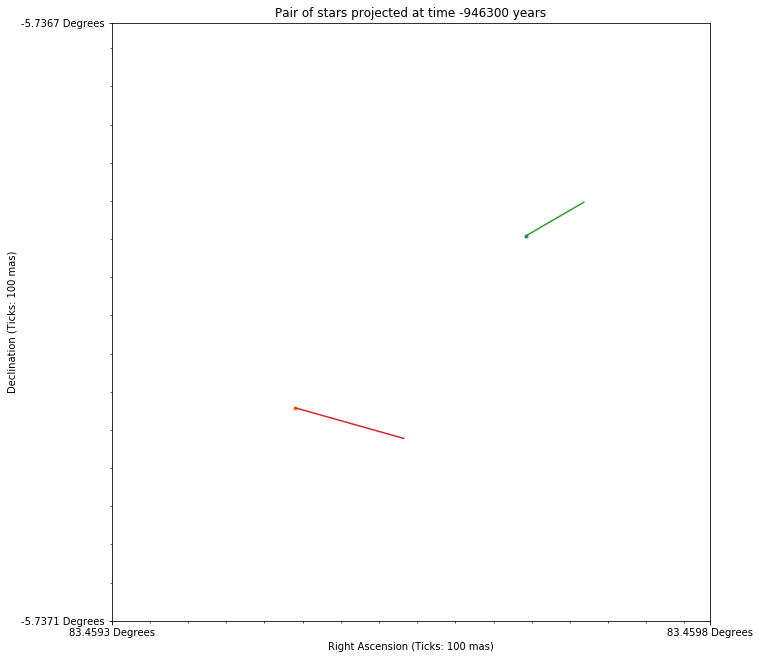

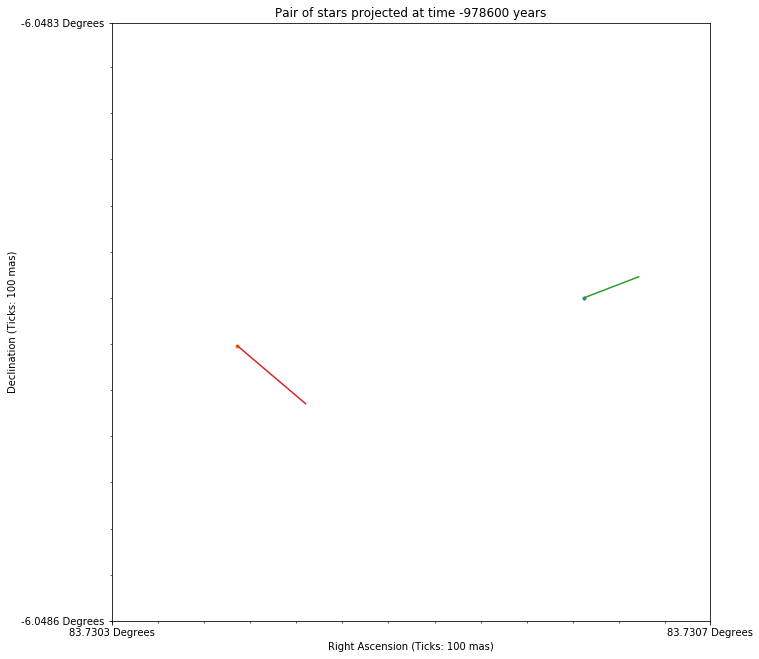

In [29]:
def getABox(ras, decs, pmras, pmdecs):
    maxDist = np.max([np.max(np.abs(pmras)),np.max(np.abs(pmdecs))]) / 3600 / 1000 * 100


    xmin = np.mean(ras) - arcsec/2 - maxDist
    xmax = np.mean(ras) + arcsec/2 + maxDist

    ymin = np.mean(decs) - arcsec/2 - maxDist
    ymax = np.mean(decs) + arcsec/2 + maxDist

    return ([xmin, xmax], [ymin, ymax])

for colNum in bothConf:
    x1 = confEnhance['projected_ra1'][colNum]
    y1 = confEnhance['projected_dec1'][colNum]
    xvec1 = confEnhance['pmra1'][colNum]
    yvec1 = confEnhance['pmdec1'][colNum]
    
    x2 = confEnhance['projected_ra2'][colNum]
    y2 = confEnhance['projected_dec2'][colNum]
    xvec2 = confEnhance['pmra2'][colNum]
    yvec2 = confEnhance['pmdec2'][colNum]
    
    currentT = confEnhance['time'][colNum]
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (11,11))

    axs.plot(x1, y1, '.')
    axs.plot(x2, y2, '.')
    #1/1000 - convert from mas to as - 1/3600 - convert from as to deg - 100 - vector for 100 years
    axs.plot([x1, x1 + (1/3600) * (1/1000) * 100 * xvec1], [y1, y1 + (1/3600) * (1/1000) * 100 * yvec1])
    axs.plot([x2, x2 + (1/3600) * (1/1000) * 100 * xvec2], [y2, y2 + (1/3600) * (1/1000) * 100 * yvec2])
    
    xstops, ystops = getABox(np.array([x1,x2]), np.array([y1, y2]), np.array([xvec1, xvec2]), np.array([yvec1, yvec2]))
    axs.set_xlim(xstops)
    axs.set_ylim(ystops)
    
    axs.xaxis.set_ticks(np.arange(xstops[0], xstops[1], arcsec*.1), True)
    axs.xaxis.set_ticks(xstops, False)
    axs.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f' + ' Degrees'))

    axs.yaxis.set_ticks(np.arange(ystops[0], ystops[1], arcsec*.1), True)
    axs.yaxis.set_ticks(ystops, False)
    axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f' + ' Degrees'))

    axs.set_aspect('equal')
    
    axs.set_title('Pair of stars projected at time ' + str(currentT) + ' years')
    axs.set_xlabel('Right Ascension (Ticks: 100 mas)')
    axs.set_ylabel('Declination (Ticks: 100 mas)')
    
    plt.show()

In [30]:
kim18 = Table.read('C:\\Users\sahal\\2018TrinaryWork\\TrinaryStarSearch\\Data\\kim18.fits')
kim18

ID,ra,dec,mualpha,mualpha_err,mudelta,mudelta_err,Nepochs,dT,mag139,flag
int16,float64,float64,float32,float32,float32,float32,int16,float32,float32,bool
137,83.80750185,-5.36862019,-1.51,0.9,-1.03,0.52,3,14.0,9.7,False
567,83.81247376,-5.36664137,2.25,0.09,0.96,0.11,2,14.0,10.37,False
445,83.79075216,-5.40193468,-5.21,0.35,-14.5,0.01,3,16.3,17.34,False
500,83.84404645,-5.4340279,-2.93,0.45,-15.24,0.13,3,19.3,16.97,False
621,83.82598692,-5.42645888,12.93,0.05,-6.77,0.11,2,14.6,13.06,False
